In [2]:
import numpy as np
from scipy import interpolate, stats
import matplotlib.pyplot as plt
import pandas as pd
import geopy.distance
from scipy.stats import norm

In [3]:
df = pd.read_csv("../data/Fresno_Water_Rights.csv")
print(df.columns)

Index(['geometry', 'POD_ID', 'APPL_ID', 'POD_NUM', 'TOWNSHIP_NUMBER',
       'TOWNSHIP_DIRECTION', 'RANGE_NUMBER', 'RANGE_DIRECTION',
       'SECTION_NUMBER', 'SECTION_CLASSIFIER', 'QUARTER', 'QUARTER_QUARTER',
       'MERIDIAN', 'NORTH_COORD', 'EAST_COORD', 'SP_ZONE', 'LATITUDE',
       'LONGITUDE', 'TRIB_DESC', 'Location_Method', 'SOURCE_NAME', 'Moveable',
       'Has_OPOD', 'WATERSHED', 'COUNTY', 'WELL_NUMBER', 'QUAD_MAP_NAME',
       'QUAD_MAP_NUM', 'QUAD_MAP_MIN_SER', 'PARCEL_NUMBER',
       'DIVERSION_SITE_NAME', 'SPECIAL_AREA', 'HUC_12', 'HUC_8', 'HU_8_NAME',
       'HU_12_NAME', 'DIRECT_DIV_AMOUNT', 'DIVERSION_STORAGE_AMOUNT',
       'DIVERSION_AC_FT', 'POD_STATUS', ' FACE_VALUE_AMOUNT ',
       'DIVERSION_TYPE', 'DIVERSION_CODE_TYPE', 'WR_TYPE', 'WR_STATUS',
       'STORAGE_TYPE', 'POD_UNIT', 'FIRST_NAME', 'LAST_NAME', 'ENTITY_TYPE'],
      dtype='object')


In [4]:
df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'DIRECT_DIV_AMOUNT', 'POD_UNIT'])
df2 = df[['LATITUDE', 'LONGITUDE', 'DIRECT_DIV_AMOUNT', 'POD_UNIT']]

# There are multiple diversions on some locations
df2 = df2.groupby(['LATITUDE', 'LONGITUDE', 'POD_UNIT'], as_index = False).sum()

In [5]:
df2 = df2[df2["DIRECT_DIV_AMOUNT"] != 0]

In [6]:
x = df2["LATITUDE"].values
y = df2["LONGITUDE"].values
z = df2["DIRECT_DIV_AMOUNT"].values # Should we include storage div amounts
# What are the units? Are the units different depending on the units column?

In [7]:
df2.groupby(['POD_UNIT'])['DIRECT_DIV_AMOUNT'].describe()

,count,mean,std,min,25%,50%,75%,max
POD_UNIT,,,,,,,,
Cubic Feet per Second,232.0,1953.658871,3362.274465,0.002,2.23,175.0,4500.0,32953.0
Gallons per Day,286.0,3039.386364,4703.431183,3.000,200.00,600.0,5957.5,36000.0
Gallons per Minute,10.0,2431.800000,1451.199182,18.000,1500.00,3500.0,3500.0,3500.0


(array([381., 112.,  17.,  10.,   3.,   0.,   2.,   0.,   1.,   2.]),
 array([2.00000000e-03, 3.60000180e+03, 7.20000160e+03, 1.08000014e+04,
        1.44000012e+04, 1.80000010e+04, 2.16000008e+04, 2.52000006e+04,
        2.88000004e+04, 3.24000002e+04, 3.60000000e+04]),
 <a list of 10 Patch objects>)

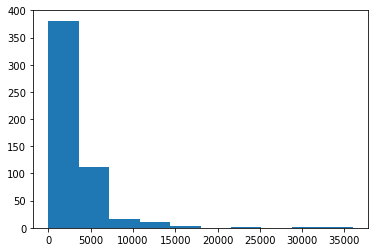

In [8]:
plt.hist(z)

In [9]:
stats.describe(z)

DescribeResult(nobs=528, minmax=(0.002, 36000.0), mean=2550.816965909091, variance=17241687.57831448, skewness=3.4282176310423638, kurtosis=18.30684740815012)

In [10]:
s = np.empty(len(z))

for i in range(0, len(z)):
    
    lat1 = x[i]
    long1 = y[i]
    
    dist_sum = 0
    
    for j in range(0, len(z)):
        
        if i == j:
            next
        
        lat2 = x[j]
        long2 = y[j]
        
        dist_sum = dist_sum + geopy.distance.distance((lat1, long1), (lat2, long2)).km
        
    s[i] = dist_sum / (len(z) - 1)

In [11]:
import geof
print(geof.geo_dist.__doc__)

s12 = geo_dist(lat1,lon1,lat2,lon2)

Wrapper for ``geo_dist``.

Parameters
----------
lat1 : input float
lon1 : input float
lat2 : input float
lon2 : input float

Returns
-------
s12 : float



In [12]:
import math

def norm_pdf(x, mean = 0, scale = 1):
    
    factor = 1/(scale * math.sqrt(2*math.pi))
    
    exponent = -0.5*((x - mean)/scale)**2
    
    return factor*math.exp(exponent)
    

In [13]:
norm.pdf(5, scale = 3)

0.03315904626424956

In [14]:
norm_pdf(5, scale = 3)

0.03315904626424956

In [32]:
def water_right_score(lat, long):
    
    score = 0
    
    disp = np.mean(s)/2
    
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        right1 = z[i]
        #disp1 = s[i]/2
        
        dist = geof.geo_dist(lat1, long1, lat, long)
        #dist = geopy.distance.distance((lat1, long1), (lat, long)).km
        
        #amnt = norm.pdf(dist, scale = disp)
        amnt = norm_pdf(dist, scale = disp)
        
        #print(right1,"\t",dist,"\t",amnt)
        
        score = score + right1*amnt
        
    return score

In [184]:
def water_right_n5_score(lat, long):
    
    score = 0
    
    disp = np.mean(s)/2
    
    rights = []
    dists = []
    
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        right1 = z[i]
        #disp1 = s[i]/2
        
        dist = geof.geo_dist(lat1, long1, lat, long)
        #dist = geopy.distance.distance((lat1, long1), (lat, long)).km
        
        #amnt = norm.pdf(dist, scale = disp)
        amnt = norm_pdf(dist, scale = disp)
        
        #print(right1,"\t",dist,"\t",amnt)
        
        rights.append(right1*amnt)
        dists.append(dist)
        
    
    rights = np.array(rights)
    dists = np.array(dists)
   
  
    top5_dist = dists[dists.argsort()][0:5]
    top5_right = rights[dists.argsort()][0:5]

    #print(top5_dist)
    #print(top5_right)

    
    return np.mean(top5_right)

In [72]:
def water_right_avg_dist(lat, long):
    
    score = 0  
   
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        
        dist = geof.geo_dist(lat1, long1, lat, long)
       
        score = score + dist
        
    return score/(len(z))

In [102]:
def water_right_avg_5_dist(lat, long):
    
    dists = []
    score = 0  
   
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        
        dist = geof.geo_dist(lat1, long1, lat, long)
       
        dists.append(dist)
              
    top5 = sorted(dists)[0:5]
    #print(top5)
    score = np.mean(top5)    
        
    return score

In [79]:
def water_right_score2(lat, long):
    
    score = 0  
   
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        right1 = z[i]
        
        dist = geof.geo_dist(lat1, long1, lat, long)
       
        score = score + right1/dist
        
    return score/(len(z))

In [169]:
def water_right_5_score2(lat, long):
    
    dists = []
    rights = []
    score = 0  
   
    for i in range(0, len(z)):
        
        lat1 = x[i]
        long1 = y[i]
        right1 = z[i]
        
        dist = geof.geo_dist(lat1, long1, lat, long)
       
        dists.append(dist)
        rights.append(right1)
    
    rights = np.array(rights)
    dists = np.array(dists)
   
  
    top5_dist = dists[dists.argsort()][0:5]
    top5_right = rights[dists.argsort()][0:5]

    print(top5_dist)
    print(top5_right)

    
    return np.mean(top5_right/top5_dist)

In [182]:
water_right__n5_score(36,-120.5)

[ 4.76053352  8.66218115  9.5374748   9.98592638 10.02045666]
[ 77.67328149  76.17537078 151.45098821  75.4793701   75.45998408]


91.2477989321927

In [16]:
geof.geo_dist(36.1, -119, 36, -119.5)

46.399583242603676

In [17]:
geopy.distance.distance((36.1, -119), (36, -119.5)).km

46.399583242603676

In [49]:
stats.describe(z)

DescribeResult(nobs=528, minmax=(0.002, 36000.0), mean=2550.816965909091, variance=17241687.57831448, skewness=3.4282176310423638, kurtosis=18.30684740815012)

In [18]:
stats.describe(x)

DescribeResult(nobs=528, minmax=(35.9961773, 37.46789265), mean=36.80226565535985, variance=0.11895423235272785, skewness=-0.46449815146669243, kurtosis=-0.640381074918738)

In [19]:
stats.describe(y)

DescribeResult(nobs=528, minmax=(-120.80045530000001, -118.6798), mean=-119.6087769939394, variance=0.3094009127144158, skewness=-0.8062618322321279, kurtosis=-0.7000862858459329)

In [43]:
np.mean(s)/2

36.67002692998901

In [33]:
x_up = 37.46789265
x_low = 35.97575564
y_up = -118.6798
y_low = -120.8004553

xnew = np.arange(x_low, x_up, (x_up - x_low)/300)[0:300]
ynew = np.arange(y_low, y_up, (y_up - y_low)/300)[0:300]

In [177]:
xv, yv = np.meshgrid(xnew, ynew)
fv = np.vectorize(water_right_avg_5_dist)
zv = fv(xv,yv)
stats.describe(zv.flatten())

DescribeResult(nobs=90000, minmax=(0.205128908128285, 85.23383345544225), mean=21.006058988982726, variance=297.4849687107079, skewness=1.1143383569117287, kurtosis=0.501046206183895)

In [20]:
%load_ext line_profiler

In [40]:
%lprun -f norm_pdf water_right_score(36.0,119.0)

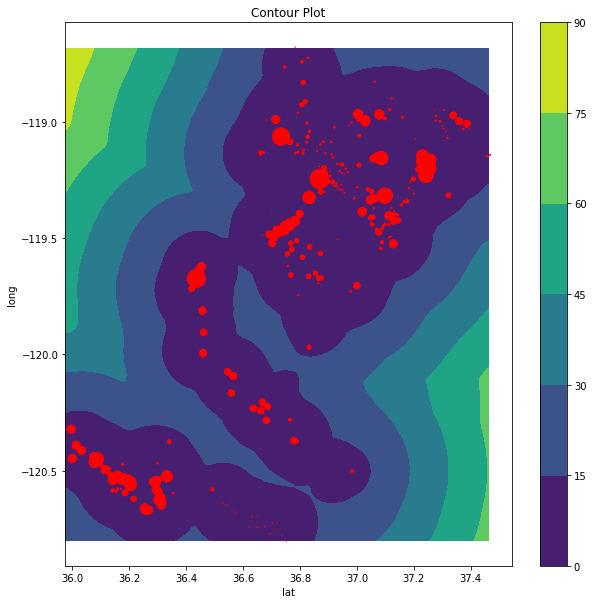

In [178]:
fig, ax = plt.subplots(figsize=(10, 10))

cp = plt.contourf(xv, yv, zv)
plt.colorbar(cp)

plt.scatter(x,y, s = z/100, c = 'r')

ax.set_title('Contour Plot')
ax.set_xlabel('lat')
ax.set_ylabel('long')
plt.show()

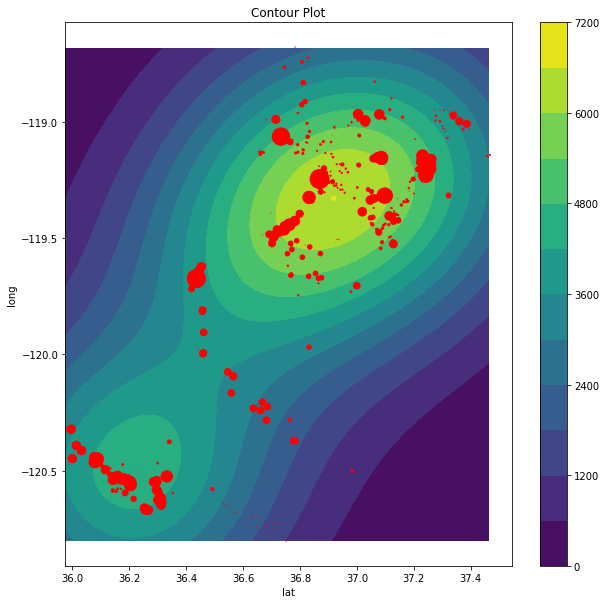

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))

cp = plt.contourf(xv, yv, zv, levels = 10)
plt.colorbar(cp)

plt.scatter(x,y, s = z/100, c = 'r')

ax.set_title('Contour Plot')
ax.set_xlabel('lat')
ax.set_ylabel('long')
plt.show()

In [41]:
water_right_score(36.65,-120.25)

2899.6392391934796

In [42]:
water_right_score(36.65,-120.0)

3589.241359747409

In [47]:
water_df = pd.read_csv("../joined_combined_filtered_mined_soil_water_df_td_6_4.csv")

/home/draget/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,17,21,37,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
water_df.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'geoid', 'sourceagent', 'parcelnumb',
       'usecode', 'improvval', 'landval', 'parval', 'owner',
       ...
       'nirrcalscl', 'castorieindex', 'Crop', 'CropETo', 'WaterApplied',
       'NetWaterUse_Applied', 'Factor', 'AppliedFromETo', 'AppliedWater',
       'TotalWater'],
      dtype='object', length=103)

In [185]:
scores = water_df.apply(lambda x: water_right_n5_score(x["lat"], x["lng"]), axis=1).values

In [190]:
water_df["water_dist"] = water_df.apply(lambda x: water_right_avg_5_dist(x["lat"], x["lng"]), axis=1)

In [170]:
scores2 = water_df.apply(lambda x: water_right_5_score2(x["lat"], x["lng"]), axis=1).values

[ 9.89821002 10.30900934 12.53046831 12.60707995 13.14858311]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.40e+00]
[ 6.69752401  7.09862805  9.21183673  9.27783291 10.20578897]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[4.93633991 5.33499063 5.62512411 9.53579855 9.64022885]
[4.5e+03 4.5e+03 4.5e+03 6.7e+00 2.0e+00]
[0.47138124 0.52502062 0.77375098 2.64043354 2.79840677]
[2100.  300.  380.  200. 2100.]
[ 2.39789864  2.62097705  2.96963733 13.91722726 24.81607902]
[   4.5   600.     15.      2.23 1000.  ]
[ 6.48694765  6.70733364  7.0846446  10.80961574 25.14560192]
[   4.5   600.     15.      2.23 1000.  ]
[ 7.84578749  8.17019118  8.49020101 10.68660789 26.28678693]
[   4.5   600.     15.      2.23 1000.  ]
[2.49191879 2.50933804 3.24929941 3.44848702 4.1455701 ]
[2100.  350.  150. 2100.   25.]
[ 6.25801276  6.88741811  6.98808549 13.66924513 28.05577286]
[   4.5   600.     15.      2.23 1000.  ]
[ 4.026175    4.4628576   4.70164902 13.27592264 25.86760619]
[   4.5   600.     15.     

[1.49137453 1.55674962 1.6710002  1.67429706 2.38056801]
[  25. 2100.   25. 2100. 2100.]
[10.44577011 10.54275018 11.28177701 11.28927628 11.39356927]
[1000. 4500.  800. 4500.  300.]
[14.9866028  18.14934386 18.98163354 19.43852579 19.59011302]
[1000.   10.   25. 1000. 4500.]
[ 4.27261421 16.01336903 17.41646848 17.57022745 17.83731435]
[ 2.23 10.   25.   10.   20.  ]
[1.27227414 1.51958534 2.4399857  2.93757659 3.37175273]
[2100.   25. 2100.   25. 2100.]
[1.44464209 1.75869053 1.90481189 1.9819173  2.19084726]
[  25. 2100.   25. 2100. 2100.]
[1.44568533 1.74859763 1.8711473  1.93720109 2.18957628]
[  25. 2100.   25. 2100. 2100.]
[4.84560187 7.48865097 7.67426968 7.70614424 7.72470136]
[4500. 4500. 4500. 4500.  226.]
[0.83456551 1.41417477 1.8945198  1.95024613 2.30188291]
[2100.   25.   25. 2100. 2100.]
[11.14854498 12.09689002 12.37426952 13.01331601 13.12726717]
[4500. 4500.  250. 4500. 4500.]
[6.91871748 7.16989222 7.43643816 7.83843622 7.87185347]
[1000. 2700.  300. 4500.  800.]
[

[ 6.31349474 15.7859116  16.54770074 16.97862891 17.29201396]
[ 2.23 10.   10.   45.   20.  ]
[12.73032714 12.76019588 15.51805168 16.1635582  18.65175761]
[1500. 1500. 4500. 4500. 4500.]
[2.69172326 3.97284631 4.50682397 4.55522498 4.61105013]
[2100.   25.   25. 2100.  350.]
[0.55388085 1.98118716 2.06523153 2.74044344 3.05878959]
[ 150.   25. 2100. 2100.  350.]
[11.40219913 12.3753396  14.71322624 14.7662392  15.49747896]
[45.   10.   10.   20.    2.23]
[0.42593028 1.07126174 1.86004757 2.18886205 2.23409036]
[  25. 2100.  150. 2100. 2100.]
[1.13656238 1.32495798 1.39984179 1.62629461 1.92569568]
[ 150. 2100. 2100.  350.   25.]
[ 8.49333239  8.57067976 11.95401351 14.25493005 14.48319316]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[0.9777782  2.17314954 2.37856823 3.14214851 3.45923015]
[ 150.   25. 2100. 2100.  350.]
[ 8.4310399  13.24852236 13.30238114 13.38594211 13.66933604]
[2.23e+00 3.00e+02 1.00e+03 2.70e+03 4.50e+03]
[11.24962972 11.34152397 12.18530242 14.36085416 1

[18.93607104 18.97732281 19.0633406  19.71398187 19.96738659]
[ 200. 4500. 4500. 2100.  200.]
[18.44591221 19.62396098 19.64809741 19.71655619 19.87694482]
[ 200. 2100. 4500. 4500.  200.]
[0.62072558 1.28839246 1.66432536 2.32788533 2.54520324]
[2100.   25. 2100.   25. 2100.]
[ 4.28885836 10.44963578 11.09212939 11.12213222 11.19376115]
[5.13e-01 4.00e-02 1.50e+03 2.00e+02 1.50e+03]
[ 5.86641849  5.94792269 16.59557891 18.57199759 22.9022095 ]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[0.64860671 1.31119055 1.91023558 2.281783   2.47043632]
[  25. 2100.  150. 2100. 2100.]
[1.37391675 2.25074911 2.57091423 3.43131345 3.74467116]
[ 150.   25. 2100. 2100.  350.]
[1.29518585 2.04645155 2.37554459 3.25951699 3.57092225]
[ 150.   25. 2100. 2100.  350.]
[ 9.75626328  9.98241332 10.17111512 10.59542104 10.63062636]
[1000. 2700.  300. 4500.  800.]
[11.2894023  11.34877095 13.81191396 16.93563404 17.10180576]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[11.4773197  11.52266983 13.74

[6.88735761 7.01129098 7.02411286 7.45086193 7.48742641]
[1000.  300. 2700. 4500.  800.]
[ 2.25792886  2.30667382 16.24425985 20.12920612 22.00552918]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 6.44183989  6.51510611 21.53545306 21.62623411 21.71245203]
[1.50e+03 1.50e+03 4.50e+03 4.50e+03 5.13e-01]
[ 9.68888458  9.77060802 18.57555231 18.66891517 19.32534668]
[1500. 1500. 4500. 4500. 1000.]
[ 3.31488115  3.31934143 17.64326076 21.26700659 23.42365857]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 9.67956369  9.77251541 18.99165548 19.12582441 19.22320615]
[1500. 1500. 4500. 1000. 4500.]
[1.74986874 1.88630571 1.93747909 3.65306914 3.97973161]
[   5.  100. 2100. 2100.  613.]
[11.1825868  11.276283   17.62030818 17.69652291 18.04187576]
[1500. 1500. 1000. 4500. 4500.]
[1.84620693 1.87450132 1.9246222  3.71122705 4.14495301]
[   5.  100. 2100. 2100.  613.]
[10.93245826 11.02550316 17.87684783 17.87834243 18.19592729]
[1500. 1500. 1000. 4500. 4500.]
[1.62124933 2.01963321 2.07076

[7.50942016 7.62943022 7.64581958 8.06871804 8.10526417]
[1000.  300. 2700. 4500.  800.]
[14.27886883 14.38413701 14.62065992 16.40503998 17.22791782]
[1500. 1500. 1000. 4500. 4500.]
[10.62969188 10.73174365 18.16931425 18.75167349 19.17141352]
[1500. 1500. 1000. 4500. 4500.]
[10.6711861  10.77178125 18.11543881 18.60339298 19.00679541]
[1500. 1500. 1000. 4500. 4500.]
[10.24462211 10.34605477 18.54746025 19.01562469 19.3957031 ]
[1500. 1500. 1000. 4500. 4500.]
[10.84697381 10.93250042 17.59719642 17.80054419 18.10300471]
[1500. 1500. 4500. 4500. 1000.]
[15.39031437 16.4808789  16.73329068 17.11277588 18.42357361]
[ 200. 2100.  200.  300.  200.]
[12.8285216  12.92700356 15.95043207 16.67747843 17.23705736]
[1500. 1500. 1000. 4500. 4500.]
[1.2395723  2.48861552 2.53912755 3.13597761 4.17073688]
[   5.  100. 2100. 2100.  613.]
[1.25076174 2.45007537 2.50076014 3.15483952 4.17431186]
[   5.  100. 2100. 2100.  613.]
[1.41573808 2.30658379 2.35698503 3.31743718 4.01097994]
[   5.  100. 2100.

[ 8.14985177  8.27796277 11.24866379 12.8235154  17.83222741]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 4.83290013  4.84191187 19.09243495 22.29952063 23.38123641]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[12.3452027  12.4354278  16.45723613 16.52060677 16.83503254]
[1500. 1500. 4500. 1000. 4500.]
[10.61161286 12.67460648 13.82958724 15.69228544 15.86016622]
[1000. 4500. 4500. 4500. 4500.]
[ 8.72045835  8.79945493 19.45354626 19.47674928 20.32676735]
[1500. 1500. 4500. 4500. 1000.]
[1.36723858 1.41497031 2.41966157 3.84001373 3.87891639]
[ 100. 2100.    5.  613. 2100.]
[10.46332839 10.54737637 17.90511648 18.06643204 18.51458512]
[1500. 1500. 4500. 4500. 1000.]
[7.59017024 8.52419852 8.95351484 9.20453998 9.56270356]
[10. 10. 20. 25. 45.]
[ 8.37463472  9.83468189 10.20605477 10.32746156 11.5968858 ]
[10.   25.   20.   10.    2.23]
[13.10293061 14.07373994 14.86458958 15.69549632 15.79063024]
[1000. 4500. 4500. 1500. 1500.]
[ 5.52049818  5.5422502  19.95481533 22.54896136 2

[2.12470461 2.30777308 2.58017234 2.79023297 5.55590266]
[ 300.  200.  200. 2100. 2100.]
[10.4174701  10.4730885  17.42865035 17.64921807 19.74381475]
[1500. 1500. 4500. 4500. 1000.]
[10.3696459  10.42364531 17.47241388 17.71312111 19.86980786]
[1500. 1500. 4500. 4500. 1000.]
[ 3.95198299  4.06027765 14.73158981 17.81440997 20.84709689]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 3.93697475  3.94805676 18.40433747 21.92577089 24.17653566]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[ 8.13912005  8.26696826 11.42464021 12.92521957 18.00989346]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 3.70529415  3.73601515 17.37792456 20.67445991 23.28688844]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 5.64672314  5.69411851 20.57004177 22.20344016 22.45397955]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 8.1667153   8.23297602 19.75372101 19.87063123 21.21623651]
[1500. 1500. 4500. 4500. 1000.]
[ 6.02103224  6.05652245 20.69321192 21.90394243 22.22412283]
[1.50e+03 1.50e+03 5.1

[12.64412825 12.65392338 13.32267622 15.64761061 16.41798162]
[4500. 1000. 4500. 4500. 1500.]
[13.54750601 13.70209882 14.32634477 15.40175694 15.49082136]
[1000. 4500. 4500. 1500. 1500.]
[1.98836184 1.99205584 2.71269291 3.00716306 3.05784036]
[2100.   50.  613. 2100.  100.]
[13.51473031 13.73332042 14.06145832 15.33734217 15.4233727 ]
[4500. 1000. 4500. 1500. 1500.]
[11.59864345 11.64771641 16.25200888 16.57442947 19.23206106]
[1500. 1500. 4500. 4500. 1000.]
[3.9168924  4.62694895 4.77393431 4.77518328 7.47698803]
[ 200. 2100.  200.  300. 2100.]
[14.24942264 14.33633304 14.54533029 14.74829445 15.0138509 ]
[1500. 1500. 4500. 1000. 4500.]
[2.32671937 2.45248541 2.46943088 2.79765    3.49990022]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 3.8e+02]
[1.32885832 1.61145431 1.86375348 3.76074849 5.55524875]
[ 300.  200. 2100.  200. 2100.]
[4.13853816 4.19689549 4.31705526 4.39385007 8.10627653]
[2100.  200.  200.  300.  300.]
[3.72740518 3.91727514 4.0254806  4.17373783 8.26898136]
[2100.  200.  300.

[11.13798167 11.17689944 16.82617591 17.27348318 19.88660274]
[1500. 1500. 4500. 4500. 4500.]
[11.05808731 11.08154885 17.29927949 17.9228383  20.42950989]
[1500. 1500. 4500. 4500. 4500.]
[11.18589768 11.2112975  17.11679094 17.72674982 20.24179668]
[1500. 1500. 4500. 4500. 4500.]
[8.30746166 8.63477893 8.66272656 8.67438296 8.72822839]
[ 300. 4500.  800. 2700. 1000.]
[ 9.51552471  9.63285365 14.07457861 14.22637992 20.8803186 ]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 4.00e-02]
[2.03644234 2.19200081 2.2070774  2.22487452 2.25744664]
[4.500e+03 8.059e+03 3.750e+00 1.750e+02 4.500e+03]
[ 9.19185923  9.27087596 10.40788777 12.29453958 12.77353393]
[1000. 4500. 4500. 4500. 4500.]
[1.37305335 1.69989656 1.77040378 2.02054301 6.57277009]
[ 300.  200. 2100.  200.  300.]
[11.17447899 13.06868794 13.19195401 13.76258189 17.89198532]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[1.97530589 2.04882533 2.10649012 2.25912486 6.84033793]
[ 300. 2100.  200.  200.  300.]
[11.21975658 13.03251173 13.15

[2.02494053 2.14233828 2.3003054  2.57025249 2.59266408]
[2100.  200.  613.  100. 2100.]
[13.80793472 13.86445684 13.89829032 14.47973758 14.68333493]
[7000. 3000. 3500. 3500. 3500.]
[12.95210281 13.40961305 14.13274922 15.94748434 16.03831582]
[1000. 4500. 4500. 1500. 1500.]
[0.46376175 0.5045699  0.56895077 1.9281648  2.19533904]
[ 380.  300. 2100.  200. 2100.]
[0.49627078 0.51929209 2.4288297  2.44675282 2.44938607]
[ 100. 2100.  613. 2100.   50.]
[14.09930324 14.17239174 14.20593583 14.77910535 14.98559664]
[7000. 3000. 3500. 3500. 3500.]
[ 9.55280816 14.41778852 15.11901957 16.96877003 17.061084  ]
[ 2.23 10.   25.   20.   10.  ]
[12.79258865 13.05829224 13.08740177 13.55152357 13.79098581]
[7000. 3000. 3500. 3500. 3500.]
[ 8.18974088  8.28500356 16.50788423 17.14709686 23.04769562]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[10.98120139 11.02450684 16.91695455 17.30357654 19.95096915]
[1500. 1500. 4500. 4500. 4500.]
[14.11791665 14.23637852 14.26897568 14.81766585 15.03209541

[ 9.1597182   9.17307746 19.36331179 19.96301946 22.4271503 ]
[1500. 1500. 4500. 4500.  226.]
[ 8.14531479  8.19020444 19.74424269 21.02201768 22.7700572 ]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[1.8940219  1.98382009 2.03470291 2.24749952 6.83864556]
[ 300. 2100.  200.  200.  300.]
[11.7467055  11.8178626  14.31898108 14.58550487 16.07024192]
[4500. 4500. 1000. 4500. 4500.]
[ 8.996433    9.095522   16.45689014 16.6113888  23.05244663]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 9.3900052   9.48986724 16.45426649 16.53247124 23.14804743]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 4.00e-02]
[12.26051662 12.31631105 15.5884917  15.8136479  18.28045972]
[1500. 1500. 4500. 4500. 1000.]
[ 9.5603961   9.66323006 16.07024686 16.27114369 22.90039885]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 4.00e-02]
[11.73355105 11.77856734 16.15014986 16.53435185 19.18102199]
[1500. 1500. 4500. 4500. 4500.]
[11.97266352 12.00855414 16.07170546 16.59306298 19.16069637]
[1500. 1500. 4500. 4500. 4500.]
[0.98

[ 7.34693533  7.44267824 16.1664115  17.28135285 22.64784421]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[2.89122589 3.016123   3.45093345 5.35022558 6.66928532]
[2100.  200.  300.  200.  200.]
[ 6.33263334  6.37380361 18.70500103 20.78509944 23.59656069]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[ 6.72996788  6.76960291 19.02733916 20.95910401 23.29303345]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[ 7.97369419  8.04271599 18.31568952 19.32504691 24.38115696]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[10.35694257 10.39532132 17.60281998 18.02885231 20.65596053]
[1500. 1500. 4500. 4500. 4500.]
[10.97517565 11.92217001 12.04765158 12.61084751 18.12921499]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[10.60435981 10.63868043 17.43582895 17.91686093 20.51187062]
[1500. 1500. 4500. 4500. 4500.]
[ 7.81453269  7.88792553 17.9583347  18.99331095 24.4039331 ]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[0.49462927 0.57634332 0.8399307  4.17432687 6.39099262]
[ 200. 2100.

[13.44605408 15.87835414 15.99235088 17.54178621 18.8684147 ]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[11.44955037 11.46714965 17.16164511 17.87264156 20.32071331]
[1500. 1500. 4500. 4500. 4500.]
[11.91205942 13.13579557 13.25657075 14.54343155 18.47662203]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[1.94982418 2.03559824 2.07478518 2.23865578 2.38275283]
[ 380. 2100.  300. 2100.  613.]
[2.23109038 2.2536121  2.32432585 2.3503358  2.38813185]
[ 613.  380. 2100. 2100.  300.]
[11.42239343 12.30970349 14.61602062 15.26924668 16.42467221]
[4500. 4500. 4500. 4500.  226.]
[11.7044128  13.18093089 13.30237091 14.37284372 18.28733083]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[2.64147495 2.68616695 2.69834985 3.37298117 3.40522817]
[2100.  380.  300.  613. 2100.]
[0.51341352 0.5546116  0.57760459 0.59879226 0.91875807]
[4500.  175.  175. 4500. 5000.]
[12.16921714 16.83778771 17.05709187 17.50772699 17.57457742]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[ 9.06610619  9.0673

[15.26206221 15.27512903 16.123075   16.2404158  16.31665465]
[1500. 1500.  226. 4500. 4500.]
[15.30532788 15.40870958 15.48339287 15.59285872 16.13761064]
[ 226. 4500. 4500. 4500. 1500.]
[14.08854054 16.44106473 16.55279891 18.35558651 19.27243141]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[6.76872483 8.17980643 8.21199721 8.49439731 8.61197378]
[ 200. 2100.  300.  380. 2100.]
[1.83572275 2.52986057 2.78644829 2.85764355 3.06950962]
[5.000e+03 3.059e+03 2.674e+00 1.750e+02 4.500e+03]
[5.51354233 6.08521336 6.2599616  6.31740251 8.62498633]
[ 200. 2100.  200.  300. 2100.]
[15.38840031 15.40113485 15.99520942 16.11323574 16.18955179]
[1500. 1500.  226. 4500. 4500.]
[11.97499168 13.95055084 14.19640335 14.61029034 16.39071145]
[ 200. 2100.  200.  300.  200.]
[12.0123402  13.97477093 14.22075484 14.63423451 16.40869702]
[ 200. 2100.  200.  300.  200.]
[14.21500006 18.0751411  18.30801124 18.7469281  19.60369124]
[ 200. 2100.  200.  300. 1500.]
[6.23815271 6.42560608 6.46748951 6.7383

[13.41822475 16.73321145 16.84755098 17.97516309 18.51017696]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[10.92886829 16.05120911 16.14142651 16.34965371 16.80474289]
[2.00e+02 5.13e-01 2.10e+03 2.00e+02 3.00e+02]
[10.7900864  11.79024888 14.00754465 14.56763624 15.68938474]
[4500. 4500. 4500. 4500.  226.]
[11.73599447 12.50728681 14.89834211 15.65586087 16.44467089]
[4500. 4500. 4500. 4500. 1500.]
[4.57219422 5.2425032  5.39384255 5.57405662 6.65786694]
[4500. 4500. 1000. 1000. 4500.]
[12.96326818 12.96696678 16.6298396  17.60560817 18.54066068]
[1500. 1500. 4500. 4500.  226.]
[2.77364134 2.83019077 3.0557315  4.82020748 4.8844302 ]
[2100.  300.  380.  200. 2100.]
[12.40740883 15.44529194 15.56296517 16.4396717  18.07246307]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[2.17622716 2.56698684 2.58937857 2.67361372 2.68716702]
[4500. 5000. 3059. 3059. 4500.]
[13.60896903 13.71159698 15.78696075 18.24776293 21.86658444]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[12.90428149 15

[11.7922452  11.85888344 20.23362448 20.87005634 21.49972455]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[11.77685135 11.84160161 20.42213333 21.00494877 21.38114293]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[0.16467597 0.25744785 0.85788612 0.93309816 0.96376218]
[ 175. 4500. 4500. 4500.  175.]
[0.43425543 0.51919265 0.62610901 0.72470201 0.84609389]
[ 175. 4500. 4500.  175.  175.]
[11.74970703 11.79797385 20.4752735  20.54332134 20.61335492]
[1500. 1500.  226. 4500. 4500.]
[12.15283285 12.20194693 20.16013837 20.22393413 20.29337953]
[1500. 1500.  226. 4500. 4500.]
[13.46392762 13.57511878 14.15258956 16.78987816 20.35647618]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[12.56628133 13.93020566 14.04791201 15.66959681 18.76807206]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[11.36807598 11.46177917 17.0603073  18.1343015  23.69559808]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[12.1415548  12.20040727 20.71049485 20.76044019 20.82786661]
[1500. 1500.  226. 4500. 45

[17.19414253 18.13845306 18.39158222 18.76021006 19.92299845]
[ 200. 2100.  200.  300.  200.]
[10.59092491 10.83269256 14.17130309 14.25012385 14.25784123]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 1.434e+03]
[12.37745676 12.49245994 13.51797327 15.57201482 20.1094675 ]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[0.50766953 0.53011187 0.57608118 0.57865011 0.68861846]
[1887. 4500. 4500. 4500.  175.]
[13.57270393 13.68531563 14.35021995 14.4113817  16.27166949]
[4500. 4500. 1500. 1500. 1000.]
[ 8.73499356  8.75151802 20.90940953 21.45482006 21.66815936]
[1.50e+03 1.50e+03 4.50e+03 5.13e-01 4.50e+03]
[13.0407888  13.49721463 14.84341593 14.88983186 16.09287108]
[4500. 4500. 1500. 1500. 4500.]
[10.11162402 10.51149238 13.12276884 14.25089828 14.98154868]
[4500. 4500. 4500. 4500. 1000.]
[11.33247727 11.42451976 17.27213121 18.29350344 23.91144497]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[1.69743533 1.75916361 1.81062936 3.07924882 3.11691467]
[2100.  300.  380. 2100.  200.]
[2.87

[1.31446519 1.56492525 1.96956061 4.58731643 7.6717222 ]
[2100.  200.  300.  200.  200.]
[1.27823618 1.52955576 1.93016902 4.53787291 7.7146735 ]
[2100.  200.  300.  200.  200.]
[1.22563822 1.47802648 1.87198322 4.46370818 7.77925044]
[2100.  200.  300.  200.  200.]
[0.98211859 1.23383457 1.5889792  4.12046096 7.77195325]
[2100.  200.  300.  200. 2100.]
[12.20513116 12.29669192 15.07154161 15.22249866 15.73893988]
[4500. 4500. 4500. 1000. 1500.]
[12.38943016 12.50213735 15.26864246 15.43307043 15.53669744]
[4500. 4500. 4500. 1000. 1500.]
[0.89746616 0.95023912 1.35362303 1.43853865 1.46816077]
[4500.  175. 4500. 8059. 4500.]
[2.03280469 2.05928004 2.24126684 2.57693417 3.72818184]
[ 300. 2100.  380.  200.  200.]
[1.85400194 2.10736643 2.48222298 4.78897712 7.79129174]
[2100.  200.  300.  200.  200.]
[1.73141569 1.9384789  1.94515922 2.03643251 6.64397525]
[ 300. 2100.  200.  200.  300.]
[1.77186927 1.96640943 1.9958696  1.99692165 6.57396343]
[ 300.  200. 2100.  200.  300.]
[2.4987302 

[13.39953299 14.14595014 14.2602522  16.53165584 19.44281455]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[13.61597017 13.99494653 14.10838448 16.63101918 19.69145479]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[11.10086918 11.59769433 14.16066423 15.18425664 16.00542273]
[4500. 4500. 4500. 4500. 1000.]
[5.05437793 5.87847078 6.96972127 7.21156757 8.27591001]
[4500. 4500. 4500. 4500. 4500.]
[11.38322766 11.90577113 14.4551677  15.45010095 16.30180588]
[4500. 4500. 4500. 4500. 1000.]
[11.13621178 11.6244777  14.19261591 15.22298896 15.99893065]
[4500. 4500. 4500. 4500. 1000.]
[11.76968563 11.85001452 18.73537613 19.7010214  22.62005137]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[ 9.83502277  9.91485511 18.54666503 18.5931222  23.84057418]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[12.24513302 12.24662146 17.32187428 18.25338763 19.21539199]
[1500. 1500. 4500. 4500.  226.]
[11.45895008 12.10121947 14.57718755 15.46219346 16.53494527]
[4500. 4500. 4500. 4500. 1500.]
[12.7

[3.22489939 3.56353928 5.35477831 5.40177634 6.34355744]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[12.04407399 12.28510164 12.65070963 13.01027429 13.17416627]
[5.000e+03 2.000e+02 2.674e+00 3.059e+03 1.750e+02]
[3.30107949 3.63504769 5.39160054 5.43440223 6.37861072]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[11.76744855 12.35118177 12.36798796 12.72002833 12.87708745]
[5.000e+03 2.674e+00 2.000e+02 3.059e+03 1.750e+02]
[ 7.65616826  7.76439684 13.90513401 13.9338254  13.94820754]
[3.40e+00 1.40e+00 2.00e+00 4.50e+03 1.75e+02]
[10.50476483 10.55145653 13.00779349 16.32605541 16.52951625]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[16.18199547 19.45867773 19.56516587 20.22240735 20.45536315]
[ 200. 1500. 1500. 2100.  200.]
[14.29742678 18.10879211 18.34231112 18.7804094  19.7175958 ]
[ 200. 2100.  200.  300. 1500.]
[14.21978377 17.99711756 18.2309169  18.66865261 19.7827808 ]
[ 200. 2100.  200.  300. 1500.]
[ 5.97576738  6.02489463 11.12316905 11.31588616 11.5995724

[6.86267585 7.24859809 9.20069582 9.24472224 9.68853466]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.40e+00]
[ 8.15636163  8.17327445 11.47478187 11.74065707 12.56100783]
[  3.4    1.4    2.     5.23 175.  ]
[ 9.46075197  9.65482295 11.14489389 11.27184283 11.61818472]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[ 9.06100728  9.42158514  9.80461653  9.87628385 11.10033781]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[14.38745428 14.88531383 14.98838014 15.2880372  15.41804864]
[5.000e+03 2.674e+00 2.000e+02 3.059e+03 1.750e+02]
[14.14989847 14.63641104 14.93480786 15.04295377 15.16962632]
[5.000e+03 2.674e+00 2.000e+02 3.059e+03 1.750e+02]
[2.77349401 4.81864765 6.99267968 7.34953066 7.4263652 ]
[4500. 4500. 4500. 1000. 4500.]
[14.42714654 16.81329046 16.92390797 18.8130261  19.46314066]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[13.62328296 17.48381265 17.59779659 18.40386887 18.52408751]
[2.00e+02 1.50e+03 1.50e+03 2.10e+03 5.13e-01]
[6.86594161 7.25035392 9.18822785 9.230

[2.34159574 2.35815596 2.65077402 5.40736167 5.98844352]
[ 200. 2100.  300. 2100.  200.]
[12.43095924 12.469774   19.46649054 19.54413505 19.61549371]
[1500. 1500.  226. 4500. 4500.]
[3.36443395 4.0852013  4.14950602 4.26758351 4.28173594]
[5000. 2100.  300. 3059.  380.]
[14.43944143 14.59678716 14.70648633 17.66244832 20.26327059]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[4.8766908  5.04395622 5.22632172 5.30693195 8.45941923]
[ 200. 2100.  200.  300. 2100.]
[13.51654885 15.62565582 15.7393457  17.46206954 19.02929044]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[13.08466034 13.16073231 19.53636685 20.95276787 21.39029132]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[1.04295836 1.22626253 7.09542137 7.19066067 7.22065721]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 1.750e+02]
[3.982311   4.0382931  4.26563067 4.8649237  5.87962271]
[2100.  300.  380. 5000. 3059.]
[14.04765282 16.30608455 16.41791637 18.25298785 19.28367361]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[14.0

[14.27503254 14.28396475 14.53737429 14.8920396  15.97463227]
[ 200. 2100.  200.  300.  200.]
[15.94118249 19.43491649 19.6735066  20.10397065 20.679107  ]
[ 200. 2100.  200.  300. 1500.]
[0.81193188 3.19491845 3.52404817 3.60383761 3.62254859]
[4500. 4500. 4500. 4500. 1000.]
[0.81193188 3.19491845 3.52404817 3.60383761 3.62254859]
[4500. 4500. 4500. 4500. 1000.]
[4.76273885 5.29961637 5.67493407 5.82577983 6.91870821]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[4.1568169  4.5952539  5.00100192 5.12739352 6.10710129]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[13.5525997  14.63096248 14.8825373  15.26989746 16.70492227]
[ 200. 2100.  200.  300.  200.]
[19.31963164 21.34994417 21.37945754 21.47612257 21.54719115]
[ 200.  250. 1500. 1500. 4500.]
[ 7.71611386  8.01804555 10.50727912 10.54689946 10.71586176]
[2.000e+00 5.230e+00 4.500e+03 2.674e+00 1.750e+02]
[ 7.51790403  7.84494377 10.37682025 10.5755493  10.60163195]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]


[17.5491717  17.78968611 18.03904795 18.06315059 19.38673528]
[2100.  200.  300.  200. 4500.]
[16.81609828 16.83061427 17.04338958 17.23891086 18.09439898]
[2100.  200.  200.  300. 5000.]
[2.73173311 2.94237236 4.1714453  4.17963345 5.13457918]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[3.56095248 3.7654799  4.76635397 4.78978097 5.71782368]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[3.65004548 3.84060131 4.743466   4.77531672 5.69179372]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[4.13370148 4.32618295 5.14608885 5.19085809 5.86436513]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.40e+00]
[3.89853141 4.08531857 4.91555927 4.95636869 5.85929522]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[3.94822609 4.13423651 4.9502334  4.9927833  5.89293738]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[3.99882324 4.18423147 4.98697196 5.03119309 5.8822794 ]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.40e+00]
[4.44613049 4.61923025 5.26801143 5.32927376 5.50180553]
[2.00e+00 5.23e+00 1.75e+02

[14.36068214 14.57106801 14.78918682 14.95421695 15.75819767]
[ 200. 2100.  200.  300. 5000.]
[14.33242726 14.56207172 14.77952527 14.94240061 15.69065379]
[ 200. 2100.  200.  300. 5000.]
[3.42298311 3.7260841  6.24278122 6.44338121 6.65286438]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[ 7.4615731   7.5226191  12.39389488 12.61298504 13.05335314]
[  3.4    1.4    2.     5.23 175.  ]
[12.62617662 12.72496697 12.98102637 13.18049253 13.66348699]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[16.5598846  18.00539299 18.11987852 18.31157316 18.56461258]
[4500. 4500. 4500.  250. 4500.]
[5.46675869 6.2017252  6.49336282 6.69878018 7.79996476]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[13.04351098 13.29350509 13.72780435 14.75047767 14.7871717 ]
[2.00e+00 5.23e+00 7.00e+03 3.50e+03 3.00e+03]
[1.81547798 1.97104953 3.55133888 3.57475563 3.66046425]
[4500. 4500. 4500. 4500. 1000.]
[1.65346525 1.7976861  3.25209367 3.8525453  3.9335946 ]
[4500. 4500. 4500. 4500. 1000.]


[ 7.57047625  7.86612122 10.34371707 10.34964497 10.55428264]
[2.000e+00 5.230e+00 4.500e+03 2.674e+00 1.750e+02]
[17.45925978 17.65433153 17.87574462 18.02208107 18.05036042]
[ 200. 2100.  200. 5000.  300.]
[ 9.14330752  9.25784637 15.31036597 15.45848056 15.47293557]
[3.40e+00 1.40e+00 2.00e+00 4.50e+03 1.75e+02]
[5.78722986 6.19436716 8.40016069 8.48214495 9.39367673]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[10.52347583 10.58310252 10.62425106 10.67676064 10.80238204]
[ 250. 4500. 4500.  226. 4500.]
[10.45598043 10.50153656 10.54300313 10.59383657 10.73489746]
[ 250. 4500. 4500.  226. 4500.]
[6.63968101 6.99572017 8.55308469 8.66461393 8.70092963]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[ 7.59285318  7.88693955 10.35588915 10.36133045 10.57243429]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 1.750e+02]
[11.3432523  11.83772831 12.23977575 12.37025055 12.54578441]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[12.56016345 13.10810005 13.22738961 13.49152227 13.6374275

[16.00518544 16.25207817 17.42221294 17.46780775 17.58968194]
[4500. 4500. 3000. 3500.  181.]
[5.38744388 5.40675015 9.08746141 9.29355058 9.75186931]
[  1.4    3.4    2.     5.23 175.  ]
[16.45901393 16.72251766 17.14139643 17.18585482 17.43759129]
[4500. 4500. 3000. 3500.  181.]
[ 9.97103405 10.19921818 10.29569571 10.40215723 13.29186993]
[2100.  200.  200.  300. 2100.]
[14.75805941 14.90010925 18.03475581 19.21037247 19.22277381]
[4.500e+03 4.500e+03 4.500e+03 1.434e+03 1.739e+00]
[15.47388316 15.70698098 17.54267268 17.58867427 17.58926244]
[4500. 4500. 3000.  181. 3500.]
[13.74966005 14.6961732  14.94824419 15.33138376 16.71611919]
[ 200. 2100.  200.  300.  200.]
[4.70123737 4.81258783 6.24350423 6.54115242 6.68497222]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[5.04304912 5.13709104 6.36238311 6.59769482 6.82042667]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[4.90644722 5.09365419 7.01946529 7.34367772 7.39987043]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 5.000e

[7.31571683 8.4284191  8.5931068  8.62027761 9.45166524]
[ 200. 2100.  200.  300. 2100.]
[2.56437885 3.28544854 3.57041474 3.77620371 4.89265355]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[13.69776875 17.24390827 17.47949752 17.91477467 19.89651823]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[ 7.77099386  8.16874714 10.70749174 10.85830252 11.60649175]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[4.64950196 5.25198661 5.60161665 5.77071707 6.95841165]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[ 7.43841416  7.45932686  9.83597782 10.10898977 11.03366461]
[  1.4    3.4    2.     5.23 175.  ]
[6.55276476 7.35966176 7.39707148 7.67456911 7.79754354]
[ 200. 2100.  300.  380. 5000.]
[0.2828055  0.55716778 0.59255079 1.49149325 1.54449347]
[1.750e+02 2.674e+00 3.059e+03 4.500e+03 4.500e+03]
[4.88173679 5.02126831 5.7358888  6.01451999 8.40469288]
[1000. 4500. 4500. 4500. 4500.]
[1.55188804 3.74416107 5.75357947 6.63164331 6.84743544]
[4500. 4500. 4500. 4500. 10

[18.37417089 18.62505536 18.92499527 18.93523785 18.93752459]
[2100.  200.  200. 4500.  300.]
[15.56233269 15.81495333 15.94239969 16.14772893 16.97978528]
[2100.  200.  200.  300.  200.]
[17.48211074 17.52016898 17.61392622 18.1781331  18.20569223]
[3000. 3500. 7000.  200. 3500.]
[14.65621531 14.74876372 15.00217482 15.35709997 16.43200572]
[ 200. 2100.  200.  300.  200.]
[12.90054367 13.04327499 16.41833357 17.54997946 17.55215894]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[18.57931542 18.83083748 18.84871265 18.95907805 19.00032719]
[2100.  200. 4500.  200. 4500.]
[1.9196059  3.12631079 5.63905548 5.83948078 5.89921307]
[4500. 4500. 4500. 1000. 4500.]
[16.48433881 16.73382607 17.03507486 17.50513761 17.54489397]
[2100.  200.  300.  200.  200.]
[5.91532396 5.95610292 8.64058798 8.8740578  9.55063563]
[  1.4    3.4    2.     5.23 175.  ]
[2.43622335 2.84843726 5.33269926 5.47472065 6.2872877 ]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[2.62694369 2.98534594 5.55234042 5

[3.97685456 4.18074823 5.0966262  5.13224951 6.04291597]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[4.02669158 4.22953602 5.13022923 5.16763381 6.0199336 ]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.40e+00]
[ 8.77814083  9.33139273  9.70950498  9.85921244 10.44029182]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[3.40939349 3.62329938 4.70900627 4.72392611 5.66273369]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[ 8.102224    8.24956599 14.68450462 14.70203534 14.84090413]
[3.400e+00 1.400e+00 4.500e+03 1.750e+02 1.887e+03]
[7.06923524 7.46859295 7.89586058 8.00323713 8.25265406]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[ 7.19355216  8.76570115 10.44557997 10.58056952 12.81850212]
[4500. 4500. 4500. 4500.  226.]
[ 8.56118174  9.41143954  9.59310734  9.65973374 10.71667952]
[ 200. 2100.  200.  300. 2100.]
[14.3964597  17.73771017 17.84910944 19.06857981 19.25044471]
[2.00e+02 1.50e+03 1.50e+03 2.10e+03 5.13e-01]
[13.53679939 14.70501903 14.87326922 14.90005735 14.95

[13.76962275 18.20421454 18.244119   18.3181716  18.4687072 ]
[ 200. 1500. 2100. 1500.  200.]
[14.3981902  17.86706055 17.97855757 19.01762725 19.24101102]
[ 200. 1500. 1500. 2100.  200.]
[3.86860727 3.93469483 5.2967132  5.65368851 5.7258434 ]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[3.93683489 3.9986727  5.3087936  5.65136102 5.74230653]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[3.47575075 3.8846548  6.38551083 6.5284551  7.33701229]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 8.37383234  8.42717706 12.79230135 13.03502662 13.64415591]
[  3.4    1.4    2.     5.23 175.  ]
[ 8.5883848   8.64667582 13.10243074 13.34489494 13.94511214]
[  3.4    1.4    2.     5.23 175.  ]
[14.87961312 15.15567886 15.45412051 15.660025   15.71560789]
[2.000e+02 5.000e+03 2.100e+03 2.000e+02 2.674e+00]
[0.81198662 1.60948328 1.82102688 2.0537954  3.1308495 ]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[2.53378667 2.88892423 4.42247153 4.4861233  5.49886639]
[4500. 4500.

[7.00287207 7.73409348 7.74930024 7.91323627 8.2211201 ]
[7000. 3000. 3500. 3500. 3500.]
[4.69038827 5.82228952 8.14336611 8.58245193 8.97087067]
[4500. 4500. 4500. 4500.  226.]
[10.98709858 11.28376688 13.62346056 13.75275104 13.95680093]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 5.000e+03]
[16.19429881 17.4734927  17.72570888 18.10715823 19.42537036]
[ 200. 2100.  200.  300.  200.]
[10.61835393 11.49656097 11.64459302 15.24866268 15.39562557]
[4500. 4500. 4500. 4500.  315.]
[11.21034877 11.25602548 11.3095064  16.32403862 16.45602019]
[4500. 4500. 4500. 4500.  315.]
[15.42307019 19.25970815 19.49422481 19.80991385 19.91974984]
[ 200. 2100.  200. 1500. 1500.]
[10.90522341 11.19726471 11.31662009 15.85082614 15.98638746]
[4500. 4500. 4500. 4500.  315.]
[7.12840871 7.28607722 8.54249025 8.70017227 8.89081289]
[ 250. 4500. 4500. 4500.  315.]
[12.32846689 13.40738539 13.7386397  13.74327917 13.79549782]
[7000. 3500. 3500. 3000. 3500.]
[11.82574417 12.89763027 13.16684041 13.16880654 13.279

[13.01828492 13.06261667 13.39750439 13.42784246 13.42784246]
[3000. 3500.  181. 4500.  500.]
[14.52424788 14.56934937 14.6913388  14.79128879 14.81919315]
[3000. 3500. 4500.  181.  500.]
[13.9020507  13.94704685 14.19236257 14.22087507 14.22087507]
[3000. 3500.  181. 4500.  500.]
[ 8.55045291  8.73730142 13.24825539 13.34097329 13.41818543]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 4.500e+03]
[ 8.59672707  8.78667961 13.25167487 13.33818131 13.49437324]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 4.500e+03]
[ 9.54131999 10.58423875 10.71961786 10.7228633  10.94901413]
[7000. 3500. 3000. 3500. 3500.]
[5.77850087 6.08371766 7.34250074 8.69259383 9.90939948]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[13.82079007 13.86594304 14.09551245 14.12378583 14.12378583]
[3000. 3500.  181.  500. 4500.]
[14.16810638 14.21351907 14.3641363  14.40707696 14.43461292]
[3000. 3500. 4500.  181.  500.]
[14.43341622 14.46406594 16.6861509  17.0233877  18.3638337 ]
[  3.4    1.4    2.     5.23 175.  ]


[1.87758734 2.93311848 2.95259235 3.25553909 3.99056664]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[4.00879936 4.10282658 7.18669572 7.33691435 7.52188865]
[  1.4    3.4    2.     5.23 175.  ]
[4.04217544 4.14236775 7.03663384 7.18685206 7.38371706]
[  1.4    3.4    2.     5.23 175.  ]
[4.00050183 4.09906687 7.08580155 7.2343348  7.41592037]
[  1.4    3.4    2.     5.23 175.  ]
[2.98264808 3.01071157 8.23037169 8.24227554 8.44839555]
[1.40e+00 3.40e+00 4.50e+03 1.75e+02 1.75e+02]
[14.12492757 14.82480505 15.07759895 15.45248535 16.74115015]
[ 200. 2100.  200.  300.  200.]
[7.48573445 8.23986651 8.42093567 8.48810876 9.94744898]
[ 200. 2100.  200.  300. 2100.]
[15.4621245  19.40509557 19.57137167 19.63845552 19.68076024]
[ 200. 2100. 1500.  200. 1500.]
[10.48387133 10.51829306 11.76519099 16.96822074 17.25263134]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[12.45435324 14.32526497 14.33972983 14.55287281 14.58869398]
[4500.  250. 4500. 4500.  315.]
[12.1394714  12.1782

[15.79727026 16.6818353  16.93478442 17.30702227 18.5324164 ]
[ 200. 2100.  200.  300.  200.]
[15.76827747 16.50390087 16.75705805 17.1252318  18.3084912 ]
[ 200. 2100.  200.  300.  200.]
[13.73843005 13.98374105 14.25894324 14.59937703 15.69337802]
[2100.  200.  300.  200.  200.]
[13.45397752 14.55968986 14.81111495 15.19961895 16.64946068]
[ 200. 2100.  200.  300.  200.]
[15.05312163 17.4028514  17.64967818 18.06023198 19.74349343]
[ 200. 2100.  200.  300.  200.]
[1.54764152 1.76729562 3.00335884 3.03987347 3.24410796]
[5.230e+00 2.000e+00 4.500e+03 2.674e+00 1.750e+02]
[14.26447118 15.56928075 15.82054066 16.21013768 17.6544636 ]
[ 200. 2100.  200.  300.  200.]
[14.2758287  15.37426987 15.62618774 16.01063637 17.39777106]
[ 200. 2100.  200.  300.  200.]
[14.00183001 14.61726439 14.87016587 15.24344936 16.51851525]
[ 200. 2100.  200.  300.  200.]
[11.00776581 11.39477168 13.95398424 14.11531455 14.65339815]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[10.98579907 11.37467235 

[11.33231023 11.33742407 11.55782833 11.73255514 13.93937377]
[ 200. 2100.  200.  300. 2100.]
[18.2928564  18.54415508 18.75583201 18.86058874 19.0792065 ]
[2100.  200.  200.  300. 4500.]
[14.27958527 14.67455444 14.92781307 15.2935717  16.48515069]
[ 200. 2100.  200.  300.  200.]
[14.33284358 14.71594252 14.96922086 15.33435576 16.5183309 ]
[ 200. 2100.  200.  300.  200.]
[ 5.5532038   7.61923262  8.324554    8.66343296 11.3736912 ]
[4500. 4500. 4500. 4500.  226.]
[ 4.76863128  4.88121018 11.15385842 11.16972375 11.53677648]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 4.50e+03]
[16.49843191 19.56298274 19.8058769  20.22754262 21.75352769]
[ 200. 2100.  200.  300. 1500.]
[3.51627993 3.63123607 4.14202632 4.19822911 5.07696382]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[3.65936758 3.774733   4.24912882 4.31060795 5.17970926]
[2.00e+00 5.23e+00 1.75e+02 4.50e+03 1.75e+02]
[10.74615666 10.81814122 11.00262569 12.44305705 12.72117583]
[10. 10. 20. 10. 10.]
[10.4727211  11.49247042 11.5161664

[13.83868893 13.9704546  14.52592319 14.67662376 15.16955942]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[3.76722249 3.92454691 4.09545096 4.14322951 4.26494714]
[ 226. 4500. 4500. 4500. 4500.]
[ 8.21250748  8.61760708 11.12750274 11.26719489 12.07907039]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[12.51105282 12.51139188 13.87436039 14.22035693 15.67689822]
[  1.4    3.4    2.     5.23 175.  ]
[11.49873913 13.67272815 13.86209418 14.81464266 15.0142225 ]
[4500. 4500. 4500. 4500.  315.]
[11.5155195  13.34528395 13.52018848 15.12346524 15.31319901]
[4500. 4500. 4500. 4500.  315.]
[15.44474531 15.74670993 15.77549829 16.1094428  16.20679423]
[7.00e+03 3.00e+03 3.50e+03 2.00e+00 5.23e+00]
[10.57651166 10.96242147 11.86537237 11.93156396 12.85326019]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[10.95631483 11.34734698 12.41000005 12.47612475 13.28874601]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[6.19339128 6.23461293 6.6663093  7.04478868 7.14057131]
[3000. 3500. 7000

[ 7.42592352  7.82634449 10.35702018 10.50467685 11.29745993]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[14.9650122  15.06304414 15.15845474 15.41529327 15.88708026]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[14.47212427 15.59706773 15.84209295 16.51130282 16.76506252]
[4500.  250. 4500. 4500.  315.]
[3.436682   3.55352213 4.57774893 5.41403564 6.36792915]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[5.20234505 5.50465689 7.28321684 8.36642601 9.53364604]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[4.3670366  4.45137839 5.71380726 6.85124541 7.86974717]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[4.48948756 4.51790381 4.64244398 5.76961159 6.79036702]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[4.14714401 4.45428512 4.53985786 5.23154668 6.24709557]
[2.000e+00 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[3.68428455 4.60378339 4.73345353 4.75471487 5.77096687]
[2.000e+00 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[3.06695891 4.09631032 4.8391

[ 8.01263308  8.10010264  9.38426289 15.01279754 15.13409299]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[13.36190123 13.40806612 13.52957643 13.55616394 13.55616394]
[3000. 3500.  181.  500. 4500.]
[12.55991373 12.60605404 12.74893517 12.77622494 12.77622494]
[3000. 3500.  181. 4500.  500.]
[13.36689261 13.65123402 14.77677286 14.7946192  14.79892757]
[4500. 4500.  181. 1434. 4500.]
[12.54662542 12.59192358 12.83318033 12.86214724 12.86214724]
[3000. 3500.  181. 4500.  500.]
[10.98141568 12.06349303 12.45639392 12.45853299 12.46018005]
[7000. 3500. 3500. 3500. 3500.]
[ 9.88210196 10.22702025 12.77906895 12.97059747 13.06167537]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[ 8.28918856  8.4964598  10.0672447  10.08233187 10.32831477]
[ 250. 4500. 4500. 4500. 4500.]
[11.46209075 12.54319826 12.94039548 12.94269588 13.01091726]
[7000. 3500. 3500. 3500. 3500.]
[10.2704658  10.64958062 11.32355234 11.38857566 12.47619095]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[12.8

[11.2532284  11.29534551 11.666858   11.88783287 11.92301311]
[3000. 3500. 7000.  181.  500.]
[12.43771565 12.47720284 12.68605632 13.21139823 13.26083542]
[3000. 3500. 7000. 3500.  181.]
[14.77250634 14.90271232 14.98032412 15.06914893 15.22620871]
[ 226. 4500. 4500. 4500. 4500.]
[14.84112376 14.96747209 15.04469192 15.13656832 15.42021888]
[ 226. 4500. 4500. 4500. 4500.]
[1.78500448 2.53499307 2.76560042 2.86423425 3.1385908 ]
[5.000e+03 3.059e+03 2.674e+00 1.750e+02 4.500e+03]
[4.57259314 4.6248142  4.86855285 5.20269807 5.91692306]
[2100.  300.  380. 5000.  200.]
[ 6.64384085  7.41766476  9.7702995  10.70773653 12.61301644]
[4500. 4500. 4500. 4500. 4500.]
[10.15542818 11.11539729 13.3617614  13.98280479 15.67307788]
[4500. 4500. 4500. 4500.  226.]
[ 7.43224352  8.75210674 10.68468983 11.07574024 13.80610361]
[4500. 4500. 4500. 4500.  226.]
[ 4.42618031  4.59243255 11.05888028 11.0763095  11.09572794]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 1.750e+02]
[ 8.67280743  8.70909668  8.88

[3.93862442 6.50104706 8.63401084 8.71435256 8.93549577]
[4500. 4500.  226. 4500. 4500.]
[ 8.75604785  9.06675397 11.56923502 11.62136381 11.77554199]
[2.000e+00 5.230e+00 4.500e+03 2.674e+00 1.750e+02]
[6.3696346  6.77230895 8.91014264 8.98053154 9.90436801]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 9.27118341  9.28533957 12.09682595 12.38653135 13.38175978]
[  3.4    1.4    2.     5.23 175.  ]
[11.7087056  12.08574614 12.22290514 12.26963035 13.87447831]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[10.73233999 11.01925532 13.27695918 13.46700257 13.58997286]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 5.000e+03]
[10.54559968 10.84205482 13.19513023 13.31164832 13.52443142]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 1.750e+02]
[ 9.32589577  9.71064611 12.27244707 12.43635552 12.96981251]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[15.14005408 15.36023418 17.69112796 17.70129319 17.71253938]
[4500. 4500.  181. 1434. 4500.]
[5.84389736 6.92246105 7.29568236 7.30416391 7.31

[3.63026592 3.79356618 3.99143836 4.19515739 4.7217277 ]
[4500.   315.  4500.     6.7    6.7]
[4.18235997 5.25145243 5.58381191 5.5917847  5.63346368]
[7000. 3500. 3500. 3000. 3500.]
[4.88819866 4.93668515 5.23239362 5.26985009 5.26985009]
[3000. 3500.  181. 4500.  500.]
[3.93084572 4.07533073 4.2974931  4.41935022 4.89463205]
[4500.   315.  4500.     6.7    6.7]
[4.25359861 5.3355979  5.72869997 5.73085521 5.79053044]
[7000. 3500. 3500. 3500. 3500.]
[4.83788599 5.91435335 6.31358998 6.31600633 6.47861779]
[7000. 3500. 3500. 3500. 3500.]
[5.46794135 5.48421425 9.19122665 9.39916898 9.86604054]
[  1.4    3.4    2.     5.23 175.  ]
[ 5.88402103  5.88674225  9.84907873 10.06319755 10.54706517]
[  3.4    1.4    2.     5.23 175.  ]
[12.4791875  13.54813026 13.79452313 13.79536795 13.92790465]
[7000. 3500. 3500. 3000. 3500.]
[2.28334066 2.32406407 2.56181717 5.24271657 5.8846398 ]
[ 200. 2100.  300. 2100.  200.]
[2.35845498 2.38224781 2.6581546  5.33842579 5.99186082]
[ 200. 2100.  300. 2100

[0.42636081 0.45327109 0.63557277 0.70738477 1.39840627]
[4.5000e+03 1.3708e+04 5.0000e+03 1.0000e+04 3.7500e+00]
[9.48641455 9.4867469  9.5122324  9.5122324  9.53503445]
[ 181. 3000.  500. 4500. 3500.]
[8.16999548 8.21137587 8.59257735 8.98157126 9.01243812]
[3000. 3500. 7000.  181. 3500.]
[4.91767681 5.23300544 6.82023847 7.66696951 7.70939477]
[4500. 4500. 4500. 4500. 4500.]
[4.37116377 4.89808582 6.31783666 7.29383869 7.90559625]
[4500. 4500. 4500. 4500. 4500.]
[4.40475784 5.13223976 6.45419397 7.51210688 7.65029602]
[4500. 4500. 4500. 4500. 4500.]
[4.67747137 4.81589468 6.46448316 7.25297189 8.10799267]
[4500. 4500. 4500. 4500. 4500.]
[6.58313692 6.95189397 6.97584108 7.35482305 7.61006253]
[7000. 3000. 3500. 3500. 3500.]
[10.69000889 10.75158199 20.42059822 20.49069744 22.04654085]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[2.15084245 3.99695326 5.09801576 5.47877295 6.01418831]
[4500.     6.7    6.7    6.7  315. ]
[ 6.17441722  6.79320617  7.0241566  12.28815985 18.43031699

[1.32752199 1.43837398 2.06242127 2.14480988 2.3124974 ]
[   6.7    6.7  315.     6.7 4500. ]
[2.52431103 3.45307034 3.72174645 3.86380915 4.47182888]
[   6.7    6.7 4500.     6.7  315. ]
[4.20253752 6.14934353 6.58905955 7.86590326 9.52971946]
[4500.  4500.  4500.     6.7    6.7]
[3.21112338 3.22485977 5.4942568  6.38884463 7.34954726]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[3.22753613 3.24742418 5.28337023 6.16137499 7.11927438]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[13.13872782 13.36450332 13.67253854 14.20820355 14.45549173]
[7.00e+03 2.00e+00 5.23e+00 3.50e+03 3.50e+03]
[12.2393488  12.61946638 15.185041   15.35274063 15.68580468]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 7.00e+03]
[16.81254584 16.85486322 17.19158108 17.29334327 17.3230818 ]
[3000. 3500. 7000. 4500.  181.]
[17.32325477 17.36319349 17.55927079 18.03223926 18.06681691]
[3000. 3500. 7000.  181.  500.]
[10.01077072 10.22833377 14.07613541 14.09219704 14.46011175]
[4.500e+03 4.500e+03 1.739e+00 1

[15.61097398 19.35526754 19.46382491 19.65566661 19.88799685]
[ 200. 1500. 1500. 2100.  200.]
[16.81218727 18.43875511 18.54108097 21.29852624 21.41259976]
[2.00e+02 1.50e+03 1.50e+03 2.10e+03 5.13e-01]
[14.69679824 18.19708408 18.43434456 18.86705789 20.43455137]
[ 200. 2100.  200.  300. 1500.]
[15.28687547 15.29778603 15.33279272 15.94121807 16.13651959]
[7000. 3000. 3500. 3500. 3500.]
[15.74725392 15.98634888 16.22970483 16.24071621 18.05322292]
[2100.  200.  300.  200.  200.]
[14.53963554 14.58071738 14.85961127 15.19292796 15.22725256]
[3000. 3500. 7000.  181.  500.]
[11.17704146 12.24954665 12.52628474 12.52870673 12.63207482]
[7000. 3500. 3500. 3000. 3500.]
[11.95622881 13.03842996 13.4317218  13.43387299 13.43732687]
[7000. 3500. 3500. 3500. 3500.]
[12.13877213 13.22112961 13.61569274 13.61788736 13.63887072]
[7000. 3500. 3500. 3500. 3500.]
[11.74167542 12.82317156 13.19890139 13.20563277 13.2147472 ]
[7000. 3500. 3500. 3000. 3500.]
[ 7.4168619   8.46456768  8.68749613 13.09867

[2.94629567 3.03211911 3.66268389 3.9294882  6.02561383]
[1.458e+00 1.739e+00 3.500e+03 2.000e+00 4.500e+03]
[2.6872265  2.80371516 3.46224513 3.67404947 6.10186031]
[1.458e+00 1.739e+00 3.500e+03 2.000e+00 4.500e+03]
[2.5871294  2.82660539 3.04481037 4.09519133 5.22069165]
[1.739e+00 1.458e+00 3.500e+03 2.000e+00 1.434e+03]
[2.53273256 2.86625192 2.93623204 4.30116275 4.77827288]
[1.739e+00 3.500e+03 1.458e+00 2.000e+00 1.434e+03]
[8.02688784 9.10709751 9.50495925 9.50729324 9.60526711]
[7000. 3500. 3500. 3500. 3500.]
[8.0008565  9.08128424 9.4790054  9.48133241 9.57640956]
[7000. 3500. 3500. 3500. 3500.]
[12.3601817  12.72796059 15.10246983 15.29554925 15.47326564]
[2.00e+00 5.23e+00 7.00e+03 4.50e+03 1.75e+02]
[6.92612372 6.9732298  7.24006842 7.27359518 7.27359518]
[3000. 3500.  181. 4500.  500.]
[ 3.29216745  3.69363491  5.27848279 10.87058548 11.22703929]
[4.5e+03 4.5e+03 4.5e+03 2.0e+00 6.7e+00]
[ 2.50966328  2.81819096  6.53507049 10.19190565 10.51010285]
[4.500e+03 4.500e+03 4

[8.59791688 8.98757531 9.01237459 9.39170625 9.65060773]
[7000. 3000. 3500. 3500. 3500.]
[7.58548081 7.62845781 8.11669499 8.29147457 8.32999624]
[3000. 3500. 7000.  181.  500.]
[ 4.80347648  7.09002486  7.42324133 10.70573918 11.26471012]
[4500.  4500.  4500.     6.7    6.7]
[4.1010113  6.77567929 7.21552023 7.3059135  9.00760956]
[4500.  4500.  4500.     6.7    6.7]
[0.94359942 1.14869087 1.15865087 1.21658391 1.26126208]
[4.500e+03 8.059e+03 8.059e+03 3.750e+00 1.750e+02]
[3.17305513 4.2541992  4.64607038 4.64819235 4.71626945]
[7000. 3500. 3500. 3500. 3500.]
[7.56397081 7.61160847 7.76172129 7.79268093 7.79268093]
[3000. 3500.  181. 4500.  500.]
[4.62548423 4.99616592 5.01763309 5.37312392 5.6280541 ]
[7000. 3000. 3500. 3500. 3500.]
[ 9.99796699 10.87557492 10.88824808 10.96664814 11.29579753]
[7000. 3000. 3500. 3500. 3500.]
[12.40275217 12.75325209 14.59252743 15.31001231 15.49912014]
[2.00e+00 5.23e+00 7.00e+03 4.50e+03 1.75e+02]
[10.70083468 10.74610692 10.78778547 10.83733126 1

[ 8.99579758 10.06829262 10.35776021 10.36126869 10.45109016]
[7000. 3500. 3500. 3000. 3500.]
[7.11295141 8.08277458 8.09138724 8.09822967 8.4371829 ]
[7000. 3000. 3500. 3500. 3500.]
[ 8.75525681  9.64785156  9.65959673  9.72468239 10.05511191]
[7000. 3000. 3500. 3500. 3500.]
[6.23831485 7.31970656 7.71141242 7.71351978 7.72924198]
[7000. 3500. 3500. 3500. 3500.]
[12.44180973 12.76351189 12.79126096 13.22258327 13.47122005]
[7000. 3000. 3500. 3500. 3500.]
[11.68161304 11.95103497 11.97978283 12.43905576 12.67909982]
[7000. 3000. 3500. 3500. 3500.]
[12.45854178 12.83074817 15.17830102 15.39876318 15.57310792]
[2.00e+00 5.23e+00 7.00e+03 4.50e+03 1.75e+02]
[12.99314909 13.1043848  16.01515043 17.98833324 18.03708273]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[12.54183389 12.5810427  14.50735834 18.28165413 18.44674771]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[12.89661709 12.94481166 14.94301204 18.53163244 18.67633612]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e

[15.54206755 16.45932821 16.71215557 17.08634999 18.33737557]
[ 200. 2100.  200.  300.  200.]
[15.43407124 16.44707215 16.69967573 17.07691358 18.36257721]
[ 200. 2100.  200.  300.  200.]
[15.64026091 16.59254715 16.84533575 17.22008335 18.4751358 ]
[ 200. 2100.  200.  300.  200.]
[15.56650952 16.41910592 16.67205246 17.04436392 18.27495618]
[ 200. 2100.  200.  300.  200.]
[14.97098206 15.890899   16.14354863 16.52026468 17.80948388]
[ 200. 2100.  200.  300.  200.]
[15.43800491 16.2480156  16.50099979 16.87268178 18.09917384]
[ 200. 2100.  200.  300.  200.]
[15.54939467 16.22616748 16.47935597 16.84681077 18.02696536]
[ 200. 2100.  200.  300.  200.]
[15.35838569 16.34230929 16.59495083 16.97172022 18.25380071]
[ 200. 2100.  200.  300.  200.]
[15.51546596 16.49758494 16.75027868 17.12634939 18.39792536]
[ 200. 2100.  200.  300.  200.]
[ 7.65601018  7.78363366 11.13522383 12.27126251 12.92972713]
[1000. 4500. 4500. 4500. 4500.]
[ 7.38456573  7.5111854  12.1022594  13.85147626 18.630462  

[2.23199912 4.58594749 6.03007451 6.53915814 7.17346919]
[4500.     6.7    6.7    6.7  315. ]
[11.46781196 11.49848156 11.50290535 12.12445527 12.31290761]
[3000. 7000. 3500. 3500. 3500.]
[18.53563335 18.6025888  19.53956683 20.1907572  20.53539476]
[4500. 4500.  200. 4500. 2100.]
[ 1.73790303  1.85321829 13.65161952 18.59056249 19.16039299]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 9.82728319  9.85756499 10.80412067 11.13669531 12.52338242]
[  1.4    3.4    2.     5.23 175.  ]
[ 9.84916586  9.87162822 11.12260766 11.44990231 12.78313895]
[  1.4    3.4    2.     5.23 175.  ]
[ 9.79022351  9.83063638 10.3778075  10.71690644 12.17131123]
[  1.4    3.4    2.     5.23 175.  ]
[17.69178923 17.78683974 19.9011606  20.14975004 20.60548976]
[4500. 4500. 4500.  200. 2100.]
[3.76134702 4.16685633 6.40131269 6.49524887 7.39221319]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[18.5487148  18.62553485 19.43240659 20.28447292 20.37146762]
[4500. 4500.  200. 2100. 4500.]
[4.08014535 4.485592

[ 5.80181307  5.97559496  7.30845246 13.28070798 13.35963138]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[ 3.96053975 10.06327934 11.12705423 11.38851748 11.48832864]
[5.13e-01 4.00e-02 2.00e+02 1.50e+03 1.50e+03]
[ 6.20861692  6.22691454 20.47270388 21.95220166 22.36690443]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[10.14435746 10.35101571 11.91072513 12.04234254 12.38200532]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[13.19424869 15.05947927 15.30741672 15.71405538 17.37896642]
[ 200. 2100.  200.  300.  200.]
[ 6.11102703 14.23781265 14.41199281 14.46474926 14.90504458]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[8.10248135 9.12669349 9.20916136 9.21415582 9.48264643]
[7000. 3500. 3000. 3500. 3500.]
[ 4.73274818  5.01355089  5.88880134 12.03534806 12.40473073]
[4.5e+03 4.5e+03 4.5e+03 6.7e+00 2.0e+00]
[3.22702611 3.48104554 3.53502305 4.31058578 5.09541095]
[4500.  4500.   315.     6.7    6.7]
[ 4.53401408  4.80040482  6.10842325 12.19335878 12.25300334]
[4

[11.04488788 11.52088958 11.5445798  11.8816688  12.15432562]
[7000. 3000. 3500. 3500. 3500.]
[12.79724976 13.1561033  14.44501875 15.52716937 15.71965166]
[2.00e+00 5.23e+00 7.00e+03 3.50e+03 4.50e+03]
[12.74515887 12.78841121 13.21263993 13.23781225 13.27012462]
[3000. 3500. 7000.  181.  500.]
[15.36445501 15.40201384 15.48312107 16.07772657 16.24925518]
[3000. 3500. 7000. 3500. 3500.]
[12.62343641 13.00583889 15.49647996 15.5698025  15.73535857]
[2.00e+00 5.23e+00 7.00e+03 4.50e+03 1.75e+02]
[15.91713785 15.95601029 16.10242165 16.66609823 16.72798902]
[3000. 3500. 7000. 3500.  181.]
[11.54727102 11.80073921 14.5177344  14.56583104 14.58039021]
[4500. 4500. 1434.  181. 4500.]
[16.02211532 16.06179417 16.25131118 16.76845466 16.79371064]
[3000. 3500. 7000.  181. 3500.]
[17.14696057 17.15491839 17.1825885  17.51211651 17.80377936]
[3000. 7000. 3500. 5000. 3500.]
[10.72967849 10.81134308 11.19940186 16.54618163 16.66548819]
[4500. 4500. 4500. 4500.  315.]
[10.58523382 10.67501292 10.96

[ 7.1547773   7.31411408  7.92140342 13.90882295 14.41216808]
[4500.  4500.  4500.     6.7 4500. ]
[ 8.00655527  8.13688113  8.74455387 14.64951486 14.94551116]
[4500.  4500.  4500.     6.7 4500. ]
[ 6.88156247  7.04914112  7.69747521 13.71233102 14.28263739]
[4500.  4500.  4500.     6.7    6.7]
[ 6.92843157  7.05442691  8.31328593 14.20867228 14.23507118]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[ 7.39962515  7.50863099  7.70972244 13.29845054 13.67202625]
[4500.  4500.  4500.     6.7 4500. ]
[ 9.08373454 10.01985949 10.03048191 10.06667083 10.40282529]
[7000. 3000. 3500. 3500. 3500.]
[3.15364761 3.99250929 4.01379185 4.02148887 4.05311274]
[2.5e+01 2.1e+03 2.1e+03 2.0e+00 2.1e+03]
[18.11295703 18.1994821  19.76717306 20.29309364 20.30826446]
[1500. 1500.  200.  250. 4500.]
[ 8.38809797  8.46860868  9.69705798 15.32291164 15.46687999]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[11.8290037  12.67266203 12.80189486 16.12491919 16.29110929]
[4500. 4500. 4500. 4500.  3

[13.72026602 14.77930822 15.03104253 15.41711361 16.83420832]
[ 200. 2100.  200.  300.  200.]
[13.28426964 13.53740393 13.77048912 13.88037944 14.86861018]
[2100.  200.  200.  300.  200.]
[3.19414027 4.11653122 4.25775316 4.2844673  4.34877298]
[5.000e+03 3.059e+03 2.674e+00 2.100e+03 3.000e+02]
[3.30847782 3.43483359 5.33582254 8.01709045 9.68996502]
[5.13e-01 4.00e-02 2.23e+00 1.50e+02 2.10e+03]
[ 7.69011016  7.93890515  8.16164277  8.34303999 10.18894376]
[2100.  200.  200.  300.  200.]
[16.66337007 16.86977293 19.09502337 19.14128426 19.16384328]
[4500. 4500. 3000. 3500.  181.]
[4.53636032 5.60077305 5.89936525 5.9055563  5.97977916]
[7000. 3500. 3500. 3000. 3500.]
[2.45784014 2.51629714 2.53512721 2.73412553 2.75625943]
[ 580. 9000. 8059. 4500. 5000.]
[7.19080691 8.23554071 8.40275502 8.40388326 8.60227238]
[7000. 3500. 3000. 3500. 3500.]
[ 9.24316078 10.28996748 10.44361311 10.44601744 10.65693365]
[7000. 3500. 3000. 3500. 3500.]
[14.97274739 15.01098003 15.23515538 15.4203471  1

[16.31168389 16.47640033 16.54289778 16.75328289 18.20952444]
[2100.  200.  200.  300. 5000.]
[10.37332556 12.3409413  12.53547898 14.25144918 14.42501315]
[4500. 4500. 4500. 4500.  315.]
[ 9.33102689  9.3921057  19.62516316 20.13626161 23.14131078]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 2.26e+02]
[14.27769682 14.2816477  15.62142226 16.7205535  17.25431319]
[1500. 1500. 4500. 4500.  226.]
[15.43130716 17.08645106 17.33707147 17.73072124 19.20026103]
[ 200. 2100.  200.  300.  200.]
[ 7.54831327  7.96012491 10.41711338 10.54242446 11.38594507]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[10.31247877 10.43260422 11.14002955 11.21333093 11.71727834]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[10.62896216 10.77883173 11.78793957 11.80479432 12.30610768]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 1.750e+02]
[2.4378606  3.87246361 4.91506246 5.69633369 6.3994423 ]
[2.000e+00 1.458e+00 1.739e+00 3.500e+03 4.500e+03]
[4.21876212 4.57734589 6.45469932 8.64538978 9.66216933]
[4.500e+03 4

[ 9.61039625  9.70660489 19.17206581 19.21854296 19.48548146]
[1500. 1500. 1000. 4500. 4500.]
[ 8.33704441  8.53881932 10.17541197 10.36573171 10.63474812]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[2.30433996 2.62680451 2.70659314 2.74177409 2.8060355 ]
[ 200.  380. 2100.  300. 2100.]
[0.98942952 1.24697263 1.24845481 1.27478112 1.29313363]
[ 380.  300. 2100.  200. 2100.]
[0.99992052 1.24389744 1.26049507 1.26338615 1.26431607]
[ 380.  200.  300. 2100. 2100.]
[1.00985271 1.21364135 1.23660001 1.27323175 1.27750518]
[ 380.  200. 2100.  300. 2100.]
[3.00469862 3.01879752 3.08057487 3.24407717 3.42251332]
[ 380.  300. 2100.  200.  200.]
[2.88693921 3.0025938  3.07283527 3.09598256 3.13699606]
[ 200.  380.  300. 2100. 2100.]
[2.8315397  3.0050432  3.05534279 3.27131721 3.34791067]
[2.1e+03 2.0e+00 2.0e+02 3.8e+02 3.0e+02]
[3.14686675 3.18783537 3.1905441  3.21153989 3.25102117]
[ 380.  300.  200. 2100. 2100.]
[1.58396121 1.6847447  2.74798419 3.34846389 3.43008842]
[ 200. 2100. 

[6.94418329 7.57505078 7.91886785 8.09286592 9.13616059]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[6.84864392 7.50140196 7.8353998  8.01585824 9.14657495]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[7.08869593 7.6905387  8.04686818 8.21229459 9.13800754]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[12.37560477 16.57127627 16.6890309  17.05002861 17.59180733]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[ 9.38863587  9.5065507  14.03928774 14.09566782 20.74607338]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 4.00e-02]
[0.34613429 0.61722756 0.63133374 0.755821   0.91376446]
[4500.  350. 4500.  175. 3059.]
[ 9.65445025  9.89328508 10.13891052 10.39691543 12.94482285]
[2100.  200.  300.  200.  200.]
[3.30230996 3.72549135 6.0161844  6.2136215  6.27199331]
[2.23e+00 4.00e-02 1.50e+02 2.10e+03 3.50e+02]
[3.25661756 3.64104269 3.77159201 4.26924377 4.82743467]
[ 150. 2100.  350. 2100.   25.]
[12.8955528  14.08690796 15.46477421 15.65339335 15.73557761]
[4500. 4500.  226

[17.36624118 17.45266628 19.46167798 20.52274956 21.05855914]
[4500. 4500. 4500.  200. 2100.]
[7.84919322 8.19982053 8.84848765 8.93684684 9.8252868 ]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[15.07645278 16.6074727  16.8583802  17.25027027 18.70539366]
[ 200. 2100.  200.  300.  200.]
[17.28922972 17.3839749  19.53164271 20.55086916 20.96026847]
[4500. 4500. 4500.  200. 2100.]
[16.13599313 16.19932673 17.9745913  21.44104095 21.5026267 ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[16.11865593 16.18904343 18.07714434 21.35089673 21.4013547 ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[14.21910569 14.33381194 17.12773227 19.08357448 19.0986892 ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[16.15047115 16.23941199 18.41356845 21.18146929 21.201074  ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[16.88049496 16.90169937 17.91691692 21.68544834 22.39263565]
[4500. 4500. 4500.  200. 4500.]
[16.79144713 16.82805902 18.10286487 21.55888458 22.33688893]
[4

[1.37249709 1.45481557 1.66507973 1.86340621 2.12748779]
[2100.   25.   25. 2100. 2100.]
[2.23288732 2.23967933 2.54097848 2.57327763 2.73805812]
[2.674e+00 5.230e+00 2.000e+00 1.750e+02 3.059e+03]
[16.13635425 16.59602038 16.68947265 16.93090107 16.95871286]
[5.000e+03 2.674e+00 2.000e+02 2.000e+00 5.230e+00]
[11.95875799 13.03165047 13.30773268 13.30997949 13.41440154]
[7000. 3500. 3500. 3000. 3500.]
[ 8.10190572  8.1395932   9.57020432  9.870928   11.02291247]
[  1.4    3.4    2.     5.23 175.  ]
[0.24940597 0.98074966 1.11748985 2.64920518 4.88914155]
[1.739e+00 3.500e+03 1.458e+00 2.000e+00 1.434e+03]
[1.42636203 1.93518846 2.94930881 3.07952144 3.09157779]
[3.500e+03 1.739e+00 1.458e+00 1.434e+03 5.410e+02]
[1.25171703 1.77363066 2.79587473 3.21584188 3.22501881]
[3.500e+03 1.739e+00 1.458e+00 1.434e+03 5.410e+02]
[0.95941856 1.55429056 2.59462994 3.4017026  3.40497064]
[3.500e+03 1.739e+00 1.458e+00 1.434e+03 5.410e+02]
[1.03635384 1.37476174 1.91915496 2.73333448 3.2621544 ]
[ 

[11.34788803 12.41914603 12.68607936 12.68803406 12.80071681]
[7000. 3500. 3500. 3000. 3500.]
[ 6.66356904  7.38532466  7.40236703 14.56029469 29.05777955]
[   4.5   600.     15.      2.23 1000.  ]
[1.56646092 1.69232666 2.13294557 5.35201951 6.62545326]
[2100.  200.  300.  200.  200.]
[11.42480343 11.46300813 16.5575868  17.02484365 19.62576577]
[1500. 1500. 4500. 4500. 4500.]
[11.89986506 12.27331582 14.84123162 15.01458677 15.36265221]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[6.04476294 7.07897254 7.51326194 7.55251128 7.71447274]
[4500. 4500.  226. 4500. 4500.]
[12.7562172  12.81257768 15.09688408 15.31398982 17.86085371]
[1500. 1500. 4500. 4500. 1000.]
[12.6818303  12.73943317 15.18048082 15.375192   17.82985066]
[1500. 1500. 4500. 4500. 1000.]
[13.1687861  13.23027969 14.74628651 14.86546553 17.17220411]
[1500. 1500. 4500. 4500. 1000.]
[12.68614144 16.29847461 16.41520317 17.15235759 17.9918107 ]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[0.69278731 1.66210657 1.

[11.11887899 11.40273852 11.44993202 11.48705946 13.19918083]
[2.00e+00 1.40e+00 3.40e+00 5.23e+00 4.50e+03]
[ 8.25254211  8.3021756  12.59040457 12.83385362 13.45318738]
[  3.4    1.4    2.     5.23 175.  ]
[7.89065516 8.02277513 8.05303164 8.57264589 8.79004945]
[7000. 3000. 3500. 3500. 3500.]
[5.21237072 6.29439026 6.69044777 6.69270485 6.78130058]
[7000. 3500. 3500. 3500. 3500.]
[ 9.274126   10.2817459  10.30058595 10.3085751  10.6291006 ]
[7000. 3500. 3000. 3500. 3500.]
[7.42354023 8.50004155 8.89934195 8.90176099 9.04139079]
[7000. 3500. 3500. 3500. 3500.]
[8.08057435 8.11809502 8.29527404 8.81876678 8.97522003]
[3000. 3500. 7000. 3500. 3500.]
[2.8589308  3.34742671 3.35426517 4.14480534 5.14553866]
[1.458e+00 1.739e+00 2.000e+00 3.500e+03 4.500e+03]
[5.95510141 6.25099378 6.90996756 7.03005473 7.53850947]
[  2.     5.23   1.4    3.4  175.  ]
[ 9.53965307  9.59911664 13.84483889 14.10165408 14.79803158]
[  3.4    1.4    2.     5.23 175.  ]
[2.60836014 2.76981098 7.15312245 7.2383

[11.62335239 12.63966481 12.6668648  12.67505181 12.99015879]
[7000. 3500. 3000. 3500. 3500.]
[ 9.77571712 10.66150533 10.67386282 10.74619822 11.07630066]
[7000. 3000. 3500. 3500. 3500.]
[12.29222741 17.05868746 17.17677782 17.24904796 17.30738653]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[7.72843684 7.88087077 7.91058531 8.41818695 8.63899403]
[7000. 3000. 3500. 3500. 3500.]
[11.75610919 12.22035901 12.24454476 12.59049756 12.86148555]
[7000. 3000. 3500. 3500. 3500.]
[8.01668284 8.0558496  8.31977944 8.79941737 8.93940459]
[3000. 3500. 7000. 3500. 3500.]
[11.07343158 11.49655026 11.52153395 11.89020073 12.15472625]
[7000. 3000. 3500. 3500. 3500.]
[6.07718994 6.74994634 7.07332927 7.26025674 8.4062824 ]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[6.73870257 7.33483294 7.35335219 7.59960273 7.88847012]
[7000. 3000. 3500. 3500. 3500.]
[11.69861897 11.878512   15.93509802 16.00397106 16.02502644]
[4.500e+03 4.500e+03 4.500e+03 1.739e+00 1.458e+00]
[12.68420904 12.87883865 

[10.68405502 10.88802272 14.81561823 14.83825902 15.11807258]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 1.434e+03]
[13.49402328 13.56561485 14.62287538 14.71644551 16.22768287]
[1500. 1500. 4500. 4500. 1000.]
[13.93012004 14.2102203  14.3955831  14.4735079  15.04069669]
[4500. 4500. 1500. 1500. 1000.]
[11.26137822 11.32562994 20.32409202 20.68772969 21.748498  ]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[12.54102592 12.79431748 13.04794473 13.1421337  14.20006482]
[2100.  200.  200.  300.  200.]
[6.46098028 7.18598956 7.48469616 7.6866002  8.72496055]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 2.100e+03]
[10.3434086  10.51091975 14.61644357 14.98494518 15.02936877]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[14.75762037 18.44592968 18.55662998 19.14475253 19.37180767]
[ 200. 1500. 1500. 2100.  200.]
[14.73447502 14.73623344 15.71805887 20.48311483 20.64400272]
[4500. 4500. 4500. 4500.  315.]
[16.95050709 19.56654441 19.81304926 20.22460203 21.89718079]
[ 200. 2100.  200.  30

[ 9.8897562  10.59774994 10.61509084 10.80508287 11.11131034]
[7000. 3000. 3500. 3500. 3500.]
[ 9.98320606 10.75773741 10.77330529 10.92041419 11.2358527 ]
[7000. 3000. 3500. 3500. 3500.]
[ 8.97708005  9.22827572  9.54686281 10.47285    11.1166297 ]
[2100.  200.  300.  200.  200.]
[ 8.71515506  8.96852683  9.33137646  9.92656305 10.68935399]
[2100.  200.  300.  200.  200.]
[8.06582634 9.1469678  9.54413058 9.54643121 9.6296393 ]
[7000. 3500. 3500. 3500. 3500.]
[15.13979334 15.30879316 15.41841088 15.57774952 15.77264096]
[7200. 7200. 7200. 7200. 7200.]
[1.12848634 1.51448702 2.51465438 3.52026596 3.53169202]
[3.500e+03 1.739e+00 1.458e+00 1.434e+03 5.410e+02]
[12.61936013 15.83713085 16.07441682 16.50712042 18.54173541]
[ 200. 2100.  200.  300.  200.]
[3.25395085 3.27101306 4.03226173 4.24346389 4.48185957]
[  25. 2100.  300.  200. 2100.]
[3.03964059 3.04629164 4.16657155 4.35835091 4.59247949]
[2100.   25.  300.  200. 2100.]
[7.34765536 7.36766399 7.36932029 7.36932029 7.39245792]
[ 1

[19.13902862 21.34588006 21.44329212 21.54249833 21.67351673]
[ 200. 1500. 1500.  250. 4500.]
[18.50289084 18.50565603 18.69795843 18.7503047  19.03673583]
[2100. 4500. 4500.  200.  300.]
[15.44070781 15.69161513 16.00489874 16.31622497 16.65029156]
[2100.  200.  300.  200.  200.]
[ 4.23080928  4.31526738 19.62091558 23.81485344 23.90026151]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 4.86005136  4.94106931 20.22327582 23.16945947 23.25278887]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 4.67710059  4.75141737 19.98842644 23.2626446  23.38305607]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[15.76520299 15.90183121 16.15519591 16.50559304 17.50969234]
[ 200. 2100.  200.  300.  200.]
[15.30376042 15.55538668 15.8757802  16.02832994 16.59232711]
[2100.  200.  300.  200.  200.]
[17.95864288 18.12520368 19.25405565 19.50394962 19.80781382]
[4500. 4500. 2100.  200.  300.]
[17.62029573 17.8689158  18.16359253 18.59061699 18.66237906]
[2100.  200.  300.  200.  200.]
[17.08806129 17

[8.14883255 8.44346951 8.73120778 8.7455925  8.90093427]
[5.000e+03 2.674e+00 5.230e+00 2.000e+00 3.059e+03]
[7.56114364 7.91839432 8.94355609 9.03897878 9.60493293]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[5.95078988 6.95660918 7.01715387 7.02203418 7.30592222]
[7000. 3500. 3000. 3500. 3500.]
[10.96503007 11.47192327 11.4948259  11.8130756  12.09040266]
[7000. 3000. 3500. 3500. 3500.]
[13.99646484 14.2184689  16.84325333 16.85376751 16.87279945]
[4500. 4500. 1434.  181. 4500.]
[10.73941125 10.91344435 15.03729191 15.25374831 15.2743153 ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[19.14022128 19.96967424 20.0383475  20.43182771 20.69411429]
[4500. 4500. 4500.  250. 4500.]
[19.21368312 19.88139087 19.9413038  20.7812889  20.96055028]
[4500. 4500. 4500.  250.  200.]
[8.66257589 9.03077292 9.46959216 9.50870025 9.53507471]
[5.000e+03 2.674e+00 3.059e+03 5.230e+00 2.000e+00]
[16.08483808 17.74008669 17.99104259 18.38253221 19.81654262]
[ 200. 2100.  200.  300.  200.]
[17.4

[14.77039391 14.77392586 15.29568196 16.44922343 16.76206741]
[1500. 1500. 4500. 4500.  226.]
[11.75300243 11.7988383  11.8038242  12.31957953 12.54741233]
[ 300. 4500.  800. 2700. 1000.]
[ 9.87464696 10.8854984  10.90854803 10.91652512 11.23406774]
[7000. 3500. 3000. 3500. 3500.]
[7.28952835 8.37179751 8.76552048 8.76768989 8.80036047]
[7000. 3500. 3500. 3500. 3500.]
[8.38098444 8.45857706 8.49027858 9.04201318 9.25012704]
[7000. 3000. 3500. 3500. 3500.]
[2.94835222 3.29231031 3.54569843 4.16223285 4.91048987]
[ 300.  200. 2100.  200.   25.]
[1.7100258  1.8108563  2.23695714 5.50091136 6.46120243]
[2100.  200.  300.  200.  200.]
[14.57482714 14.65012468 20.09730167 20.39166673 20.39269331]
[1500. 1500.  200. 4500.  226.]
[15.39098357 15.46634828 19.91274115 19.92481363 19.96992914]
[1500. 1500. 4500.  226. 4500.]
[12.05132266 12.29425936 12.34312969 12.35848228 12.81668228]
[5.000e+03 2.000e+00 5.230e+00 2.674e+00 3.059e+03]
[11.40747466 11.48877827 11.64775589 11.85046754 12.33202579

[ 2.96283975  3.03414209 16.02141221 19.52357758 21.93312878]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[12.50469424 13.31136269 13.42977987 15.22214633 18.92428171]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[12.20658855 13.6502427  13.76947696 15.16512103 18.55118255]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[12.2310526  13.20966607 13.32921348 14.89887596 18.72236426]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[12.78332607 12.88946786 13.00718262 15.20991402 19.3043354 ]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[12.81943486 12.93517501 13.26060519 15.60965604 19.74642615]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[12.74526269 12.8612932  13.21125335 15.51750175 19.72564034]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[ 1.16081359  1.28467587 16.49953709 21.56184405 21.71811952]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[13.75832544 14.02009724 14.62356758 14.64364026 14.79847794]
[ 250. 4500. 4500. 4500.  226.]
[1.66954829 2.00788322 2.29794036 

[15.49021446 15.59242791 18.04499551 20.41160995 20.42127345]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[15.29225582 15.39463425 17.87254878 20.22383521 20.23698141]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[15.39082964 15.49798407 18.03724279 20.26269507 20.26613759]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[12.11744618 12.30455753 12.34330782 12.48990281 14.22984065]
[2.00e+00 1.40e+00 3.40e+00 5.23e+00 4.50e+03]
[12.49389022 12.51370218 13.06375313 13.42457817 15.03754199]
[  1.4    3.4    2.     5.23 175.  ]
[12.11331987 12.14184315 12.41734693 12.78056492 14.42677672]
[  1.4    3.4    2.     5.23 175.  ]
[11.80572968 12.03668651 12.07818977 12.17728853 13.91225605]
[2.00e+00 1.40e+00 3.40e+00 5.23e+00 4.50e+03]
[12.6461102  12.67099305 12.96414174 13.33019871 14.99806556]
[  1.4    3.4    2.     5.23 175.  ]
[0.96289577 1.66437125 2.14089247 2.34694285 2.53968029]
[  25. 2100.  150. 2100. 2100.]
[5.16756503 6.59532239 7.60509835 7.7134331  9.3272208

[5.80309262 5.88322723 6.07883589 6.18995081 9.20025556]
[ 200. 2100.  200.  300. 2100.]
[13.80100535 13.94643359 14.66390639 14.78031938 15.19530929]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 7.000e+03]
[14.93183857 15.00547249 15.03914548 15.61357758 15.82009342]
[7000. 3000. 3500. 3500. 3500.]
[12.29468561 12.44743806 13.35025695 13.41170249 13.91842119]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[13.9960042  14.2330749  14.45627229 14.46820308 16.67429185]
[2100.  200.  200.  300.  200.]
[11.98051249 12.24594374 12.78039785 12.8015095  12.95216769]
[ 250. 4500. 4500. 4500.  226.]
[11.97925188 11.9895194  17.04163475 17.86752757 19.63525457]
[1500. 1500. 4500. 4500.  226.]
[11.41251756 11.58976464 12.81888561 12.84120846 13.31236399]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[10.31505391 10.57729457 12.62599396 12.88635342 12.96564483]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 4.500e+03]
[10.87018069 11.26737409 13.80642954 13.95608467 14.65526284]
[2.000e+00 5.230e

[2.72542722 4.78416426 4.87688223 4.94267302 5.76856496]
[ 200.  300. 2100.  200. 2100.]
[3.30792558 3.31316976 3.74310225 3.98100954 4.2493963 ]
[ 200.  300.  200. 2100. 2100.]
[3.85589662 3.90264033 4.16351425 5.04496295 5.82081679]
[2100.  300.  380.  200. 5000.]
[1.31229097 1.50050651 1.88619645 1.9876095  2.64371777]
[2100.  350.  150. 2100.   25.]
[ 8.50938292  8.86294949  9.2578701   9.33564222 10.49525347]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[ 8.2892126   8.64390316  9.18860132  9.27055399 10.29069165]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[ 8.40337613  8.7538029   9.09723211  9.17568098 10.36205637]
[  2.     5.23   1.4    3.4  175.  ]
[ 8.47359156  8.86336522 10.71430332 10.80900852 10.82279746]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[ 8.32111424  8.70888441 10.52793844 10.62357357 10.65035215]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[0.17875629 0.40389981 1.74079393 2.02410473 2.05522299]
[ 200. 2100.  380.  300. 2100.]
[ 6.94363916  7.0130

[0.8894381  2.0742647  2.10666809 2.35918518 2.50149682]
[ 150. 2100. 2100.  350.   25.]
[1.57643051 1.61463518 1.89134072 3.77181463 3.93874301]
[2100.  300.  380.  200. 2100.]
[3.11131649 3.35748554 4.67653905 4.68388413 5.63897444]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[2.84844321 2.88629737 3.16333115 4.12420921 5.04341059]
[2100.  300.  380.  200.  200.]
[6.36240623 6.37051372 6.38875183 6.38875183 6.41189982]
[1434.  181. 4500.  500. 8240.]
[5.40946941 5.67341807 7.87288344 7.94450011 9.16117982]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[0.5264081  0.5364707  0.83815964 0.87102361 1.08487213]
[ 175. 4500.  175. 4500. 5000.]
[2.97567548 3.00767508 3.48787413 3.88523586 4.56165145]
[2100.  350.  150. 2100.   25.]
[3.90831354 3.95643399 4.03719288 4.25960887 4.66830395]
[2.5e+01 2.1e+03 2.0e+00 2.1e+03 3.0e+02]
[3.79615882 4.05487779 4.13290259 4.14181237 4.67365569]
[2.5e+01 2.1e+03 2.0e+00 2.1e+03 3.0e+02]
[3.92090912 3.99243771 4.07489185 4.25970745 4.61297749

[2.87190853 2.89309195 2.93480822 2.95020951 3.51052375]
[ 200.  300.  380. 2100.  200.]
[2.0766122  2.09117211 2.13679986 2.7273718  3.1183173 ]
[ 300.  380. 2100.  200. 2100.]
[17.53095581 17.78027263 18.08000567 18.46784424 18.55567924]
[2100.  200.  300.  200.  200.]
[20.55066373 25.32345433 26.60157998 28.18567335 28.21103082]
[7200. 7200. 7200. 7200. 7200.]
[6.67553379 6.6976246  6.97710148 7.44961971 7.67059527]
[ 800. 4500.  300. 2700. 1000.]
[ 8.8354604   9.35380783 11.44868779 11.45804446 11.93439858]
[10. 25. 10. 20. 40.]
[2.46268736 2.51537892 3.02351258 3.35138323 4.02783358]
[2100.  350.  150. 2100.   25.]
[2.33361105 2.36829979 3.05306903 3.26522367 3.95676222]
[2100.  350.  150. 2100.   25.]
[4.60610449 5.52263768 7.15149866 8.51967309 8.7446762 ]
[10. 25. 20. 40.  8.]
[1.11747144 1.24444763 1.99131139 2.19334983 2.69626266]
[2100.  350. 2100.  150.   25.]
[13.19589805 13.271656   15.01555268 15.1803538  16.25492574]
[1500. 1500. 4500. 4500. 1000.]
[4.11366697 5.5602998

[2.69644479 3.05903364 3.31171559 3.87023495 5.09903043]
[ 300.  200. 2100.  200. 2100.]
[3.14053952 3.39495165 3.44863361 4.2259042  5.01293355]
[4500.  4500.   315.     6.7    6.7]
[ 7.36675086 12.43952464 13.77425591 14.43017864 14.56494858]
[ 2.23 10.   25.   20.   10.  ]
[13.1745833  15.33750657 16.41568338 16.95216752 17.08241686]
[1000.   10.   25.   10.   20.]
[2.74442729 3.11667264 3.36862567 3.80549225 5.00704409]
[ 300.  200. 2100.  200. 2100.]
[2.75096666 3.12405521 3.37593135 3.80062184 4.99689215]
[ 300.  200. 2100.  200. 2100.]
[10.6561037  10.740185   18.17051447 18.69443752 23.64456689]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.26e+02]
[ 7.89453115 11.99217223 13.37442089 13.90525396 13.92857653]
[ 2.23 10.   25.   20.   10.  ]
[ 7.01386972 14.22307867 14.23551775 14.32930787 14.66489383]
[2.23e+00 1.00e+03 3.00e+02 2.70e+03 4.50e+03]
[29.43448497 30.0536058  30.58523516 30.69656838 31.405179  ]
[6.70e+00 6.70e+00 7.20e+03 6.70e+00 3.15e+02]
[10.78053317 15.16346959 15.64

[14.53009284 16.31446229 16.45924399 17.24899224 17.36953211]
[4500. 4500. 4500.  250. 4500.]
[12.11527751 12.95156129 12.96604276 13.07643114 13.40097651]
[7000. 3000. 3500. 3500. 3500.]
[ 8.05649142  8.18056141 12.24614973 13.4684681  13.65994018]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[10.1020494  10.20123876 13.46233045 15.48654003 15.6331723 ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[ 9.42675828  9.57914699 13.66550732 14.35932752 14.45948232]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[ 6.94142414  7.11932476 12.04824305 12.07603545 12.23413005]
[4.500e+03 4.500e+03 1.458e+00 4.500e+03 1.739e+00]
[ 9.70620833  9.79473839 13.00492959 15.23254622 15.40573898]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[2.13004504 3.9878767  3.98978303 4.25861162 5.22404705]
[ 200. 2100.  300.  380.  300.]
[5.29411721 5.66791778 7.56249423 7.60555455 8.55001128]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[10.4555938  10.65620232 14.67644045 14.68508414 

[19.17563684 19.18034034 19.52340186 20.10833008 22.17489297]
[4500. 4500. 4500.  200. 2100.]
[18.64031537 18.65654593 18.84454703 20.80561319 22.25671964]
[4500. 4500. 4500.  200.  250.]
[18.79035107 18.82747508 19.67945314 19.90668713 21.14074934]
[4500. 4500.  200. 4500. 2100.]
[18.78699213 18.8254888  19.66179617 19.927539   21.10410062]
[4500. 4500.  200. 4500. 2100.]
[18.07063221 18.09953266 19.11303768 20.47265093 21.8862714 ]
[4500. 4500. 4500.  200. 2100.]
[18.46655959 18.49849064 19.52290336 20.05985528 21.51950201]
[4500. 4500. 4500.  200. 2100.]
[18.06387877 18.09583043 19.15997186 20.43272255 21.80750565]
[4500. 4500. 4500.  200. 2100.]
[18.21410698 18.24532236 19.28252137 20.30455129 21.71977478]
[4500. 4500. 4500.  200. 2100.]
[18.05986893 18.09382866 19.19120492 20.40676964 21.75586101]
[4500. 4500. 4500.  200. 2100.]
[18.0446387  18.08052768 19.21092959 20.39300666 21.71493747]
[4500. 4500. 4500.  200. 2100.]
[18.06870216 18.0986238  19.12905257 20.45883358 21.85957003

[19.89475262 19.98148381 20.05404558 20.0837766  22.07839472]
[4500.  200. 4500. 4500.  250.]
[19.83974556 20.36020829 20.44026    20.4934959  21.19594253]
[4500.  200. 4500. 4500.  250.]
[19.42851426 19.9173977  20.18296694 20.57564924 20.60739118]
[4500.  250. 4500. 4500. 4500.]
[19.46433212 19.8649736  19.90964497 20.53232591 21.41178619]
[4500. 4500. 4500.  200.  250.]
[5.03220745 5.41742552 7.97874982 8.14384616 8.79736543]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[17.20530591 18.33279116 18.59026982 18.73478882 18.84951431]
[4500.  250. 4500. 4500. 4500.]
[11.77094525 13.79802426 13.97836973 15.12965307 15.32929786]
[4500. 4500. 4500. 4500.  315.]
[11.97696402 14.0975605  14.27972049 15.18963004 15.3952609 ]
[4500. 4500. 4500. 4500.  315.]
[17.82544896 19.0340193  19.12915537 19.17095822 19.42963073]
[4500. 4500. 4500.  250. 4500.]
[12.22945678 14.84810785 14.90534892 15.07411823 15.10867733]
[4500. 4500. 4500.  315. 4500.]
[16.0878105  16.35229598 16.84768005 16.87195

[1.46936441 1.57752771 7.97024418 7.98818305 8.30277612]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 4.50e+03]
[10.74596626 11.03881485 12.32185372 12.85104552 13.28994547]
[45.   10.   10.   20.    2.23]
[15.40591055 16.7928863  17.0422437  17.49789952 17.65095668]
[4500.  250. 4500. 4500. 4500.]
[18.62375462 19.29804578 19.36146909 20.51729121 20.77617652]
[4500. 4500. 4500.  250. 4500.]
[18.10993592 18.68272126 18.74385778 20.50246306 20.75809514]
[4500. 4500. 4500.  250. 4500.]
[18.2210405  18.7189999  18.77562749 20.68796082 20.94360731]
[4500. 4500. 4500.  250. 4500.]
[18.78263738 19.08057863 19.12358289 21.08429331 21.30111624]
[4500. 4500. 4500.  200.  250.]
[26.58336331 27.12469385 27.74374386 28.4295141  28.50173134]
[   6.7    6.7    6.7  315.  4500. ]
[ 8.30685188  8.61672189 11.34743522 11.41452571 11.73724015]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 3.500e+03]
[ 7.73783744  8.04395799 11.04545294 11.06795197 11.46987736]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 3.500e+03]
[18.3

[ 4.84704445  4.94114553  9.85602768 11.07607191 11.30652559]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[ 5.19498563  5.4238129  10.28665167 10.53820642 10.72154554]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 2.000e+00]
[ 6.27374458  6.32958266 10.24438392 12.49459224 12.76840009]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[10.53926913 11.1780813  11.29156156 11.35350486 11.58981913]
[2.23e+00 3.00e+02 1.00e+03 2.70e+03 4.50e+03]
[18.39356113 18.77555521 19.02885742 19.3759481  19.38169234]
[ 200. 2100.  200.  300. 4500.]
[17.37092358 17.93527828 18.18869043 18.54533366 19.5804683 ]
[ 200. 2100.  200.  300.  200.]
[17.42761868 18.02468784 18.27809651 18.63553025 19.67777675]
[ 200. 2100.  200.  300.  200.]
[16.43825853 16.8917183  17.14512961 17.50214851 18.5580376 ]
[ 200. 2100.  200.  300.  200.]
[16.6521056  17.28049372 17.53385561 17.89524745 18.99166858]
[ 200. 2100.  200.  300.  200.]
[16.82007478 17.50572623 17.75906627 18.12149721 19.22562231]
[ 200. 2100.  200

[1.65627099 1.68192502 3.31399933 3.77329847 3.94605299]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.70803998 1.72841289 3.31036604 3.70584581 3.89425927]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.74888391 1.7647916  3.31278418 3.64916517 3.83677892]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.79130097 1.8030097  3.31515438 3.59282269 3.7795106 ]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.83459193 1.84210372 3.31994344 3.53504882 3.72089204]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.60576745 3.2566619  3.27076777 3.51796041 5.21916035]
[2.1e+03 2.0e+02 2.1e+03 5.0e+00 2.0e+00]
[0.80472708 0.82002709 4.03394814 4.22116494 4.36572993]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.21354521 1.97048658 2.94032716 4.19789192 4.79392207]
[  25. 2100. 2100.   25. 2100.]
[3.50972186 3.86790577 3.91991047 3.99540446 5.17247427]
[2.5e+01 2.1e+03 2.0e+00 2.1e+03 2.1e+03]
[3.4659876  3.80123943 3.84441723 3.99800097 5.05668208]
[2.5e+01 2.1e+03 2.0e+00 2.1e+03 2.1e+03]
[1.10527782 1.269704

[1.67407543 1.98685038 2.93974293 3.08218292 3.1563749 ]
[ 200. 2100.  380. 2100.  300.]
[1.5422148  1.86037301 2.81871797 3.03918926 3.09507151]
[ 200. 2100.  380.  300. 2100.]
[1.10410128 1.45031494 2.40481658 2.63882221 2.69201775]
[ 200. 2100.  380.  300. 2100.]
[1.45582686 1.67111384 3.00008254 3.05347987 3.30095593]
[ 200. 2100.  613.  380.  300.]
[1.58628115 1.89937935 2.87222046 3.09239581 3.14834216]
[ 200. 2100.  380.  300. 2100.]
[1.5969385  1.62927141 3.31976952 3.85357489 3.91084702]
[2.0e+00 2.1e+03 5.0e+00 2.0e+02 2.1e+03]
[1.96681502 2.96012676 3.00773065 3.18163184 4.58526779]
[2.1e+03 5.0e+00 2.0e+00 2.1e+03 2.0e+02]
[1.8666964  2.86916742 3.07446296 3.24698146 4.60095303]
[2.1e+03 5.0e+00 2.0e+00 2.1e+03 2.0e+02]
[1.6620007  2.05953408 3.03612566 3.15557049 4.60992353]
[5.0e+00 2.1e+03 2.0e+00 2.1e+03 1.0e+02]
[1.97785575 1.97954284 2.86010144 2.99622932 5.03383734]
[2.1e+03 5.0e+00 2.0e+00 2.1e+03 1.0e+02]
[ 9.92518429 10.34417291 11.07997345 11.21292318 11.2509155 

[9.100931   9.48491783 9.85391219 9.9288105  9.9349048 ]
[4500. 4500. 1434.  181.  541.]
[7.59333142 8.00279267 8.67579883 8.86298857 8.90989605]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 1.434e+03]
[7.48337074 7.88252805 8.9249454  9.08013072 9.25968786]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 1.434e+03]
[ 9.30274045  9.65814737 10.81529037 10.89006679 10.89625832]
[4500. 4500. 1434.  181.  541.]
[ 8.94876969  9.30443384 10.72059589 10.80109976 10.80987409]
[4500. 4500. 1434.  541.  181.]
[ 8.93596395  9.31532335  9.98284983 10.06357257 10.066387  ]
[4500. 4500. 1434.  541.  181.]
[6.92326419 7.31863331 8.77345849 8.86518348 9.16313867]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 3.500e+03]
[ 8.46185751  8.82547958 10.35345282 10.39232506 10.47212096]
[4.500e+03 4.500e+03 1.739e+00 1.434e+03 5.410e+02]
[9.67846221 9.68933112 9.72372343 9.73823601 9.73823601]
[1434. 4500.  181. 4500.  500.]
[ 5.98339015  6.24728967 10.43991079 10.59868329 11.00221256]
[4.500e+03 4.500e+03 1.458e+00 1.739e

[17.51228428 17.72922449 17.92308316 18.07425805 18.7908417 ]
[1000. 4500. 1000. 4500. 4500.]
[8.81578035 8.97351255 8.99884846 9.43929368 9.47590214]
[1000. 2700.  300. 4500.  800.]
[10.91351735 11.01610998 15.88347535 16.86916132 22.67235697]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[ 5.08934944  5.13209146 19.9730022  22.77723046 23.04237573]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[14.22769932 14.30334565 19.93448391 20.63957565 20.64257253]
[1500. 1500.  200.  226. 4500.]
[ 5.93708043  6.0035768  21.13548436 21.9555651  22.09854041]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[1.18519326 1.21468846 3.76633484 3.9478984  4.01253028]
[2.1e+03 2.0e+00 2.0e+02 5.0e+00 2.1e+03]
[ 5.29239722  5.34904605 20.37949046 22.55132598 22.75216256]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 2.42309715  2.48668086 17.71262042 22.09912574 23.17816435]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 1.76063474  1.79908719 16.91821811 21.31557387 22.42762704]
[1.50e+03 1.50e+0

[10.43487426 10.84566094 13.06339135 13.13874858 13.54439461]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.40e+00]
[ 7.01719531  7.16891058  8.93814657  9.20658057 11.43359694]
[1000. 4500. 4500. 4500. 4500.]
[16.76084064 17.22844302 17.3795102  18.28002048 18.84901879]
[1000. 1000. 4500. 4500. 4500.]
[8.64199275 8.93558891 8.96085859 9.05362021 9.13712458]
[ 300. 4500.  800. 2700. 1000.]
[14.71964688 15.28346008 15.93386329 16.66303064 16.77339991]
[   6.7    6.7    6.7  315.  4500. ]
[13.33338795 16.33968649 17.17594841 17.90806366 17.95669031]
[1000.   10.   25.   10.   20.]
[13.15466175 16.58095733 17.28280225 18.11881705 18.12240318]
[1000.   10.   25.   10.   20.]
[2.58905226 2.775063   2.89884883 3.20251681 4.77687295]
[4500. 4500. 1000. 4500. 4500.]
[27.42353028 28.86073544 29.14362364 29.44552367 29.66573891]
[1.44e+03 6.70e+00 6.70e+00 7.20e+03 6.70e+00]
[1.5792706  1.64952927 1.9243627  3.89823452 5.15915792]
[4500. 4500. 4500. 4500. 4500.]
[16.10281435 16.84031266 17.0935229  17.

[5.3124055  5.55266153 5.96067929 6.09862985 6.51193459]
[  2.     5.23   1.4    3.4  175.  ]
[14.29734603 14.79214539 14.98373443 15.00032268 15.13427618]
[ 200. 2100. 5000.  200.  300.]
[13.31706069 13.6348287  13.84804304 13.99802395 14.81366008]
[ 200. 2100.  200.  300. 5000.]
[ 8.30219989 17.15341121 19.3687796  19.47181692 19.76436912]
[1.440e+03 2.900e+02 1.296e+04 3.600e+02 1.000e-02]
[ 6.25975376  8.5409751   8.82440755 11.80394063 11.83254626]
[4500.  4500.  4500.     6.7 4500. ]
[11.24770207 11.28760202 12.24225032 17.65592378 17.73533353]
[4.500e+03 4.500e+03 4.500e+03 4.500e+03 1.458e+00]
[13.11741974 13.31781041 13.36484604 13.3768327  13.40151614]
[4500. 3000. 3500.  181. 4500.]
[25.28711727 30.05893914 31.27881111 32.5581614  32.64478526]
[7200. 7200. 7200. 7200. 7200.]
[1.76855664 2.24440505 2.85133915 2.87040409 2.97434798]
[3.500e+03 1.739e+00 1.434e+03 5.410e+02 4.500e+03]
[ 2.34113691 13.68041567 13.9082045  14.26232282 20.99576098]
[   2.23  600.      4.5    15.  

[ 4.83167293  5.06782667  5.25658184  9.26179882 10.04031918]
[4.5e+03 4.5e+03 4.5e+03 6.7e+00 2.0e+00]
[ 6.87572238  7.54796774  9.93831813 10.11100341 11.72583197]
[45. 10. 20. 10. 25.]
[10.27378168 10.31320327 21.34243333 21.50462803 21.56059234]
[1.50e+03 1.50e+03 4.50e+03 2.26e+02 5.13e-01]
[12.13943842 12.99799308 15.32810549 15.9909262  16.24009272]
[4500. 4500. 4500. 4500. 1500.]
[ 6.607968    7.11886227  9.4185339   9.54275013 11.16239572]
[45. 10. 20. 10. 25.]
[ 6.0443539   6.17128026 12.34648138 14.90565766 18.72458774]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[16.16294013 18.65100512 19.72947605 20.07132732 20.94101876]
[1.44e+03 2.00e-03 3.60e+02 2.90e+02 1.00e-02]
[11.05864259 11.13742096 11.17334324 11.30689898 11.47665987]
[7200. 7200.  360. 7200. 7200.]
[13.5971358  13.62641528 14.72561852 15.43541798 17.87864732]
[1500. 1500. 4500. 4500. 4500.]
[10.93788953 11.05422209 13.67021114 14.78654109 20.6498275 ]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[13.883181

[3.39849221 5.10785686 6.02282025 7.00580707 7.36423473]
[   6.7    6.7    6.7  315.  4500. ]
[2.91887144 2.97749289 3.11556398 3.13527187 3.151913  ]
[ 1434.   541.  4500. 32953.  4500.]
[12.77610808 12.85540901 15.53444984 15.74525828 16.46946181]
[1500. 1500. 4500. 4500. 1000.]
[ 8.42271242  8.52709927 20.3929225  20.71073854 20.98545912]
[1500. 1500. 1000. 4500. 4500.]
[ 9.68587214  9.82459653 11.02271709 11.55615315 12.69943089]
[45. 10. 10. 20. 25.]
[15.60357698 16.06209671 16.29249031 16.41387385 16.43853916]
[5.000e+03 2.674e+00 2.000e+02 2.000e+00 5.230e+00]
[11.83506867 12.89338177 13.08226559 13.08377152 13.26632231]
[7000. 3500. 3000. 3500. 3500.]
[4.08525522 4.27128195 8.66756313 8.74636932 8.79413103]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 4.500e+03]
[11.65011408 16.96006564 17.35321119 17.63576892 22.02126381]
[  2.23   4.5  600.    15.    45.  ]
[11.26995145 13.91934142 14.78572452 15.4877059  15.54357185]
[1000.   10.   25.   10.   20.]
[ 8.7896749   9.92563599 10.13

[11.09514416 20.1675401  22.40074737 23.06896522 24.1880238 ]
[1.44e+03 2.90e+02 1.00e-02 2.00e-03 4.50e+03]
[2.82786661 3.85684103 4.08990598 4.09561436 4.22185187]
[7000. 3500. 3500. 3000. 3500.]
[5.26682894 5.45718724 5.93198428 5.9668685  5.98659224]
[5.000e+03 2.674e+00 3.059e+03 5.230e+00 1.750e+02]
[2.83601568 4.41789328 4.67412462 5.41007441 6.25170153]
[   6.7 4500.     6.7    6.7  315. ]
[ 1.97173819 14.23905853 14.45059761 14.81596747 21.24403201]
[  2.23 600.     4.5   15.    10.  ]
[20.88226487 24.35005109 25.03785185 25.27058185 25.49049485]
[7200. 7200. 7200. 7200. 7200.]
[ 5.52564687  5.80805249  6.14777519 11.73363911 25.38358445]
[   4.5   600.     15.      2.23 1000.  ]
[ 5.70743886  5.94727043  6.31167138 11.42934229 25.15076229]
[   4.5   600.     15.      2.23 1000.  ]
[ 4.35720207  4.40139625  4.85379029 11.81318729 23.66966428]
[ 600.      4.5    15.      2.23 1000.  ]
[28.06644331 28.50248599 29.08240701 29.58501286 29.72727756]
[   6.7    6.7    6.7 1440.   31

[11.86805683 12.01937522 12.41160394 13.03119971 15.82387044]
[1000. 4500. 4500. 4500. 4500.]
[3.32195162 3.53193927 3.69843176 4.11357983 4.55960098]
[2.0e+02 2.1e+03 2.0e+00 3.0e+02 2.0e+02]
[1.19087016 1.29057919 2.8848256  4.78067441 6.0712962 ]
[4500. 4500. 4500. 4500. 4500.]
[2.57201056 2.75867438 3.18061356 3.18544282 3.26868295]
[ 175. 4500.  175. 4500. 4500.]
[ 6.6555683  10.91757686 12.66541308 12.98269825 13.13289993]
[1000. 4500. 4500. 4500. 1000.]
[3.27124864 3.43083501 3.71464575 4.30536619 4.74214301]
[2.1e+03 2.0e+00 2.0e+02 3.0e+02 2.0e+02]
[ 6.25835643  6.66967015  9.13716361  9.26661146 10.10232414]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[10.79632784 11.50938627 13.93582774 14.77188156 16.57014871]
[4500. 4500. 4500. 4500. 1000.]
[ 6.30458109  6.33947408 20.93957781 21.63080586 21.96175271]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 9.5310581   9.61639778 18.83061818 18.96061739 19.39313023]
[1500. 1500. 4500. 4500. 1000.]
[0.70319196 1.00042715 1.02292

[20.76012369 21.67296566 22.41865712 23.23551944 23.40975502]
[   6.7    6.7    6.7  315.  4500. ]
[13.68729143 13.82415469 16.63286777 17.09812158 17.35878515]
[1000. 4500. 4500. 4500.  800.]
[20.47908801 21.64958295 22.46567492 23.35235722 23.5908199 ]
[   6.7    6.7    6.7  315.  4500. ]
[ 5.99635792  7.95365745  8.61888067 10.16156959 11.22035984]
[4500. 4500. 4500. 4500. 1000.]
[22.01337027 25.3177755  25.44570537 25.67947525 26.0125524 ]
[1440.     6.7    6.7    6.7 4500. ]
[ 7.1338722   7.15386354 21.05240642 21.32708181 21.4994003 ]
[1.50e+03 1.50e+03 4.50e+03 5.13e-01 4.50e+03]
[22.54458474 22.64536245 22.92344336 23.19596953 23.29128876]
[   6.7    6.7    6.7 1440.  4500. ]
[19.71751571 24.75272467 25.02652066 25.08310547 25.22019229]
[1440.     6.7    6.7    6.7 4500. ]
[22.78887954 25.02616364 25.09826668 25.41206068 25.78494047]
[1440.     6.7    6.7    6.7 4500. ]
[22.42152755 25.26271556 25.35944808 25.63778764 25.99259793]
[1440.     6.7    6.7    6.7 4500. ]
[16.430527

[ 9.36130447 11.52157097 12.50774034 13.04711115 13.06559316]
[ 2.23 10.   10.   20.   25.  ]
[10.40105444 11.07401858 11.27887508 11.48542685 11.75772873]
[10. 25. 10. 10. 20.]
[13.70261799 13.90757595 13.92549443 14.19438391 14.33625499]
[ 300. 4500.  800. 2700. 1000.]
[1.4843332  2.91656    3.36413555 3.53261212 4.96666517]
[ 200.  300.  200. 2100.  300.]
[ 5.62048254 16.61923226 16.63163237 16.7303934  17.04505229]
[2.23e+00 3.00e+02 1.00e+03 2.70e+03 4.50e+03]
[1.66584739 3.7446598  4.19210609 4.19707631 4.24405019]
[ 200.  300.  200.  300. 2100.]
[1.60598046 3.77793727 4.13428144 4.18056139 4.22333435]
[ 200.  300.  300. 2100.  200.]
[ 8.84320689  8.85084175 20.42704297 21.14511914 21.89375583]
[1.50e+03 1.50e+03 4.50e+03 4.50e+03 5.13e-01]
[ 3.81978814  4.10268254  6.12225581 11.49254247 11.76767304]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[10.13274094 10.74824629 11.10748765 11.4090398  26.84864336]
[  2.23   4.5  600.    15.    10.  ]
[14.00760858 15.64188888 16.24

[1.07196674 1.26534082 7.29018388 7.3856314  7.41453828]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 1.750e+02]
[13.60146551 14.62223114 15.28660161 15.55249806 15.73375881]
[  10. 1000.   10.   25.   20.]
[3.1638986  3.18995951 3.22171722 3.40739847 4.31507306]
[4500.  226. 4500. 4500.  250.]
[ 6.40444863  6.81904746  9.1919004   9.3005419  10.1748275 ]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[3.48940056 3.70517579 3.90067022 4.3192883  4.35414179]
[1000. 2700.  300. 4500.  800.]
[2.78578492 3.16816834 3.4190158  3.72509429 4.91997395]
[ 300.  200. 2100.  200. 2100.]
[ 9.55322831  9.55433209 12.34973421 13.23560755 13.80698806]
[4500. 4500. 4500. 1000. 4500.]
[ 5.60929592 14.67853315 14.84070378 14.8655099  15.30586909]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[6.43316357 6.70950447 7.99859999 8.61088709 9.9057375 ]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[ 6.65746561 16.22089863 16.3376178  16.77935733 20.47271839]
[  2.23   4.5  600.    15.    10.  ]
[13.901344

[ 9.8958913  11.47473989 12.14084634 12.73974202 12.86434391]
[ 2.23 10.   10.   45.   20.  ]
[14.53808962 18.19543035 18.85965223 19.72010341 19.72788792]
[1000.   10.   25.   20.   10.]
[12.36340637 16.0940179  16.28129243 16.37021809 16.45686945]
[4500. 4500. 4500.  250. 4500.]
[13.78501814 13.91166284 15.96383352 15.96769164 16.02593807]
[1000. 4500.  800. 4500.  300.]
[ 1.02353437  1.04806957 15.91893538 20.41570525 21.45041689]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[2.15497394 2.40836046 2.72342671 3.09967135 3.13147842]
[1000. 2700.  300. 4500.  800.]
[10.9086562  11.56812422 11.61806019 11.96252114 12.69204361]
[ 2.23 10.   10.   45.   20.  ]
[1.87428168 1.9120757  2.03626021 2.05912945 2.06896893]
[ 1434.   541.  4500.  4500. 32953.]
[15.35470458 15.93944914 17.04139466 17.24146197 17.46790332]
[  10. 1000.   10.   25.   20.]
[10.35994626 10.50991238 10.6714707  11.30557038 14.12697199]
[1000. 4500. 4500. 4500. 4500.]
[3.31457462 4.53184862 4.64086747 4.65645123 4.742

[10.54287979 10.59471408 17.29882574 17.56831098 19.85487134]
[1500. 1500. 4500. 4500. 1000.]
[ 7.20627448  7.26267914 18.57065454 20.09109005 23.87649783]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[ 9.9137686   9.95335336 18.02122407 18.41961389 21.02953857]
[1500. 1500. 4500. 4500. 1000.]
[2.0819892  3.97403311 4.0251049  4.06005949 4.13027244]
[ 200.  300. 2100.  380.  300.]
[11.20267802 11.78849038 11.89186059 14.20430887 15.18402396]
[4500. 1000. 4500. 4500. 4500.]
[1.78238563 1.78312947 2.28197243 3.58753265 3.95407997]
[  50. 2100.  613. 2100.  200.]
[1.94926409 1.94957381 2.53941575 3.61887575 3.69106091]
[2100.   50.  613. 4500.  175.]
[10.87453984 10.87586534 18.40615304 19.22264298 20.57079414]
[1500. 1500. 4500. 4500.  226.]
[12.52042716 12.9884049  15.36203358 15.40878567 15.5751937 ]
[4500. 4500. 1500. 1500. 4500.]
[ 9.88680805  9.94596058 20.11206418 20.42339556 22.58737914]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 2.26e+02]
[0.11142891 0.46129498 0.46341806 0.46704751 

[11.4385452  11.49460913 21.12932458 21.15766013 21.18922667]
[1500. 1500.  226.  200. 4500.]
[11.31721102 11.36489184 20.83432639 20.90625804 20.97681905]
[1500. 1500.  226. 4500. 4500.]
[12.23375345 12.2577134  19.13017351 19.25874619 19.36086691]
[1500. 1500. 4500.  226. 4500.]
[2.96305082 2.96441869 3.36153355 3.82327537 3.88841933]
[  50. 2100.  613. 4500.  175.]
[10.94937279 11.45167224 14.01058826 15.03260243 15.91865492]
[4500. 4500. 4500. 4500. 1000.]
[2.17371205 2.26660141 2.27269547 2.28311658 2.28540627]
[ 175. 4500. 4500. 3059. 5000.]
[ 7.0349211   8.70268436 10.27546653 10.31126082 12.44664856]
[4500. 4500. 4500. 4500.  226.]
[11.54152082 12.38357238 14.72360553 15.41784041 16.67581912]
[4500. 4500. 4500. 4500.  226.]
[13.72603957 13.79024552 13.85994877 13.99703537 14.85014836]
[ 226. 4500. 4500. 4500.  250.]
[ 5.11959178  5.15408978  7.86620672  9.39695319 10.1805344 ]
[4500. 4500. 4500. 4500. 4500.]
[4.50572748 5.57882309 5.92859412 5.93700931 5.9632527 ]
[7000. 3500. 

[4.09486151 4.56161828 5.30019951 5.58274244 5.84657078]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 2.000e+00]
[18.68019566 18.70301029 18.76843528 20.91687303 22.01039136]
[4500. 4500. 4500.  200.  250.]
[14.36955246 14.51376877 17.72471768 18.84249828 18.86956533]
[4.500e+03 4.500e+03 4.500e+03 1.739e+00 1.434e+03]
[16.05783647 16.35716835 17.74533659 17.88592271 18.01975255]
[  10. 1000.   10.   25. 1000.]
[12.36960876 12.50417304 15.44841339 16.06072071 16.18150928]
[1000. 4500. 4500. 4500.  800.]
[7.7111472  8.08893014 9.76280513 9.8626357  9.94682464]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[ 8.40726133  8.77216572  9.61640764  9.70029246 10.50158808]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[12.14978795 12.41925561 12.81878684 12.84394937 12.97591511]
[ 250. 4500. 4500. 4500.  226.]
[ 9.60941865 10.52366254 12.80216515 13.48646509 15.70852944]
[4500. 4500. 4500. 4500.  226.]
[13.37176263 13.42405178 19.28979504 19.33830077 19.40554593]
[1500. 1500.  226. 4500. 4500.]


[10.510827   10.60749112 10.64763653 10.7055304  10.78967037]
[ 250. 4500. 4500.  226. 4500.]
[10.37601447 10.44313659 10.4839584  10.53831137 10.65491778]
[ 250. 4500. 4500.  226. 4500.]
[7.06011691 7.20495415 8.49170779 8.63664138 8.96530331]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[12.30065972 12.57638174 12.6864825  12.71995584 12.81156064]
[ 250. 4500. 4500. 4500.  226.]
[13.86364046 15.46455815 16.06728037 16.11987213 16.18689407]
[10. 10. 10. 20. 10.]
[5.47424393 5.72801928 5.78292394 5.81128759 8.08479181]
[ 226. 4500. 4500. 4500.  250.]
[4.89259611 5.10198979 5.18524626 5.20367315 7.26962246]
[ 226. 4500. 4500. 4500.  250.]
[12.40132301 12.66639279 13.20275063 13.22407103 13.37365073]
[ 250. 4500. 4500. 4500.  226.]
[0.6301246  3.10937739 3.64279586 4.21813034 7.62870144]
[4500. 4500. 4500. 4500. 4500.]
[ 8.61350944  8.6717997   9.02657623  9.35291637 10.73297917]
[  1.4    3.4    2.     5.23 175.  ]
[13.56919282 13.67541634 13.75048389 13.85767924 15.02856102]
[ 2

[14.33242199 14.7579961  14.96871874 15.11036816 15.18783287]
[ 200. 2100.  200.  300. 5000.]
[ 8.82164105  9.42233607  9.781624    9.94531231 10.69564496]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[12.67026934 12.69294419 12.6959618  13.24088087 13.47778838]
[ 300. 4500.  800. 2700. 1000.]
[15.41798258 15.48168066 17.34866297 20.75579427 20.82882782]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[7.2832218  7.47148704 7.53059498 7.53663098 7.95140611]
[5.000e+03 2.674e+00 5.230e+00 2.000e+00 3.059e+03]
[ 3.62203616  3.81153121  9.90511017  9.99662668 10.04064782]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 4.500e+03]
[3.56660487 3.69105445 5.52313031 5.82774462 5.91754442]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 1.750e+02]
[14.70431563 14.93913707 17.00531873 17.01760136 17.02694395]
[4500. 4500.  181. 1434. 4500.]
[5.28493013 6.10245183 6.36854876 8.28093927 8.66234854]
[10. 10. 20. 25. 40.]
[7.41333422 8.12840852 8.14432892 8.32062374 8.62657687]
[7000. 3000. 3500. 350

[6.13347796 7.76949836 8.50840311 8.82824847 9.47938229]
[4500. 4500. 4500. 4500.  226.]
[3.78222765 3.81344301 4.97737671 5.31675861 5.41427012]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[6.50363788 8.1820067  8.85774604 9.23206835 9.29074672]
[4500. 4500. 4500. 4500.  226.]
[4.15350212 4.92335688 4.93419038 5.04855828 5.35853244]
[7000. 3000. 3500. 3500. 3500.]
[6.86223972 8.57689049 9.12486415 9.19669104 9.40617765]
[4500. 4500.  226. 4500. 4500.]
[ 6.06736766  6.18272319 12.44271962 12.45820149 12.83384952]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 4.50e+03]
[ 6.49823941  6.61630688 12.88768738 12.90320547 13.26280709]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 2.00e+00]
[11.72308577 12.80257525 13.20086194 13.20321657 13.29441948]
[7000. 3500. 3500. 3500. 3500.]
[14.0245595  14.05573458 14.07844098 14.27290278 14.37329599]
[4500.  226. 4500. 4500.  250.]
[3.00970321 3.2848964  4.11636365 4.12344957 4.37960702]
[ 250. 4500. 4500. 4500. 4500.]
[7.4719679  8.28406316 8.30191615 8.5351

[3.63542358 4.10164006 5.69526657 6.03309857 6.1408645 ]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 2.000e+00]
[2.61172049 2.63002625 2.69590223 2.85491326 4.15102594]
[ 226. 4500. 4500. 4500.  250.]
[15.66467639 23.79029548 23.84889307 23.91676047 23.95811211]
[1440.  4500.     6.7    6.7  290. ]
[11.07314165 15.82043949 17.30338187 19.70286979 19.72218977]
[7200. 7200. 7200. 7200. 7200.]
[11.81794733 11.8608635  12.27386524 12.36476936 12.39832509]
[3000. 3500. 7000.  181.  500.]
[ 6.80345388  7.59805025  7.95558508  8.70719566 10.60301384]
[4500.  4500.  4500.     6.7    6.7]
[ 9.57540402  9.98350897 12.47261912 12.60496707 13.43293614]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 8.7313721   9.55555361  9.56922767  9.68007569 10.00156485]
[7000. 3000. 3500. 3500. 3500.]
[11.7856108  17.21331332 18.95782428 21.75876685 21.80220464]
[7200. 7200. 7200. 7200. 7200.]
[31.81321653 32.78821201 32.82553219 33.54304954 34.36490544]
[6.70e+00 6.70e+00 7.20e+03 6.70e+00 3.15e+02]
[6.2761521

[5.80513521 6.49889348 7.76756355 8.60388371 9.51711902]
[   6.7 4500.     6.7    6.7  315. ]
[1.58473715 2.02304401 6.07218323 6.21332052 6.8783407 ]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[ 6.55583611  7.75580806  8.12539813  8.34459219 10.24135211]
[4500.  4500.  4500.     6.7    6.7]
[31.11260179 32.74092148 33.63792381 34.36876146 35.16591308]
[7.20e+03 6.70e+00 6.70e+00 6.70e+00 3.15e+02]
[ 2.12634412  2.78790488  3.071878   16.49274458 27.21992099]
[   4.5    15.    600.      2.23 1000.  ]
[14.94384788 16.33738412 18.91837846 19.09528535 19.19491199]
[4500. 1440. 4500. 4500.  250.]
[15.47415657 15.55326782 15.56082538 16.0312811  16.24249792]
[ 300. 4500.  800. 2700. 1000.]
[ 5.42067354  5.55504044  7.71820371 12.78975635 12.8223126 ]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[2.92128096 3.09040681 3.78658077 4.73150129 5.01833717]
[2.1e+03 2.0e+00 2.0e+02 3.0e+02 3.8e+02]
[29.48589391 33.1329098  33.92984658 34.01305177 34.62900192]
[7.2e+03 6.7e+00 6.7e+

[2.47756698 2.59172611 3.02879654 3.79217124 5.49657907]
[1.739e+00 1.458e+00 3.500e+03 2.000e+00 1.434e+03]
[3.90163046 4.36129512 5.76186364 6.49783353 7.33156303]
[   6.7 4500.     6.7    6.7  315. ]
[ 5.0660824   8.44554833  8.77978512 10.54470245 10.66750155]
[4500.  4500.  4500.     6.7 4500. ]
[ 9.16955894 10.05556453 10.06767877 10.13836938 10.46818643]
[7000. 3000. 3500. 3500. 3500.]
[ 6.34795566  6.40712905  6.65407457 12.38572041 13.02046066]
[4500.  4500.  4500.     6.7    6.7]
[ 2.73185307  2.80876054  7.92366996 10.03929634 10.13727856]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[4.04823874 4.94811805 5.02024521 5.24568516 6.28006002]
[2.000e+00 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[3.43439185 4.63599682 5.14922324 5.27263804 5.67319376]
[2.000e+00 1.458e+00 4.500e+03 4.500e+03 1.739e+00]
[2.76988071 3.95527463 4.99373846 5.37766154 5.55343672]
[2.000e+00 1.458e+00 1.739e+00 4.500e+03 4.500e+03]
[5.69026301 5.72997592 6.10241137 6.5065582  6.62904978]
[3000. 

[ 5.66980234 13.68496952 15.64877389 15.75490508 16.31364181]
[1.440e+03 2.900e+02 1.296e+04 3.600e+02 1.000e-02]
[7.66186248 8.25165884 8.61385616 8.77523473 9.59519317]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[16.26502098 16.56698489 16.6266413  20.0065809  20.21020825]
[4500. 4500. 4500. 4500.  315.]
[18.28680483 21.77734744 22.53274875 23.06498789 23.22835461]
[7200. 7200. 7200. 7200. 7200.]
[ 4.54799566  5.07428932  5.1920828  11.4704779  21.33219139]
[ 600.      4.5    15.      2.23 1000.  ]
[10.80030678 11.99399473 12.82989267 13.74067477 14.0100124 ]
[   6.7    6.7    6.7  315.  4500. ]
[ 7.08979055  7.14196509 20.75166125 20.98681653 22.02063863]
[1.50e+03 1.50e+03 4.50e+03 4.50e+03 5.13e-01]
[14.37284743 15.825096   16.04749553 16.45981002 16.55157339]
[  10. 1000.   10.   25.   20.]
[13.95760494 14.10567745 16.07303898 16.15023623 18.65735973]
[1000. 4500. 4500. 4500. 4500.]
[5.37620061 5.42267798 5.74221347 6.70863412 7.0834947 ]
[4500.  4500.   315.     6.7  25

[ 8.96543827  9.04027457 10.12820536 15.83104974 15.99151224]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 6.700e+00]
[5.21922121 6.08365256 7.7736341  9.03542627 9.26681463]
[10. 25. 20. 40.  8.]
[3.63737328 5.59668745 6.05381165 8.11111879 9.64722505]
[4500.  4500.  4500.     6.7    6.7]
[5.52860198 6.44086419 6.61999149 6.79561019 6.84760003]
[5.000e+03 2.674e+00 3.059e+03 2.100e+03 3.000e+02]
[13.02049485 14.10187437 14.21488418 14.49879698 14.50108444]
[7.0e+03 3.5e+03 2.0e+00 3.5e+03 3.5e+03]
[6.37923089 7.13696919 7.18439158 7.28696594 7.30647473]
[5.000e+03 2.100e+03 3.000e+02 2.674e+00 2.000e+02]
[ 8.79227121  9.13372057  9.44454726 10.44543036 26.76439094]
[   4.5   600.     15.      2.23 1000.  ]
[14.55024166 14.59865745 14.60371661 15.1158383  15.3413189 ]
[ 300. 4500.  800. 2700. 1000.]
[2.14837754 2.51306508 2.96438693 3.29212076 6.0016259 ]
[1.458e+00 1.739e+00 2.000e+00 3.500e+03 4.500e+03]
[10.76329365 11.33163957 13.85011019 14.81801105 16.02675819]
[4500. 4500. 4500. 450

[3.3430981  3.40380336 3.42967246 3.93115192 4.04879785]
[2100.  300.  380. 5000.   50.]
[16.0251389  16.11044259 16.11849192 16.5801409  16.78818722]
[ 300. 4500.  800. 2700. 1000.]
[0.38052918 0.51269108 0.634408   0.79837383 1.06623057]
[4500.  175. 4500.  175. 4500.]
[7.64263921 7.99794973 8.91377502 9.00720203 9.66658277]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[ 7.68654586  9.70675209  9.94876141 12.66454936 12.77800511]
[4500. 4500. 4500. 4500.  315.]
[ 7.85941992 12.81792857 13.01591453 13.12728003 13.56400206]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[2.25585132 2.67170632 2.91499674 3.15675445 5.32327927]
[ 300.  200. 2100.  200. 2100.]
[12.59035239 13.67104102 14.02714461 14.0328554  14.06130261]
[7000. 3500. 3500. 3000. 3500.]
[12.67497369 12.95750236 13.83361593 14.88556181 15.03459684]
[2.00e+00 5.23e+00 7.00e+03 3.50e+03 3.00e+03]
[10.57338342 12.31018516 12.97928392 13.07473418 13.11360079]
[4500. 4500. 1000. 4500. 4500.]
[2.53965886 8.35546246 8.64904791 8

[12.47356772 13.00745208 13.21159941 13.33486239 13.76836225]
[ 200. 2100.  200.  300. 5000.]
[10.58275067 10.99084543 13.47873746 13.61015212 14.4398204 ]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[16.52879408 17.50224008 17.60824716 17.61795778 17.64645727]
[  10.  300. 4500.  800.   10.]
[16.7528526  17.28031215 17.38553304 17.39518491 17.8277357 ]
[  10.  300. 4500.  800. 2700.]
[16.95153627 17.16046342 17.24952431 17.25784903 17.71399261]
[  10.  300. 4500.  800. 2700.]
[5.52180532 5.53906501 5.75349003 5.75990067 6.26066513]
[5.230e+00 2.000e+00 2.674e+00 5.000e+03 1.750e+02]
[10.04393647 10.4346086  12.98845197 13.14622664 13.75079187]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[10.19207649 10.58128074 13.13747527 13.29676139 13.87772106]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[ 5.24091908  5.43984952  5.75569978 11.37361906 12.17617779]
[4500.  4500.  4500.     6.7    6.7]
[12.0418171  13.69517793 13.72116231 14.10487693 14.20792357]
[  10. 1000.   10

[7.71070654 7.93378491 8.11944671 8.54377062 8.57899225]
[1000. 2700.  300. 4500.  800.]
[ 3.93916972  4.04187581 19.36787683 24.05912771 24.45352307]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[7.20504488 8.21192899 8.25333941 8.25966491 8.5604098 ]
[7000. 3500. 3000. 3500. 3500.]
[ 8.892476    9.30693054 11.69422296 11.80236368 12.676862  ]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[10.42384947 15.0037677  15.20427096 15.21340883 15.21926745]
[4500. 4500. 4500. 4500.  226.]
[13.00006831 14.56448412 15.80266379 16.20410371 16.38896478]
[1000.   10.   25.   10.   20.]
[ 9.28933643 10.01280543 10.02949042 10.20777635 10.51590097]
[7000. 3000. 3500. 3500. 3500.]
[24.89249861 29.48112238 30.61576931 31.70531565 31.81868314]
[7200. 7200. 7200. 7200. 7200.]
[10.64060363 19.28615347 20.20295388 21.07691267 21.22966255]
[ 1440.   290.  4500. 12960.   360.]
[4.31660089 4.50699067 4.97800328 5.03787894 5.33121389]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[ 7.74507319  7.7861

[0.69824315 0.7041745  1.14986824 1.17900712 1.41416117]
[ 175. 4500.  175. 4500. 4500.]
[15.67123294 15.99320376 16.19611768 16.890882   17.49320785]
[ 10.  10.  20.  10. 300.]
[15.67123294 15.99320376 16.19611768 16.890882   17.49320785]
[ 10.  10.  20.  10. 300.]
[15.67123294 15.99320376 16.19611768 16.890882   17.49320785]
[ 10.  10.  20.  10. 300.]
[15.67123294 15.99320376 16.19611768 16.890882   17.49320785]
[ 10.  10.  20.  10. 300.]
[16.22163616 16.54217984 16.74440609 16.99709413 17.17477026]
[  10.   10.   20.  300. 4500.]
[2.0639518  2.12673678 4.80743446 4.90466475 4.92453904]
[1.400e+00 3.400e+00 1.887e+03 4.500e+03 1.750e+02]
[18.24636267 18.60738411 18.86068201 19.20762727 19.52334613]
[ 200. 2100.  200.  300. 4500.]
[1.72720238 1.88789233 3.29760356 3.64623073 4.07615356]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 3.8e+02]
[2.82049613 2.93127972 5.02005346 5.0367795  5.09138571]
[2.1e+03 2.0e+00 3.0e+02 2.0e+02 2.5e+01]
[4.79866943 5.1893114  5.19350916 6.06087813 7.10146142]
[2.

[ 9.67576459  9.79045828 14.42219127 14.71063582 21.36583836]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 4.00e-02]
[20.61299987 20.90450411 20.92577523 21.1388208  21.26091218]
[   6.7    6.7    6.7 4500.   315. ]
[12.48442204 12.54541101 12.84961718 17.73768236 17.88405178]
[4500. 4500. 4500. 4500.  315.]
[11.7569756  11.83623061 11.98999559 16.990958   17.12903787]
[4500. 4500. 4500. 4500.  315.]
[8.21661624 8.24202457 8.7098744  9.31426329 9.3555449 ]
[   6.7    6.7    6.7  315.  4500. ]
[20.98910195 21.51216976 21.77947227 21.87313855 21.97230211]
[1440.     6.7    6.7    6.7 4500. ]
[21.22751875 21.39380329 21.50725447 21.56270675 21.72074827]
[   6.7 1440.     6.7    6.7 4500. ]
[16.9352683  17.17974215 17.71116623 18.31903889 18.34538883]
[   6.7    6.7    6.7  315.  4500. ]
[14.50233486 15.55671765 16.35128795 17.22013562 17.44411804]
[   6.7    6.7    6.7  315.  4500. ]
[11.02109787 11.11281491 11.24321098 16.42647099 16.55333784]
[4500. 4500. 4500. 4500.  315.]
[14.37292864 16.5406

[3.76807261 4.79737876 4.98792539 4.99036824 5.16030387]
[7000. 3500. 3500. 3000. 3500.]
[18.04443054 22.75758055 22.91439598 22.92941656 23.12601844]
[1440.     6.7    6.7 4500.   315. ]
[20.35838279 20.62793069 20.72142287 20.828397   20.96200551]
[   6.7    6.7    6.7 4500.   315. ]
[20.65165853 20.90852457 21.04063409 21.08786267 21.22883453]
[   6.7    6.7    6.7 4500.   315. ]
[ 7.12051681  8.30518732  9.40963273 10.39023407 11.38706112]
[10. 25. 20. 10. 40.]
[12.5161893  12.76011501 13.74037032 13.76304975 13.77018343]
[ 250. 4500. 4500. 4500. 4500.]
[11.78995898 11.89575248 12.29979339 12.45797085 12.94852043]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[22.6637166  22.66381083 23.08424356 23.51923186 23.5707853 ]
[   6.7    6.7    6.7 4500.   315. ]
[ 6.19794713  6.59100561  9.14133709  9.29866115 10.009366  ]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[4.32654325 4.94459754 7.58273835 8.20318566 9.71142624]
[45. 10. 20. 10. 25.]
[10.61886645 10.73256602 12.87

[28.11494303 28.53932973 29.11496497 29.42107287 29.75541467]
[   6.7    6.7    6.7 1440.   315. ]
[28.0694373  28.49937465 29.07707836 29.49584215 29.71967597]
[   6.7    6.7    6.7 1440.   315. ]
[28.12302556 28.54695488 29.12241456 29.4155447  29.76267926]
[   6.7    6.7    6.7 1440.   315. ]
[28.13110961 28.55458179 29.12986597 29.41001916 29.76994572]
[   6.7    6.7    6.7 1440.   315. ]
[28.16062394 28.57903381 29.15244124 29.33993476 29.79057914]
[   6.7    6.7    6.7 1440.   315. ]
[12.67811073 12.67982679 12.71409763 12.7259922  12.8288656 ]
[ 800. 4500.  300. 1000. 4500.]
[10.04262551 10.13223647 17.54360176 17.85440464 24.4617235 ]
[1.50e+03 1.50e+03 2.00e+02 5.13e-01 2.10e+03]
[12.86501947 13.12134329 13.14344585 13.31260135 13.41897893]
[ 300. 4500.  800. 2700. 1000.]
[28.13919521 28.56221046 29.1373192  29.40449626 29.77721406]
[   6.7    6.7    6.7 1440.   315. ]
[12.76135388 12.86752003 13.03383151 13.03596404 13.0750027 ]
[1000. 4500.  800. 4500.  300.]
[28.0810829  28

[15.95285508 16.20436853 16.52343104 16.62151262 17.21317301]
[2100.  200.  300.  200.  200.]
[17.50567306 17.58764574 17.65538799 17.73897427 18.51884522]
[4500. 1000. 1000. 4500. 4500.]
[2.75679894 3.01109609 4.81301923 4.8569447  4.89622065]
[4500.  250. 4500. 4500. 4500.]
[14.43490664 14.58659049 15.28751516 15.87325973 18.62205984]
[1000. 4500. 4500. 4500. 4500.]
[17.00349201 17.96903788 20.52267073 21.00307437 21.95347945]
[1000. 1440. 4500. 4500. 1000.]
[10.10780131 14.93184993 15.13624735 15.14036993 15.1882826 ]
[4500. 4500.  226. 4500. 4500.]
[4.71779958 6.07515293 7.64879933 8.17128979 9.98025972]
[4500. 4500. 4500. 4500. 4500.]
[12.6422908  12.9846171  13.00862269 13.70898521 13.97823722]
[10. 25. 10. 10. 20.]
[12.85746861 13.41737878 13.48511905 13.84702375 14.11076281]
[10. 25. 10. 10. 20.]
[12.67705332 13.06345413 13.0966219  13.7286952  13.99690236]
[10. 25. 10. 10. 20.]
[1.08385661 2.08200946 4.24193738 4.93218794 5.78180765]
[4500. 4500. 4500. 4500. 1000.]
[ 8.1493647

[6.3588985  6.54271556 7.27472167 8.31770921 8.5952295 ]
[25. 10. 10. 40.  8.]
[3.38395145 3.53502318 4.19764313 5.4664756  6.55177397]
[4500. 1000. 4500. 4500. 1000.]
[10.55593124 10.70247198 13.03186813 13.30897041 15.39310883]
[1000. 4500. 4500. 4500. 4500.]
[13.91600795 15.56917426 16.03364286 16.13583473 16.15567   ]
[  10.   10. 1000.   20.   25.]
[ 9.69738361 10.02021053 10.2327075  12.5340611  12.70621631]
[10. 10. 20. 25. 10.]
[ 8.79682539  8.94742914 10.90984944 11.09002515 13.38331494]
[1000. 4500. 4500. 4500. 4500.]
[8.15467455 9.18272919 9.30559414 9.58441167 9.60759666]
[10. 25. 10. 20. 10.]
[17.56443654 18.03866308 18.63425551 18.78456353 19.26324547]
[1000. 4500. 1000. 4500. 4500.]
[ 5.42597911  6.18323502  8.32289676  9.16550432 10.83529131]
[4500. 4500. 4500. 4500. 4500.]
[16.59969481 16.80392901 19.11842758 19.16481288 19.17166825]
[4500. 4500. 3000. 3500.  181.]
[ 3.81880801  8.73016506 10.16361661 10.19804214 10.42665791]
[4500. 4500. 4500.  226. 4500.]
[14.8778389

[ 9.80701349 15.89905962 16.40122988 16.5311202  16.63734337]
[   2.23   10.    300.     25.   1000.  ]
[ 8.72967982  9.14846658 10.9821567  11.36480999 11.63585768]
[10. 25. 10. 20. 40.]
[ 8.98661404  9.39856505 11.15740784 11.62193394 11.870374  ]
[10. 25. 10. 20. 40.]
[5.21399632 5.92091345 6.377957   6.64971642 8.02837857]
[10. 45. 10. 20. 25.]
[6.7042319  8.25689414 8.35381922 8.40178123 9.7595973 ]
[10. 25. 20. 10. 45.]
[ 6.09450716  6.93708705  8.64335468  9.85129169 10.08774381]
[10. 25. 20. 40.  8.]
[10.17058448 10.89043325 11.75515305 12.73192232 13.34995064]
[10.   25.    2.23 20.   10.  ]
[4.36683737 5.18033492 5.34485524 6.0435303  6.78060475]
[10. 10. 20. 25. 45.]
[18.40397932 18.57428186 18.6485873  18.81281915 18.97806287]
[4500. 2100. 4500.  200.  200.]
[ 6.23463812  7.70643104  8.12202187  8.5496445  10.11743634]
[10. 25. 20. 10. 45.]
[12.14480846 13.34328807 13.7855603  14.96973461 15.96928567]
[ 2.23 10.   25.   10.   20.  ]
[2.72582001 4.35712396 4.462826   5.51576

[3.8271327  5.3315634  5.8083512  6.76549386 8.47334633]
[10. 25. 20. 10. 40.]
[3.96138374 5.14364572 6.36754936 7.8865834  8.25540889]
[10. 25. 20. 10. 40.]
[2.13320641 3.04704532 3.19010166 3.3749686  3.79023827]
[5.000e+03 3.059e+03 2.674e+00 1.750e+02 4.500e+03]
[14.62110252 15.30266002 15.54051541 15.88950255 16.0735599 ]
[10. 10. 20. 25. 10.]
[14.03159683 14.43985373 14.75190707 14.77844825 14.82073457]
[2.23e+00 3.00e+02 4.50e+03 8.00e+02 2.70e+03]
[ 4.31431169 16.94890595 18.042716   18.75288169 18.75986834]
[   2.23   10.     25.   1000.    300.  ]
[10.90278691 11.39341217 12.69246872 13.04779346 13.52490144]
[10.   25.    2.23 10.   20.  ]
[4.7835817  6.19626635 6.49107168 6.55367035 7.31372196]
[10. 10. 20. 25. 40.]
[14.00092867 14.23638994 14.39587327 14.46471737 16.79927647]
[2100.  200.  200.  300.  200.]
[12.06997908 12.35489744 13.18278828 13.68688261 14.55664939]
[10.   25.   10.    2.23 10.  ]
[1.9320197  2.48768443 2.83030396 3.00051238 4.19672688]
[5.000e+03 2.674e+

[ 9.93183543 10.06961296 12.95634227 13.63869691 15.04927315]
[1000. 4500. 4500. 4500. 4500.]
[10.13547077 10.25918949 10.26840415 10.51055848 10.96634722]
[10. 10. 20. 10. 10.]
[0.65865579 1.26183718 1.48950791 1.59136108 2.14324904]
[5.000e+03 3.059e+03 2.674e+00 1.750e+02 4.500e+03]
[1.92929824 2.44918416 4.53027686 4.57313213 4.93800788]
[4500. 4500. 1000. 4500. 4500.]
[ 9.94308269 10.11936725 10.97010278 12.29825717 12.44235478]
[10. 25. 10. 40. 10.]
[14.14402405 15.80547652 16.03193407 16.33376809 16.35160183]
[  10.   10. 1000.   25.   20.]
[2.10656317 2.69582427 3.00002679 3.01762896 3.0802308 ]
[5.000e+03 3.059e+03 2.674e+00 1.750e+02 4.500e+03]
[11.08664754 11.2259493  11.73782842 13.08814413 13.31952741]
[10. 25. 10. 10. 40.]
[16.17123885 16.37799741 16.59293952 16.61159193 16.70885373]
[  10.  300. 4500.  800.   10.]
[4.42287589 5.4665387  5.61126834 5.77677965 7.61251089]
[1000. 4500. 1000. 4500. 4500.]
[11.98772065 12.07880901 17.43482089 18.76355374 23.60230539]
[1.50e+0

[2.37509427 4.35964642 4.59126464 4.65201212 4.7523687 ]
[10. 10. 40. 20. 25.]
[12.64063514 13.39522334 13.64115122 13.93473636 14.18417128]
[10. 10. 20. 25. 10.]
[13.10343062 13.30223534 13.31967632 13.60007495 13.74645904]
[ 300. 4500.  800. 2700. 1000.]
[13.02542171 13.84785684 14.07224875 14.09885992 14.25015784]
[10. 10. 25. 20. 10.]
[3.88479581 4.67208068 4.94393142 7.58451115 7.65640369]
[10. 10. 20. 40. 25.]
[14.04000817 15.65935926 16.28833634 16.34107881 16.42048272]
[10. 10. 20. 10. 25.]
[ 8.47259945  8.6567648   8.89520258  9.84191337 10.13131742]
[10. 25. 10. 10. 20.]
[3.05864137 5.69295407 5.78505302 7.46859799 7.69566767]
[4500. 4500. 4500. 4500. 4500.]
[1.29034899 3.66856103 3.70831823 3.81931211 4.11483162]
[ 200.  300. 2100.  380.  300.]
[4.69955346 4.77898251 6.86361534 6.97948568 7.24744845]
[25. 10. 10. 40.  8.]
[1.83584023 2.70859689 2.87540601 3.03756129 3.43501986]
[5.000e+03 3.059e+03 2.674e+00 1.750e+02 4.500e+03]
[1.81503657 2.13873112 2.26257528 2.28818978 2

[12.82657758 12.87411918 13.05168727 13.50268703 14.36159614]
[10. 10. 20. 10. 10.]
[13.62970837 13.6586565  13.83283297 13.91562654 14.98334487]
[10. 10. 20. 10. 10.]
[18.21693502 18.40586811 18.81037419 19.05809039 19.34641426]
[4500. 4500. 2100.  200.  300.]
[5.08129642 5.33962343 7.86640084 7.93634419 9.92321269]
[4500. 4500. 4500. 4500. 4500.]
[0.63277103 1.93197848 2.7706548  4.20627553 6.45337978]
[4500. 4500. 4500. 4500. 4500.]
[17.00541384 17.25441799 17.55196497 18.01704669 18.04972256]
[2100.  200.  300.  200.  200.]
[4.27210799 4.97811724 5.24292999 7.97182299 7.97498201]
[10. 10. 20. 40. 25.]
[4.84190963 5.44586664 5.70066824 8.45586452 8.54172581]
[10. 10. 20. 25. 40.]
[4.96344887 6.42391586 7.71247301 7.82417666 9.03359428]
[4500. 4500. 1000. 4500. 4500.]
[5.25305361 5.37751359 7.418395   7.94836052 9.30911248]
[4500. 4500. 4500. 4500.  226.]
[16.37620985 16.50177802 16.51312743 16.91498206 17.10237863]
[ 300. 4500.  800. 2700. 1000.]
[1.67935496 3.6676568  3.95816194 4.

[5.35842852 6.41244613 6.69149508 7.77437394 8.38763596]
[10. 10. 20. 25. 40.]
[4.76016885 4.95932865 5.18485721 8.82433703 8.87340927]
[10. 10. 20. 40. 30.]
[3.2588714  3.38383377 4.19669992 5.21202254 6.66629926]
[1000. 4500. 4500. 4500. 4500.]
[3.72960694 4.45220495 5.181709   5.46071409 5.54229463]
[10. 25. 40.  8. 10.]
[2.71357646 3.52815696 3.60283349 3.77140345 5.43696232]
[4500. 1000. 4500. 4500. 4500.]
[10.56282941 10.91735977 11.1309192  13.18726996 13.51614877]
[10. 10. 20. 25. 10.]
[15.68152361 16.18958303 16.41076557 16.92471072 17.13726002]
[  10.   10.   20.  300. 4500.]
[6.41909383 7.51359602 7.79217538 8.24130983 8.94757357]
[10. 10. 20. 25. 10.]
[2.9151881  3.08222116 3.56690257 6.93307504 7.18907033]
[10. 20. 10. 10. 20.]
[5.89468867 6.22329119 6.31204035 6.3564636  9.18819607]
[4500. 1000. 4500. 4500. 4500.]
[6.74076407 7.48568561 7.74171228 9.33082217 9.99156158]
[10. 10. 20. 25. 40.]
[12.91568111 13.05746006 15.6286294  15.95231662 17.66979268]
[1000. 4500. 4500. 

[1.53998391 1.94679761 4.46818751 4.91648566 5.35742161]
[4500. 4500. 4500. 4500. 1000.]
[12.82967066 13.80623766 13.94997413 14.03132014 14.30569225]
[10. 10. 20. 10. 10.]
[3.81760696 4.47441577 4.73978965 7.65995536 7.84335842]
[10. 10. 20. 40. 25.]
[15.88043296 16.55145837 16.5648573  16.73348183 17.39112129]
[10. 10. 10. 20. 10.]
[16.37408909 17.38244755 17.39521508 17.54718868 17.64058272]
[ 10.  10.  10.  20. 300.]
[3.78655278 4.35040103 4.61075825 7.71706232 7.89512246]
[10. 10. 20. 40. 30.]
[4.79599311 5.24552272 5.48995876 8.65185319 8.6962886 ]
[10. 10. 20. 40. 25.]
[4.09862341 4.6543554  4.91145186 7.97596818 8.13922037]
[10. 10. 20. 40. 25.]
[3.47459351 3.62618817 6.16622086 7.40109799 8.22535331]
[1000. 4500. 4500. 4500. 4500.]
[16.99875581 17.25237749 17.80793849 17.85215677 18.12091026]
[4500. 4500. 3000. 3500.  181.]
[11.2893438  11.33767207 11.51834358 12.61783795 13.08046975]
[10. 10. 20. 10. 10.]
[1.4805128  1.53879069 2.03012451 4.051218   5.53842847]
[4500. 4500. 4

[15.83326695 16.04697113 18.3481902  18.35771767 18.37544721]
[4500. 4500. 3000.  181. 1434.]
[3.22976052 4.77488299 6.79173997 6.88012792 7.27418018]
[4500. 4500. 1000. 4500. 4500.]
[11.90482034 13.26792904 13.78307152 14.56808604 14.70188432]
[4500. 4500. 4500. 1000. 4500.]
[11.31138856 12.41789247 13.30573983 14.33005337 14.45960846]
[4500. 4500. 4500. 1000. 4500.]
[15.9714323  16.20076332 17.95803283 18.00423417 18.0470493 ]
[4500. 4500. 3000. 3500.  181.]
[1.17824079 3.38664173 3.69064299 5.37532047 7.65519504]
[4500. 4500. 4500. 4500. 1000.]
[1.87071206 3.72804059 3.97785237 5.6729519  8.31245928]
[4500. 4500. 4500. 4500. 4500.]
[1.67614676 3.7639141  3.85298517 5.64163712 8.16573152]
[4500. 4500. 4500. 4500. 1000.]
[16.23959281 16.29534605 16.30095049 16.80324497 17.02492693]
[ 300. 4500.  800. 2700. 1000.]
[2.83921622 2.96515578 4.11133787 5.36816853 6.44328971]
[1000. 4500. 4500. 4500. 4500.]
[16.46906782 19.05989567 19.44583569 19.59683022 20.21915259]
[1000. 4500. 1000. 4500

[12.43360474 12.67209453 14.41848204 14.4483889  14.56643704]
[2.000e+00 5.230e+00 2.674e+00 7.000e+03 5.000e+03]
[10.715186   11.53975861 13.88751562 15.5341461  15.65237961]
[4500. 4500. 4500. 1000. 4500.]
[16.60792108 16.81132223 19.14863876 19.1950424  19.19928206]
[4500. 4500. 3000. 3500.  181.]
[1.94266279 2.17841339 2.27593791 2.34102783 4.92499781]
[ 226. 4500. 4500. 4500.  250.]
[ 7.97867699  8.27358882 10.72742822 10.74804812 10.95928772]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 1.750e+02]
[ 6.83771795 10.57189745 13.15708371 13.23474634 13.35252047]
[4500. 4500. 4500.  226. 4500.]
[ 5.29783281 10.58262763 11.56962127 11.65602063 11.82662301]
[4500. 4500. 4500.  226. 4500.]
[13.53048853 13.53084814 14.67001004 15.0256602  16.56666172]
[  1.4    3.4    2.     5.23 175.  ]
[2.91307187 3.94378437 3.98908399 4.22524326 4.24592895]
[4500.  226. 4500. 4500. 4500.]
[11.73932486 12.01685548 14.15166826 14.41724453 14.43909799]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 4.500e+03]
[ 9.4

[3.95727242 6.2056329  8.23382804 8.57913556 8.66623018]
[4500. 4500. 4500. 1000. 4500.]
[11.70584921 11.78044805 16.09797763 16.36758653 17.00001132]
[  3.4    1.4    2.     5.23 375.  ]
[11.94880137 12.02622683 16.40299381 16.6721829  16.76425231]
[  3.4    1.4    2.     5.23 375.  ]
[3.51326148 6.93651518 7.04330456 7.24935354 7.28496047]
[4500.  226. 4500. 4500. 4500.]
[6.43337173 8.07141865 8.67705665 8.85904337 9.02927681]
[10. 10. 20. 25. 10.]
[4.78151909 6.29066074 6.44354214 7.27486869 8.72738306]
[4500. 4500. 4500. 4500. 4500.]
[1.67595964 3.1630627  3.18638827 3.69799031 4.18081818]
[4500. 1000. 4500. 4500. 4500.]
[12.91817664 13.55818889 15.03737965 15.22669282 15.49551979]
[1000.   10.   25.   10.   20.]
[10.53963146 11.63861901 12.22690197 12.37915576 12.61969533]
[  10. 1000.   10.   25.   20.]
[13.89134174 14.04286171 14.98042483 15.46024846 18.1695683 ]
[1000. 4500. 4500. 4500. 4500.]
[11.06487071 11.33761537 12.6931909  12.74297997 13.05879428]
[  10. 1000.   25.   10

[13.69069562 14.83705656 16.96488098 17.37648648 18.26215351]
[ 1440.  1000. 12960.   360.   290.]
[15.04014078 15.57099271 20.57064602 20.77627335 20.77773597]
[1440. 4500. 4500.  226. 4500.]
[14.45909405 16.15945377 19.36775972 19.57279828 19.57643451]
[4500. 1440. 4500. 4500.  226.]
[13.99267023 16.68297574 18.75197804 18.91389659 18.95248393]
[4500. 1440. 4500. 4500. 4500.]
[12.638288   16.98775229 16.988415   17.17672428 17.21709338]
[4500. 4500. 4500. 4500.  226.]
[12.15853325 15.61874576 15.88169988 15.895823   16.05150501]
[4500. 4500. 4500.  250. 4500.]
[12.32400998 15.29082713 15.56922031 15.70611513 15.86452252]
[4500. 4500.  250. 4500. 4500.]
[12.10792148 12.18943856 12.46184425 13.14111197 13.38094628]
[4500. 4500.  250. 4500. 4500.]
[11.67516594 11.97720806 12.02877185 12.05144282 12.15198342]
[4500.   315.     6.7 4500.     6.7]
[17.21985294 17.37812396 20.7791851  20.95096282 22.04978013]
[ 1000.  1440.  4500.  4500. 12960.]
[17.68946761 17.92699963 18.06836072 18.16278

[16.02377525 17.66268981 17.87265523 19.79917656 20.7585254 ]
[4500. 4500. 1440. 4500. 1000.]
[14.05800956 18.50006606 19.37278903 19.44246068 20.53342028]
[1000. 1440.   10.   25.   20.]
[ 7.58322269  7.86816317  8.01025476  8.23300587 11.11564728]
[4500. 1000. 4500. 4500. 4500.]
[13.83434338 17.140026   18.0988203  19.57162291 19.73694614]
[4500. 4500. 1440. 4500. 4500.]
[16.47740315 17.75198039 21.06634348 21.56989182 21.8200922 ]
[1000. 1440. 4500. 4500.   10.]
[10.39750187 10.67056482 10.70803348 11.60328428 11.68820817]
[4500.  250. 4500. 4500. 4500.]
[16.23931489 16.37689091 16.39051644 16.58373187 16.74352743]
[   6.7    6.7 4500.   315.  4500. ]
[18.28257797 18.34548996 18.40355835 18.52021406 18.64758158]
[4500.     6.7    6.7  315.  4500. ]
[17.11798083 17.17197035 17.21945387 17.38555091 17.53083728]
[   6.7 4500.     6.7  315.  4500. ]
[16.78755654 16.87714218 16.90225816 17.08330981 17.23394555]
[   6.7 4500.     6.7  315.  4500. ]
[16.56753956 16.68113856 16.69115269 16.

[14.04429758 18.64721438 21.37009005 21.63878221 21.87724413]
[1440. 4500. 4500.  290. 1000.]
[17.05011171 17.28732047 17.42980912 17.52188969 19.38098487]
[2100.  200.  200.  300.  200.]
[13.38145043 17.35079471 19.06757542 19.21863719 19.5320284 ]
[1.000e+03 1.440e+03 2.500e+01 1.000e+01 1.296e+04]
[15.66321447 15.67269777 19.62267496 21.28802375 21.45652522]
[1440. 4500. 4500. 4500.  226.]
[11.72092736 16.851647   17.04481615 17.06724188 17.11205075]
[4500. 4500.  226. 4500. 4500.]
[13.34727733 13.45646556 15.52561548 16.54168002 16.67297589]
[4500. 4500. 4500. 1000. 4500.]
[15.36069672 15.84602633 19.49466392 20.93725524 21.10826971]
[4500. 1440. 4500. 4500.  226.]
[13.24367385 13.28434705 13.29184882 13.51311842 13.65136079]
[4500. 4500. 4500.  250. 4500.]
[15.05825744 17.25117897 20.21268926 22.49560444 22.89610597]
[1440. 4500. 4500. 4500.  290.]
[14.6729347  17.00644515 20.54456363 22.67159539 22.80338571]
[1440. 4500. 4500. 4500.  290.]
[15.29608124 16.16833314 19.94888678 21.

[7.37382918 7.62977632 9.12068717 9.14372498 9.22643656]
[4500.  250. 4500. 4500. 4500.]
[6.54704267 7.15809179 7.69375844 8.20297669 8.25528741]
[10. 10. 20. 25. 45.]
[4.58499163 4.70393288 7.17157592 7.2473927  7.29709232]
[4500.  250. 4500. 4500. 4500.]
[4.58499163 4.70393288 7.17157592 7.2473927  7.29709232]
[4500.  250. 4500. 4500. 4500.]
[18.13587472 18.21499374 18.249301   18.42507316 18.57297452]
[   6.7 4500.     6.7  315.  4500. ]
[6.08904639 6.13538307 6.21056907 6.30549613 6.61441945]
[4500. 4500.  250. 4500.  315.]
[12.75668477 13.04915446 13.07320232 13.13175945 13.16543297]
[4500.   315.     6.7 4500.     6.7]
[14.77776266 16.37504752 16.94986893 17.01081923 17.03489247]
[10. 10. 10. 10. 20.]
[7.80594779 8.05445131 9.27815195 9.58326268 9.65899328]
[4500.  250. 4500. 4500. 4500.]
[ 8.73599892 12.70354478 14.87271557 14.98418594 15.12367699]
[4500. 4500. 4500.  226. 4500.]
[15.48609559 15.57221068 19.83149796 20.98438869 21.16096206]
[4500. 1440. 4500. 4500.  226.]
[19.14

[14.24382572 17.34808373 17.9118837  18.17103683 18.189259  ]
[4500. 1440. 4500. 4500.  250.]
[13.66348676 17.19777506 18.07357319 19.52056629 19.66051026]
[4500. 4500. 1440. 4500. 4500.]
[14.05131329 19.75775416 20.33671202 21.12145356 21.29044296]
[ 1440.  4500.  1000.   290. 12960.]
[14.19119749 14.40723048 17.12442247 17.1350077  17.15404216]
[4500. 4500. 1434.  181. 4500.]
[ 9.88325226 10.21909191 10.26238211 10.36352986 10.58221992]
[4500.   315.  4500.     6.7    6.7]
[13.69860016 18.34133758 18.65287998 19.65375959 19.77792866]
[1000.   10.   25.   20.   10.]
[14.6032405  19.44657234 19.5980087  19.70366506 20.72779152]
[1000.   10. 1440.   25.   20.]
[13.9404457  18.72195673 20.16426032 20.39970841 20.5002597 ]
[ 1440.  1000. 12960.   290.   360.]
[14.11556307 19.41609828 20.72949712 21.32031593 21.58086045]
[ 1440.  4500.  1000.   290. 12960.]
[18.03875676 18.40923797 18.70622719 19.71708177 20.53126646]
[1440. 4500. 4500. 1000. 4500.]
[12.18243273 16.93654534 17.13935991 17.

[15.83643646 16.15912829 16.21491542 16.24675251 16.38470479]
[4500.   315.  4500.     6.7    6.7]
[4.92459435 5.27836771 5.3041059  5.52557977 5.89864419]
[4500.   315.  4500.     6.7    6.7]
[3.64866587 5.37426508 6.07360716 7.41246403 7.58748437]
[4500. 4500. 4500. 4500. 4500.]
[10.52653353 15.24790909 15.51061795 15.52086095 15.62221662]
[2.23e+00 3.00e+02 1.00e+03 2.70e+03 4.50e+03]
[ 9.10087285 13.54817265 13.67802749 13.73548485 13.95553493]
[2.23e+00 3.00e+02 1.00e+03 2.70e+03 4.50e+03]
[12.13185305 12.95150557 13.40911342 14.6882305  15.57561868]
[ 2.23 10.   25.   10.   20.  ]
[ 7.60292793  8.36634408 10.16593304 11.18797301 11.37480044]
[10. 25. 20. 40. 10.]
[6.56700633 7.1802369  7.71634001 8.22251845 8.27464822]
[10. 10. 20. 25. 45.]
[ 4.2904312   7.57979978 10.4508323  10.4515398  10.50654713]
[4500. 4500. 4500.  226. 4500.]
[0.4339588  0.78764015 0.82512782 0.94324009 2.21255098]
[2.674e+00 5.000e+03 3.059e+03 1.750e+02 4.500e+03]
[ 8.37086682  8.57105883 10.19157139 10.

[14.80422789 14.85104574 16.81580318 17.57120982 17.70727242]
[4500. 4500. 4500. 1000. 4500.]
[5.0176189  6.09693342 6.6361889  7.50868907 8.93578717]
[4500. 4500. 4500. 4500. 4500.]
[18.30025855 23.20748788 23.854841   24.65640783 25.04508039]
[1.44e+03 2.00e-03 2.90e+02 3.60e+02 1.00e-02]
[4.58097068 6.21576576 8.15191066 8.35293644 8.4726391 ]
[4500. 4500. 4500.  226. 4500.]
[11.46597631 13.0947284  14.25074477 14.71771676 14.87101749]
[1000.   10.   25.   10.   20.]
[4.66361105 5.92656547 8.11447296 8.65177419 8.77365138]
[4500. 4500. 4500. 4500.  226.]
[5.03519129 5.58060997 7.74881735 8.28881035 9.03838248]
[4500. 4500. 4500. 4500.  226.]
[4.94751091 5.64990556 7.84117459 8.36741722 8.99816508]
[4500. 4500. 4500. 4500.  226.]
[4.98964132 5.65941664 7.77799723 8.35507531 8.93989737]
[4500. 4500. 4500. 4500.  226.]
[4.98135995 6.12777875 6.60513462 7.47227438 8.9026022 ]
[4500. 4500. 4500. 4500. 4500.]
[4.96294531 6.12697319 6.60585318 7.4601559  8.8997252 ]
[4500. 4500. 4500. 4500

[16.81291953 18.67683322 19.58966232 19.88969181 21.51086355]
[1440. 4500. 4500. 1000. 4500.]
[16.43184928 18.83320061 19.89462733 19.90473146 21.84729177]
[1440. 4500. 1000. 4500. 4500.]
[16.56567279 18.10452319 19.43993053 20.6804709  21.45163235]
[1440. 4500. 4500. 1000. 4500.]
[14.84015389 16.92588813 18.38829    19.17165574 20.37290689]
[4500. 4500. 1440. 4500. 1000.]
[26.30502766 27.69458054 27.9062453  28.40246498 28.95086357]
[1440.     6.7    6.7    6.7 4500. ]
[14.04406528 16.69860839 18.52356792 19.04711974 20.07615418]
[4500. 4500. 1440. 4500. 4500.]
[5.01086024 6.26379257 6.47633908 7.44103087 8.79781854]
[4500. 4500. 4500. 4500. 4500.]
[5.48148649 5.68336923 7.06062337 7.98294598 8.90009582]
[4500. 4500. 4500. 4500.  226.]
[13.22745369 17.06858767 17.64040083 18.53558665 18.57493207]
[1000.   10.   25.   20.   10.]
[14.16168883 14.51929564 15.10213315 15.76645806 15.83259544]
[   6.7    6.7    6.7  315.  4500. ]
[13.45110716 14.01276787 14.66721252 15.40257942 15.51885146

[18.08659163 19.0766916  19.32988712 19.69685485 19.87298591]
[ 200. 2100.  200.  300. 4500.]
[4.78192593 5.63808547 7.5610598  7.62851593 9.61033138]
[4500. 4500. 4500. 4500. 4500.]
[24.55958305 25.08377055 25.69940408 26.38306958 26.45464348]
[   6.7    6.7    6.7  315.  4500. ]
[26.34939824 28.41120035 28.62381021 29.11946572 29.66576117]
[1440.     6.7    6.7    6.7 4500. ]
[25.64987234 28.7366083  28.90043166 29.3765964  29.40327909]
[1.44e+03 6.70e+00 6.70e+00 6.70e+00 7.20e+03]
[12.67497046 12.71706583 12.72168977 13.24217544 13.47112749]
[ 300. 4500.  800. 2700. 1000.]
[14.90366136 14.9135596  15.1292173  15.31931166 16.68791515]
[2100.  200.  200.  300. 5000.]
[17.25943168 17.40597803 20.15668932 20.36184543 20.40770555]
[4500. 4500. 2100. 4500.  200.]
[17.32988352 17.57098316 17.82319613 17.87614083 19.29441871]
[2100.  200.  300.  200.  200.]
[11.56651043 13.10419098 14.28921527 14.73211158 14.89549984]
[1000.   10.   25.   10.   20.]
[4.31663515 4.95419677 5.71970116 6.5865

[22.91782066 25.83894342 25.97806497 25.98138585 26.17072775]
[1.44e+03 2.00e-03 3.60e+02 7.20e+03 7.20e+03]
[19.35738403 23.77739304 24.02078037 24.16883504 24.1788339 ]
[1440.     6.7    6.7 4500.     6.7]
[19.81980854 22.56026159 22.79795394 22.94058952 22.98003739]
[1440.     6.7    6.7 4500.     6.7]
[20.57056942 20.8210828  21.34464725 21.93896734 21.95376976]
[   6.7    6.7    6.7  315.  4500. ]
[19.44714757 19.7296163  20.26783273 20.87846389 20.90442063]
[   6.7    6.7    6.7  315.  4500. ]
[20.70134475 21.04491655 21.60270826 22.23145301 22.26821689]
[   6.7    6.7    6.7  315.  4500. ]
[19.59584166 20.01890496 20.06407088 20.43103508 21.42921976]
[4500. 4500. 4500.  200.  250.]
[23.01664278 23.45338276 24.04047406 24.69645256 24.74987961]
[   6.7    6.7    6.7  315.  4500. ]
[22.72789437 23.22461732 23.83339279 24.51157076 24.58022105]
[   6.7    6.7    6.7  315.  4500. ]
[23.44107197 23.96528916 24.58253693 25.2686918  25.3425011 ]
[   6.7    6.7    6.7  315.  4500. ]
[21.7

[3.58609708 3.62519807 3.6393267  3.64243778 3.64284951]
[2100.  380.   50. 2100.  300.]
[12.35150316 12.39522483 15.13067954 15.19117605 15.63750241]
[4500. 4500. 1000. 4500. 1500.]
[5.87896023 6.55417324 6.87598174 7.0638005  8.20819487]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[3.12225729 3.13586378 3.14802197 3.6657462  3.86299995]
[3000. 7000. 3500. 3500. 3500.]
[ 8.71611354  9.78937122 10.18931047 10.1917827  10.34821041]
[7000. 3500. 3500. 3500. 3500.]
[1.15781043 1.15925285 1.61933851 2.98232699 3.36220791]
[  50. 2100.  613. 2100.  200.]
[14.50376849 14.51573233 14.86978216 15.89934681 17.25859626]
[1500. 1500. 4500. 4500.  226.]
[11.03635751 11.83031581 13.91161735 14.08246788 14.85025831]
[45.   10.   10.   20.    2.23]
[10.43362725 10.63876282 10.72176048 10.74465171 10.9118844 ]
[ 226. 4500. 4500. 4500. 4500.]
[ 4.68354993 16.39833259 17.49117431 18.66937115 19.06808027]
[  2.23  10.    25.    20.   300.  ]
[3.90956313 3.96558397 4.19277097 4.88390964 5.86367787

[15.15726    15.34762464 15.44407083 15.56740692 15.75325619]
[7200. 7200. 7200. 7200. 7200.]
[ 9.06108952 10.13811489 10.46494171 10.47008346 10.52460314]
[7000. 3500. 3500. 3000. 3500.]
[5.26221481 6.09581017 6.13844375 6.6484682  7.69627816]
[2.000e+00 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[1.92270761 2.02147667 2.3239062  2.52094967 2.71856907]
[   6.7    6.7    6.7  315.  4500. ]
[12.30044109 12.6574104  14.83780883 15.21972991 15.40484464]
[2.00e+00 5.23e+00 7.00e+03 4.50e+03 1.75e+02]
[2.36522352 2.67337588 8.2125688  8.34740497 8.68682734]
[4.500e+03 4.500e+03 1.458e+00 2.000e+00 1.739e+00]
[13.0006722  13.05986058 14.87952137 15.04430328 17.46915024]
[1500. 1500. 4500. 4500. 1000.]
[4.24387824 5.650469   6.14775491 6.18284813 6.69743185]
[2.000e+00 1.458e+00 4.500e+03 4.500e+03 1.739e+00]
[14.30722492 14.6346884  14.68600121 14.7385822  14.89675317]
[4500.   315.  4500.     6.7    6.7]
[11.64342786 12.69633841 12.86015229 12.86267405 13.06611154]
[7000. 3500. 3000. 3500. 35

[16.9417981  16.97859899 17.01066047 17.63123582 17.81177777]
[3000. 3500. 7000. 3500. 3500.]
[16.86820208 16.89486648 16.9041687  17.53478405 17.72309391]
[3000. 7000. 3500. 3500. 3500.]
[21.93548286 26.3575636  27.45130908 28.55271722 28.6539427 ]
[7200. 7200. 7200. 7200. 7200.]
[ 8.77304655  8.79036206 10.83693947 15.23549803 15.50106748]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[ 8.99304879  9.10282447  9.60908212 15.40784048 15.47965754]
[4500.  4500.  4500.     6.7 4500. ]
[ 7.37839941  7.50411591  8.51181094 14.50038365 14.63565071]
[4.500e+03 4.500e+03 4.500e+03 6.700e+00 1.458e+00]
[ 7.70667492  7.92556704  8.11836315 13.54334676 13.79639645]
[4500.  4500.  4500.     6.7 4500. ]
[ 8.30755682  8.44260236  8.82664293 14.6827488  14.89116731]
[4500.  4500.  4500.     6.7 4500. ]
[7.91883804 8.65341143 8.94916956 9.15330135 9.1855147 ]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 2.000e+02]
[7.73263368 8.4607308  8.75965832 8.96190684 9.21651031]
[5.000e+03 2.674e+00 3.059e

[4.90940946 4.98291739 6.08802429 6.31071313 6.55050116]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[1.43254208 1.43283688 3.57644318 3.80061534 3.91745779]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[24.15780759 25.11800433 25.87383662 26.69916012 26.87928507]
[   6.7    6.7    6.7  315.  4500. ]
[ 8.65724932  8.78187092  9.18083339 15.00207668 15.13368845]
[4500.  4500.  4500.     6.7 4500. ]
[ 8.58726781  8.67030147  9.77643888 15.52771964 15.67214297]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 6.700e+00]
[ 8.65474889  8.72840511  9.95552352 15.52939055 15.69284296]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[ 8.67475112  8.72807106 10.26418451 15.40842422 15.6081578 ]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[16.04797314 16.30646109 16.40958939 19.82286142 21.27199847]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[4.97824983 5.94905679 7.75647376 8.52012609 8.55354842]
[4500. 4500. 4500.  226. 4500.]
[11.31365958 12.17985278 12.31701457 15.7402

[22.82228566 27.25699223 28.34413043 29.3953424  29.50724684]
[7200. 7200. 7200. 7200. 7200.]
[4.21697834 4.23133787 4.59235918 5.57466589 6.48905235]
[4500.  4500.   315.     6.7    6.7]
[12.85596464 15.96510415 16.20373681 16.63417929 18.62966754]
[ 200. 2100.  200.  300.  200.]
[17.75203999 20.77280948 21.01694692 21.43546182 22.22907534]
[ 200. 2100.  200.  300. 1500.]
[5.97897448 6.05262671 6.34402783 6.84479716 6.88908543]
[4500. 4500.  315.  250. 4500.]
[6.60247181 6.94856933 8.24900317 8.35949076 8.57897598]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[4.35809595 4.40778654 4.66030025 5.50495723 5.55693108]
[2100.  300.  380. 5000.  200.]
[17.9665651  18.09769574 19.71162885 19.78739444 19.96385164]
[4500. 4500. 2100.  200.  200.]
[10.7648632  10.85804521 11.21516999 11.36732489 11.85831628]
[2.000e+00 5.230e+00 5.000e+03 2.674e+00 3.059e+03]
[2.7584058  3.16849548 5.49155325 5.60378129 6.47405354]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[11.7961655  16.26482393 16.48

[19.16339765 22.132092   22.60956645 22.64916411 22.85701723]
[7200. 7200. 7200. 7200. 7200.]
[5.82620026 6.07268674 6.10434901 6.49188704 6.81580722]
[1000.  800. 4500.  300. 2700.]
[ 4.82462436  5.08999368  5.2487277   9.27865856 10.01997835]
[4.5e+03 4.5e+03 4.5e+03 6.7e+00 2.0e+00]
[3.32219885 3.3359276  4.59006053 4.99901013 5.00813545]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[ 5.40568915 16.85729524 16.86471637 16.96520829 17.28371995]
[2.23e+00 3.00e+02 1.00e+03 2.70e+03 4.50e+03]
[ 8.5687261   8.68430555 14.33094681 14.77608653 20.94043796]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 8.46081336  8.49211563 19.5732485  19.9979113  22.47311297]
[1500. 1500. 4500. 4500. 1000.]
[0.45647838 0.46890254 0.58009918 0.6370694  0.70580459]
[4500. 8059. 8059.  175. 4500.]
[ 5.3325302   5.39109135 20.44476199 22.51525236 22.70636994]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 4.68950219  5.40912725  5.55057792 15.9658498  28.75680826]
[   4.5    15.    600.      2.23

[1.74387652 1.89118557 7.70169714 9.25166645 9.46135729]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[ 8.91294414  9.46080091 11.22847036 11.87894967 13.21445442]
[4500. 4500. 1000. 4500. 4500.]
[13.54708864 13.77853646 16.30486459 16.31854478 16.33719231]
[4500. 4500. 1434.  181. 4500.]
[2.70505383 4.63970669 5.52346433 6.29534815 6.48177891]
[   6.7    6.7    6.7 4500.   315. ]
[7.20109316 8.27209913 8.56674052 8.57110737 8.65416663]
[7000. 3500. 3500. 3000. 3500.]
[ 8.50865905 16.69163605 18.3031447  18.46071592 19.32204788]
[1.440e+03 2.900e+02 1.296e+04 3.600e+02 1.000e-02]
[6.3881255  6.94029166 7.26152003 7.76023986 8.93352534]
[10. 45. 10. 20. 25.]
[ 3.53047314  4.09919804  4.17843224 12.47795459 21.90124207]
[ 600.      4.5    15.      2.23 1000.  ]
[15.31012955 15.60477161 15.67171029 19.22771948 19.42187454]
[4500. 4500. 4500. 4500.  315.]
[2.62113888 2.67192424 4.57599471 5.16625395 5.89514995]
[2.1e+03 2.0e+00 2.5e+01 2.1e+03 3.0e+02]
[11.25585864 11.39160509 11.51

[ 600.     15.      4.5     2.23 1000.  ]
[ 3.98029883  4.63089215  4.63564355 12.27261646 21.23895222]
[ 600.      4.5    15.      2.23 1000.  ]
[10.66677637 11.02565379 11.13375899 11.15225499 11.17003618]
[4500. 4500. 1434.  181. 4500.]
[ 7.89408965  8.04586855  8.46255978  9.49058263 24.83754429]
[   4.5   600.     15.      2.23 1000.  ]
[ 3.62630769  3.91773479  4.21040509 12.24212931 22.88024032]
[ 600.      4.5    15.      2.23 1000.  ]
[ 3.27279406  3.74508163  3.90316609 12.61276006 22.42585675]
[ 600.      4.5    15.      2.23 1000.  ]
[ 3.72479674  4.36513388  4.37957628 12.45748621 21.48853445]
[ 600.      4.5    15.      2.23 1000.  ]
[ 2.40361544  2.92850622  3.03960272 13.48286511 22.88606144]
[ 600.      4.5    15.      2.23 1000.  ]
[ 3.85149644  4.00508988  4.40624044 12.60043883 24.56977566]
[   4.5   600.     15.      2.23 1000.  ]
[10.86006259 11.20909255 11.53291245 11.54949631 11.56753203]
[4500. 4500. 1434.  181. 4500.]
[10.75978449 11.11393543 11.32609271 11.34

[ 5.56032666 13.02202808 13.58714633 13.67487577 15.98160867]
[   2.23  600.      4.5    15.   1000.  ]
[6.20446559 6.45963009 8.71842383 8.85863573 9.07876232]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 1.750e+02]
[ 5.81795849 13.58512542 14.17378644 14.23959133 15.35189913]
[   2.23  600.      4.5    15.   1000.  ]
[2.11109939 2.28604489 4.462437   4.56640516 4.86535529]
[2.1e+03 2.0e+00 2.0e+02 2.0e+02 3.8e+02]
[1.18286385 1.35298373 4.64846387 4.99859135 5.28861424]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 3.8e+02]
[ 1.89459558  2.54752692  2.61729427 15.02061767 25.90827814]
[   4.5   600.     15.      2.23 1000.  ]
[ 5.25350395  5.96447564  6.13112375 16.28810272 29.34599079]
[   4.5    15.    600.      2.23 1000.  ]
[ 4.69581791 13.16364411 13.67601888 13.81103864 16.74719231]
[   2.23  600.      4.5    15.   1000.  ]
[13.06875685 14.1795424  15.85435791 16.61052448 16.64063359]
[45.   10.    2.23 10.   20.  ]
[ 9.3949992  12.06436405 12.7075346  12.82911685 13.68242573]
[   2.23  600.   

[10.61210711 11.81090069 14.40658884 14.58690016 16.21437827]
[45. 10. 20. 10. 25.]
[ 3.33076962  3.64702805  3.92058426 12.53071463 22.93730753]
[ 600.      4.5    15.      2.23 1000.  ]
[ 8.91265151 13.89384359 14.1736016  14.52569523 23.71179945]
[  2.23   4.5  600.    15.    45.  ]
[ 4.1376233  11.85968881 12.21687509 12.47729534 19.3536325 ]
[   2.23  600.      4.5    15.   1000.  ]
[ 8.82762159 17.1904081  17.41654231 17.80081464 20.33814691]
[  2.23   4.5  600.    15.    45.  ]
[ 8.95440291  9.42750072 10.08102157 10.12660125 16.52105595]
[   2.23  600.     15.      4.5  1000.  ]
[ 7.22460358  7.56058644  7.83278174  8.63498044 21.02458152]
[ 600.      4.5    15.      2.23 1000.  ]
[ 6.94730961  7.31399695  7.56304001  8.93104726 20.90968585]
[ 600.      4.5    15.      2.23 1000.  ]
[ 3.48694121  3.49993052  3.9634272  12.69603293 23.97652536]
[ 600.      4.5    15.      2.23 1000.  ]
[ 7.30457789  7.73649628  7.98689183 11.74779322 26.9923583 ]
[   4.5   600.     15.      2.23

[ 8.77107004  9.89444982 12.49719406 12.75362472 14.36470352]
[45. 10. 20. 10. 25.]
[ 8.30507337 15.65171452 15.73184591 15.86759525 16.86737568]
[ 2.23 10.   10.   45.   20.  ]
[10.24433149 10.93276533 12.93801246 13.12786297 14.60282488]
[45. 10. 10. 20. 25.]
[ 8.1560472  12.17914582 12.35493113 12.41410504 12.85418628]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[ 9.06070101 11.67148041 11.87643245 12.00675639 12.44122302]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[5.05443691 5.3181863  5.63094151 6.01404017 6.04601791]
[1000. 2700.  300. 4500.  800.]
[7.92225602 8.16492074 8.40365058 8.81485404 8.84899924]
[1000. 2700.  300. 4500.  800.]
[ 8.19330497 12.09485166 12.25543971 12.28005823 12.72044939]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[10.43660774 10.68329192 10.9286157  11.33866686 11.37268795]
[1000. 2700.  300. 4500.  800.]
[ 9.79170053 10.03625951 10.27639594 10.68781639 10.72195652]
[1000. 2700.  300. 4500.  800.]
[ 8.21702506 12.64197297 12.84803723 12.97978

[ 5.13209183  5.19486245 20.30756939 22.73007806 22.90064724]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 6.12336716  6.20680793 21.49481386 22.02337078 22.05322812]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[10.78407278 10.87124436 17.72260719 17.94593001 18.12531883]
[1500. 1500. 4500. 4500. 1000.]
[ 5.63250448  5.68927062 20.70610211 22.21176651 22.41231196]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 8.81287336 10.3108886  10.47026982 10.53915054 11.33058681]
[10.   25.   10.   20.    2.23]
[ 3.62325973  3.62629528 17.89654578 21.41445815 23.70258089]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 5.20458473  5.26689857 20.37174183 22.65594152 22.82837843]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 5.08384973  5.14589407 20.25191118 22.77486183 22.94930317]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 6.9115739   6.999805   21.3901929  21.42639432 21.92658112]
[1500. 1500. 4500. 4500. 1000.]
[ 6.2560166   6.31977864 21.40853435 21.61970083 21.77664136]
[1

[11.12143467 11.21233616 17.59142303 17.71936434 17.89098964]
[1500. 1500. 4500. 1000. 4500.]
[ 8.37370336 13.39970276 14.30355969 15.84615712 16.91119864]
[ 2.23 10.   25.   20.   10.  ]
[8.00103552 8.49798972 9.19058487 9.35080419 9.64205323]
[10. 10. 20. 45. 25.]
[ 8.46435525  9.93405193 10.27092643 10.34802285 11.54224247]
[10.   25.   20.   10.    2.23]
[ 4.56070486  4.58404517 18.11389289 21.10430032 24.08783161]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[2.35257703 2.37037681 2.4323096  2.80986929 2.84643547]
[1000.  300. 2700. 4500.  800.]
[ 7.38716399  7.45995257 20.61098375 20.68481317 21.74717607]
[1500. 1500. 4500. 4500. 1000.]
[14.2947444  14.38826699 14.52319932 15.02798304 15.63719206]
[1500. 1500. 1000. 4500. 4500.]
[1.65422747 1.70512459 1.99377755 3.62203576 3.8079537 ]
[ 100. 2100.    5.  613. 2100.]
[1.61962232 1.79846253 4.36643937 4.7343947  4.86784583]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 3.8e+02]
[1.59839932 1.80832046 1.824717   2.02384663 2.05959056]
[ 300. 2

[1.72044447 1.72456665 2.42638558 2.60249983 2.65289003]
[2100.   50.  613. 2100.  100.]
[1.81362736 1.81780349 2.51506824 2.5925035  2.64321659]
[2100.   50.  613. 2100.  100.]
[2.77690324 2.79668459 3.07201852 3.12095227 3.12692387]
[4500.  175. 2100.  100. 2100.]
[13.77987612 13.81072265 14.27864749 14.34607318 15.84056028]
[4500. 4500. 1500. 1500. 1000.]
[0.74866492 0.84026254 0.92819875 0.96213945 0.98132126]
[4500. 8059.  175. 8059. 4500.]
[1.15125133 2.76316471 3.03344175 3.04649705 5.6611566 ]
[ 200.  300.  200. 2100.  300.]
[1.09020919 2.98184593 3.25097643 3.26149999 5.51480448]
[ 200.  300.  200. 2100.  300.]
[12.58973942 12.94871447 12.97563241 13.38570959 13.64033109]
[7000. 3000. 3500. 3500. 3500.]
[10.35479076 10.82843437 11.01249717 11.34837688 11.52838657]
[5.000e+03 2.000e+02 2.674e+00 3.059e+03 1.750e+02]
[ 2.38450423  8.51049483  8.77173363  8.91245958 10.4981266 ]
[1000. 4500. 4500. 1000.  800.]
[13.81743136 13.85962828 14.20975645 14.38599297 14.41916755]
[3000. 3

[13.91261927 13.94560602 13.9610998  14.32924561 16.96908205]
[1500. 4500. 1500. 4500. 4500.]
[1.40545712 1.41148458 1.52723581 1.61856807 1.63254262]
[2100.  380.  200. 2100.  300.]
[ 7.94917335  8.01552319 18.46273154 19.51746137 24.20384403]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.50e+03]
[6.57748958 8.21048809 8.30901021 8.31588629 8.34435262]
[ 200. 2100.  300. 2100.  300.]
[1.39052778 1.40097983 1.85293736 1.91927905 1.95703544]
[4500.  175.  175. 4500. 4500.]
[11.39072136 11.77479614 13.02204532 14.32948814 15.71498241]
[4500. 4500. 1000. 4500. 4500.]
[12.16945234 12.30205212 15.05858586 15.36088766 15.74260173]
[4500. 4500. 4500. 1000. 1500.]
[12.58772916 12.62160893 15.52879263 16.10879143 18.6389372 ]
[1500. 1500. 4500. 4500. 4500.]
[0.5202895  0.55075054 0.74352837 2.48898226 2.7377676 ]
[ 300. 2100.  380.  200. 2100.]
[0.22494656 0.23995781 0.64050249 0.70266317 0.77171795]
[4500.  175. 4500. 8059. 4500.]
[12.62285587 12.71754118 15.31751672 15.37888351 15.49308327]
[4500. 4

[ 6.11463624  6.19905349 12.11515561 12.19478804 12.20817709]
[3.40e+00 1.40e+00 2.00e+00 4.50e+03 1.75e+02]
[ 6.72329812  6.81404621 12.70956731 12.84663394 12.86011922]
[3.40e+00 1.40e+00 2.00e+00 4.50e+03 1.75e+02]
[ 4.3340299   5.63893627  7.56574623  8.24351687 10.88436294]
[4500. 4500. 4500. 4500. 4500.]
[12.63954866 14.05609826 14.07214255 14.25430073 14.33612895]
[4500. 4500.  226. 4500. 4500.]
[ 9.01001734  9.87708213 12.18677665 12.93739627 15.06332794]
[4500. 4500. 4500. 4500. 4500.]
[13.60422798 13.70872574 13.78359271 13.89207879 15.04964961]
[ 226. 4500. 4500. 4500.  250.]
[ 9.01991498  9.93056381 12.20855691 12.91835317 15.12802443]
[4500. 4500. 4500. 4500. 4500.]
[ 9.1577006  10.05525123 12.34367527 13.0603976  15.24803678]
[4500. 4500. 4500. 4500. 4500.]
[ 8.38387995  8.49518321 14.58174131 14.67845796 14.69285154]
[3.40e+00 1.40e+00 2.00e+00 4.50e+03 1.75e+02]
[2.49706149 2.51359302 2.91520431 2.92587869 2.93312325]
[4500.  175. 4500.  175.  175.]
[6.36383145 6.556430

[ 3.56848383  3.67298104  9.93840577  9.95453799 10.31634663]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 4.50e+03]
[5.47491901 5.70572335 5.77386231 5.90908211 6.58548455]
[  2.     5.23   1.4    3.4  175.  ]
[5.34290409 5.46420219 6.09367634 6.30672622 7.0077978 ]
[  1.4    3.4    2.     5.23 175.  ]
[ 9.48447485  9.59451157 15.45339046 15.65899072 15.74835384]
[3.40e+00 1.40e+00 2.00e+00 5.23e+00 4.50e+03]
[ 9.01187112  9.11354607 14.79756267 15.00607336 15.19311114]
[3.40e+00 1.40e+00 2.00e+00 5.23e+00 4.50e+03]
[3.65294775 4.05390078 6.24544823 6.33408101 7.23790758]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[7.72128172 8.40693454 8.52565968 8.78171384 8.81601722]
[5.000e+03 2.000e+02 2.674e+00 3.059e+03 2.100e+03]
[6.13239539 6.82936221 7.14140639 7.33530921 8.46436282]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 4.500e+03]
[14.17306978 14.22073802 14.28803394 14.43612941 15.15547203]
[ 226. 4500. 4500. 4500.  250.]
[14.41118245 14.45154433 14.51772607 14.67055167 15.32967781]
[ 226. 

[ 9.22852052 11.86707701 12.07133009 12.20333753 12.49036477]
[4500.  4500.   315.  4500.     6.7]
[0.08733338 0.38587518 0.39771126 0.45800931 3.034486  ]
[ 226. 4500. 4500. 4500.  250.]
[2.35577551 2.47842514 2.48326435 2.61212016 2.71516021]
[ 250. 4500. 4500. 4500.  226.]
[11.45080459 11.84372646 12.87911687 12.94186225 13.80153515]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[12.43175312 12.81572172 13.10776246 13.15277368 14.66705182]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[14.03675997 14.08147109 14.35518213 14.38412921 14.38412921]
[3000. 3500.  181.  500. 4500.]
[16.16617487 16.35708576 16.42459977 17.07936974 17.09891895]
[ 250. 4500. 4500. 4500. 4500.]
[5.21806102 5.32097127 7.63090195 7.67785014 7.85686734]
[ 250. 4500. 4500. 4500. 4500.]
[13.32740133 13.50080851 17.25561202 17.48663409 17.50527119]
[4.500e+03 4.500e+03 4.500e+03 1.434e+03 1.739e+00]
[11.08451831 12.15763636 12.43943501 12.44209955 12.54064765]
[7000. 3500. 3500. 3000. 3500.]
[10.77227194 11.1837

[2.78419616 3.83592918 4.85741851 5.06304868 5.26197337]
[2.000e+00 1.458e+00 1.739e+00 4.500e+03 4.500e+03]
[3.1533343  4.21913803 4.87001296 5.04156398 5.23908611]
[2.000e+00 1.458e+00 4.500e+03 4.500e+03 1.739e+00]
[2.94809897 4.01610248 4.99509033 5.03833137 5.18031926]
[2.000e+00 1.458e+00 4.500e+03 1.739e+00 4.500e+03]
[0.97467431 1.40490405 2.43249213 3.28960346 6.59004219]
[2.000e+00 1.458e+00 1.739e+00 3.500e+03 4.500e+03]
[2.21723454 2.24650111 2.36223593 2.37887914 2.39939839]
[ 1434.   541.  4500.  4500. 32953.]
[12.9623016  13.38775153 13.41317819 13.7849512  14.05010351]
[7000. 3000. 3500. 3500. 3500.]
[12.35187941 13.98757306 14.07251819 14.21444916 14.32556047]
[4500.  250. 4500. 4500.  315.]
[11.55678377 11.82172923 11.86959348 11.88172803 12.0438785 ]
[7200. 7200. 7200. 7200. 7200.]
[12.57820219 13.56884229 13.57888575 13.58278824 13.92724761]
[7000. 3000. 3500. 3500. 3500.]
[11.09847772 12.705876   12.87663932 15.02260014 15.19885747]
[4500. 4500. 4500. 4500.  315.]


[ 6.73441757  7.13286878  9.21502762  9.27659591 10.20546689]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.40e+00]
[ 9.42121696  9.80004924 10.76686739 10.84268528 11.6362709 ]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[13.29457113 13.55185775 14.27368556 14.2899567  14.46171801]
[ 250. 4500. 4500. 4500.  226.]
[12.06140062 12.33594779 12.51920089 12.55047523 12.65311867]
[ 250. 4500. 4500. 4500.  226.]
[3.29073733 3.44260246 4.02711127 4.029377   4.06921113]
[ 175.   4500.    175.   4500.      5.23]
[10.28743288 10.54362856 11.35324926 11.36486459 11.55735613]
[ 250. 4500. 4500. 4500.  226.]
[ 7.35277551  8.30636603  8.5289098  13.07008526 13.18651736]
[4500.  4500.  4500.     6.7 4500. ]
[16.05869863 21.87354062 22.03013999 23.37315306 23.93905714]
[1.44e+03 2.00e-03 2.90e+02 1.00e-02 3.60e+02]
[1.07725499 1.26865389 1.30648393 1.34499157 1.40931129]
[4.500e+03 8.059e+03 8.059e+03 3.750e+00 1.750e+02]
[21.26921534 24.70427963 25.37037512 25.53476092 25.76617116]
[7200. 7200. 7200. 720

[3.26183534 3.65103575 6.01754669 6.24768215 6.30999303]
[2.23e+00 4.00e-02 1.50e+02 2.10e+03 3.50e+02]
[3.33414803 3.75669284 5.99169373 6.18271953 6.24058897]
[2.23e+00 4.00e-02 1.50e+02 2.10e+03 3.50e+02]
[6.45051963 6.61559259 8.56719296 9.37555472 9.60085438]
[4500.     6.7    6.7    6.7 4500. ]
[5.5601737  6.52251076 7.52338558 8.3675612  9.28812557]
[   6.7 4500.     6.7    6.7  315. ]
[19.90500287 24.09224823 25.11254664 26.1374684  26.24079039]
[7200. 7200. 7200. 7200. 7200.]
[32.16355916 32.36561092 33.31847296 34.06644353 34.8811675 ]
[7.20e+03 6.70e+00 6.70e+00 6.70e+00 3.15e+02]
[2.19715834 2.20014785 2.47176393 2.88298518 4.23589532]
[2100.  300.  380.  200.  200.]
[29.06032673 29.97201317 30.70960085 31.51471803 31.67633765]
[   6.7    6.7    6.7  315.  4500. ]
[6.75439834 7.10482539 8.4224126  8.53079932 8.76265618]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[5.52495435 6.04635821 7.4813632  8.30063379 9.19940141]
[   6.7 4500.     6.7    6.7  315. ]
[2.56766107 2.6

[11.15130682 12.00579622 12.01950083 12.11592202 12.44253712]
[7000. 3000. 3500. 3500. 3500.]
[4.07177306 4.11174817 4.599465   4.91810586 5.02312011]
[3000. 3500. 7000. 3500. 3500.]
[2.41410031 2.86791728 6.04765734 8.9801574  9.67327442]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[1.57264893 2.01216517 6.87838141 8.29529692 8.91074464]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[1.91576072 2.0810793  5.67618982 6.20905865 7.04828605]
[4.500e+03 4.500e+03 2.000e+00 1.458e+00 1.739e+00]
[ 9.01520366  9.23031803 13.29890112 13.33154128 13.78511495]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 3.500e+03]
[11.19511158 11.24211147 11.3140961  11.34084565 11.34084565]
[3000. 3500.  181. 4500.  500.]
[1.78080748 7.10280089 7.66742315 7.7223622  7.89599472]
[4500.     6.7    6.7    6.7  315. ]
[ 2.83090322  3.03863869  7.0689047  10.41674922 10.62469141]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[ 9.69397306  9.73725471 10.20115133 10.27286661 10.30799751]
[3000. 3500.

[13.32049156 13.58560266 15.29049516 15.29391144 15.31104824]
[4500. 4500.  181. 1434.  500.]
[12.73484035 12.76002457 14.43958167 18.58755298 18.76855282]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[12.52003962 12.57428458 14.72831713 18.12337388 18.26749123]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[7.74535867 8.33889926 8.35819649 8.61183122 8.90087005]
[7000. 3000. 3500. 3500. 3500.]
[11.9926979  12.0159516  12.0159516  12.02188768 12.03905294]
[ 181. 4500.  500. 1434. 8240.]
[1.65867917 1.80894003 2.50852556 3.39216547 6.0432768 ]
[1.458e+00 2.000e+00 1.739e+00 3.500e+03 4.500e+03]
[3.14789578 3.91718701 4.37940046 4.61696078 4.87834474]
[2.000e+00 1.458e+00 4.500e+03 4.500e+03 1.739e+00]
[ 8.60225978 15.5326961  16.35335019 16.57501637 18.14458652]
[1.440e+03 2.900e+02 1.296e+04 3.600e+02 1.000e-02]
[4.47715971 4.80905299 6.81244995 8.42240345 9.49083046]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[4.32451966 4.37527085 4.93448763 5.21988556 5.5217396

[ 8.52708012  9.5379753   9.77673825  9.85219464 10.30389353]
[4500.  4500.   315.  4500.     6.7]
[8.78727664 8.97286123 9.55857465 9.78621787 9.82779936]
[5.000e+03 2.000e+02 2.674e+00 2.100e+03 3.000e+02]
[10.00643656 10.42103676 12.78637014 12.88890933 13.77221318]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 6.84720296  6.95793631  8.4898974  14.04916899 14.09762358]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[ 7.19558123  7.71955211  7.9373839  13.03882365 13.34056198]
[4500.  4500.  4500.     6.7 4500. ]
[10.17560207 11.2371072  11.45250047 11.45255891 11.61230533]
[7000. 3500. 3000. 3500. 3500.]
[30.11315789 30.92606567 31.63231498 31.8607893  32.4052137 ]
[6.70e+00 6.70e+00 6.70e+00 7.20e+03 3.15e+02]
[3.01186375 3.19155402 3.52428147 4.32840285 4.33825939]
[2.1e+03 2.0e+00 2.0e+02 3.8e+02 3.0e+02]
[4.10864154 4.18073289 6.73269985 6.80387439 6.88459338]
[4500.  250. 4500. 4500. 4500.]
[4.10864154 4.18073289 6.73269985 6.80387439 6.88459338]
[4500.  250. 4500. 450

[10.99032148 12.31673259 12.66756892 12.93013644 12.93837677]
[2.23e+00 6.00e+02 1.00e+03 2.70e+03 1.50e+01]
[14.3466357  14.86445246 14.89868018 15.10479845 15.23259185]
[ 200. 5000. 2100.  200.  300.]
[ 4.52240935  5.17884813  5.61854344  8.74819283 10.35753033]
[4500.  4500.  4500.     6.7    6.7]
[0.77402571 1.1303423  1.14933735 1.70975412 2.4899181 ]
[4500.   315.  4500.     6.7    6.7]
[0.54638429 0.57851926 0.58402279 0.61349288 0.89986312]
[ 175. 4500. 5000. 3059. 4500.]
[11.26192864 11.45163188 11.90167686 12.14336152 26.96824924]
[  2.23   4.5  600.    15.    45.  ]
[11.19444488 12.42253929 12.50379    12.68626872 12.98270994]
[2.23e+00 1.00e+03 6.00e+02 2.70e+03 3.00e+02]
[12.49670603 13.39049731 13.40341349 13.47517099 13.80738938]
[7000. 3000. 3500. 3500. 3500.]
[1.52102441 1.65841249 1.67640855 1.71109506 1.71488258]
[  580.  9000.  8059.  5000. 10000.]
[25.16717545 29.82135198 30.98475964 32.1335687  32.23908263]
[7200. 7200. 7200. 7200. 7200.]
[21.84620419 26.44877467 

[0.99329508 1.2423573  2.61703627 2.71098378 2.87268906]
[ 200. 2100.  380.  613.  300.]
[3.85260958 4.11237122 4.23515963 5.06070515 5.11996242]
[1.739e+00 3.500e+03 1.458e+00 1.434e+03 5.410e+02]
[ 9.47606253  9.95962969 10.64630321 10.7257197  11.09856861]
[10. 10. 45. 20. 25.]
[10.81395895 17.73887417 18.16125379 19.03253872 19.86056012]
[ 2.23 45.   10.   10.   20.  ]
[3.75823478 3.941732   4.22896211 4.69021    4.7500152 ]
[1.739e+00 3.500e+03 1.458e+00 1.434e+03 5.410e+02]
[16.0998162  18.45596874 20.26709725 20.53250049 20.64060485]
[1440. 4500. 4500. 4500.  315.]
[ 8.95712056 11.6865342  11.88712176 12.00653034 12.44229606]
[2.23e+00 1.00e+03 2.70e+03 3.00e+02 4.50e+03]
[ 1.07755507  1.19936722 14.83285065 19.38830395 20.41725174]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 9.72608235 14.81652608 15.13899082 15.46584801 23.15020658]
[  2.23   4.5  600.    15.    45.  ]
[1.83417273 1.83454053 2.36843372 3.71564435 3.91450344]
[  50. 2100.  613. 2100. 4500.]
[0.28593062 0.3

[ 6.05260339  6.11632824 17.57571621 19.56498402 23.84351233]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[3.96398415 4.22056759 4.25461443 4.5476306  4.66546193]
[1000.  800. 4500. 2700.  300.]
[ 2.74449654  2.81672841 18.08081432 22.48216206 23.51799839]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[0.98380289 0.99340438 1.0703796  1.40800218 1.45936048]
[4500.  175.  175.  175.  175.]
[ 3.54433306  3.55402861 17.71421555 21.21372494 23.53605043]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 7.60008826 15.69828125 16.54782363 17.57507648 17.71217838]
[   2.23   10.     25.    300.   1000.  ]
[7.17652612 7.36932616 7.48111743 7.91693079 7.95311101]
[1000. 2700.  300. 4500.  800.]
[10.56016743 10.62782434 17.42748525 17.48808812 19.02229873]
[1500. 1500. 4500. 4500. 1000.]
[ 6.68493294  6.79882597 14.32036664 15.92167833 20.78426962]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[10.877616   11.66394924 13.75054567 13.9157413  14.88742763]
[45.   10.   10.   20.    2.23]
[ 9.4

[14.50010312 14.8379411  15.47053868 17.55791186 17.77710756]
[45.    2.23 10.   10.   20.  ]
[ 6.04259863 17.71824472 18.25117175 18.51774087 18.52174624]
[ 2.23 10.   10.   45.    4.5 ]
[7.48847516 7.56500662 7.86273447 8.16714193 9.41247516]
[  1.4    3.4    2.     5.23 175.  ]
[ 2.55011743  2.92947146  3.45487866 17.92303574 27.91624919]
[   4.5    15.    600.      2.23 1000.  ]
[ 6.42534245  7.12449414  7.31931653 16.88022754 30.48057614]
[   4.5    15.    600.      2.23 1000.  ]
[ 0.42970231  1.10906616  1.3895837  16.23789634 25.7684629 ]
[   4.5    15.    600.      2.23 1000.  ]
[ 1.83907838  2.55128172  2.74171648 16.03603955 26.74333919]
[   4.5    15.    600.      2.23 1000.  ]
[5.80476256 6.20866827 8.37222111 8.4479606  9.36638696]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 1.20460814  1.31074079 14.13472851 19.16755713 19.55623992]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[3.99422379 4.21361982 4.31895855 4.33229901 4.35773093]
[3.0e+02 2.1e+03 2.0e+00 2.0e+02

[3.54544228 3.58118121 3.66402854 3.92468324 3.96148713]
[4500.   315.     6.7 4500.     6.7]
[6.64405859 6.66688507 6.66688507 6.67579429 6.68999631]
[ 181. 4500.  500. 1434. 8240.]
[ 6.84349415  7.25684712  9.69111944  9.81187823 10.66457775]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 6.93557999  7.34937202  9.77265078  9.89082954 10.74831705]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 6.91409985  7.32725625  9.76522458  9.88673446 10.73797276]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 6.91096053  7.32445284  9.75534292  9.87524813 10.72953169]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 8.64335336  9.04869783 11.55675129 11.69555655 12.5092951 ]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[2.0646586  2.19215245 2.38716027 2.48995731 2.6346144 ]
[5.230e+00 2.674e+00 2.000e+00 1.750e+02 4.500e+03]
[3.1509199  3.15118277 3.16450383 3.23233308 3.23742326]
[  50. 2100.  175. 4500. 3059.]
[12.78408087 13.15140598 14.72594797 15.71887321 15.80690613]
[2.00e+00 5.

[16.16429222 18.56073929 18.85952664 18.94236581 19.08799963]
[7200. 7200. 7200. 7200. 7200.]
[15.70403377 16.55809047 16.82561581 16.8581202  16.87320012]
[7200. 7200. 7200. 7200. 7200.]
[17.90162821 22.43935928 23.65362328 25.21543725 25.23181406]
[7200. 7200. 7200. 7200. 7200.]
[11.3465146  16.73228205 18.46910904 21.27605262 21.32095434]
[7200. 7200. 7200. 7200. 7200.]
[ 7.30870651 14.02386855 15.01338304 15.20945795 16.6380831 ]
[1.440e+03 2.900e+02 1.296e+04 3.600e+02 1.000e-02]
[ 5.83931912 14.99125661 17.56803026 17.79050475 17.82540844]
[1.440e+03 2.900e+02 1.000e-02 1.296e+04 3.600e+02]
[14.2138798  14.26040933 14.44188586 14.73594764 14.80244734]
[7200. 7200. 7200. 7200. 7200.]
[0.13150227 0.29031213 0.31714309 0.52452664 0.56218418]
[4500. 4500.  350.  175. 4500.]
[16.94420865 19.3790114  19.56411432 19.74732411 19.81339191]
[7200. 7200. 7200. 7200. 7200.]
[1.11549748 1.19688149 6.80930106 6.82532849 7.19837286]
[1.40e+00 3.40e+00 4.50e+03 1.75e+02 4.50e+03]
[10.94965929 11

[ 8.64107394  8.83041434  9.15691663  9.74921214 10.49689417]
[10. 10. 45. 20. 25.]
[7.19792784 7.59007422 7.83234075 8.34320981 9.26630692]
[10. 10. 45. 20. 25.]
[ 7.82648145  8.2666332   8.39957969  9.11754966 10.07576591]
[10. 45. 10. 20. 25.]
[ 6.48166364  6.78209695  8.94209714  8.97787702 10.60752173]
[45. 10. 20. 10. 25.]
[10.03433551 12.51762174 13.7752485  15.5228562  15.52734591]
[1000. 4500. 4500. 4500. 4500.]
[ 5.7250813   5.78075621 20.7780846  22.11757377 22.32424447]
[1.50e+03 1.50e+03 5.13e-01 4.50e+03 4.50e+03]
[ 2.87325997 17.15110297 17.56499749 17.78305367 17.80340908]
[   2.23  600.      4.5    15.   1000.  ]
[11.33550946 11.51871678 15.65020178 15.66433667 15.67178746]
[4.500e+03 4.500e+03 1.739e+00 1.458e+00 4.500e+03]
[12.27336556 12.87293372 15.37964849 15.70988958 15.75181971]
[4500. 4500. 4500. 1500. 1500.]
[3.44154631 3.86357332 5.9113098  6.07910842 6.13508557]
[2.23e+00 4.00e-02 1.50e+02 2.10e+03 3.50e+02]
[25.26770139 29.90575542 31.06022546 32.18468607 3

[ 9.62289517 10.66153412 10.77968494 10.78366769 11.02402386]
[7000. 3500. 3000. 3500. 3500.]
[6.36115239 6.73388519 7.17013604 7.42890668 8.41049146]
[10. 10. 45. 20. 25.]
[ 7.64547223  7.82408802 13.95318612 14.04214403 14.08728479]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 4.500e+03]
[ 9.48372165 10.86870643 10.87508424 11.006627   11.12229503]
[10.    2.23 10.   25.   20.  ]
[13.81276994 13.84860146 13.91411435 14.06974277 14.70391582]
[ 226. 4500. 4500. 4500.  250.]
[6.055285   6.24336441 8.00059119 8.29253892 8.43689507]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[ 9.39515139  9.72552437 10.36462504 10.57382765 11.02999715]
[10. 10. 45. 20. 25.]
[ 7.35750072  7.40485689 20.49532134 20.7682053  22.18063581]
[1.50e+03 1.50e+03 4.50e+03 4.50e+03 5.13e-01]
[10.25920703 10.33362907 10.65501527 11.36517106 11.98469213]
[10. 10. 45. 20. 25.]
[ 9.36438289 10.41913619 10.60673007 10.60775116 10.79049877]
[7000. 3500. 3000. 3500. 3500.]
[20.95616303 24.38969187 25.06132692 25.25429

[28.07451274 28.52836513 29.11471029 29.7661537  29.81438477]
[   6.7    6.7    6.7  315.  4500. ]
[3.26254679 3.26446029 3.58089085 3.75435041 3.96253616]
[  50. 2100.  613. 4500. 5000.]
[2.0311822  2.07158414 2.19782793 2.22219902 2.22925836]
[ 1434.   541.  4500.  4500. 32953.]
[1.33747825 1.4593473  7.89194736 7.91030576 8.21227681]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 4.50e+03]
[28.55095221 29.00363178 29.58902898 29.91018228 30.23921074]
[   6.7    6.7    6.7 1440.   315. ]
[19.41814979 22.76407281 23.51957122 24.08592551 24.91940911]
[1.44e+03 2.00e-03 3.60e+02 2.90e+02 7.20e+03]
[14.55140328 20.0708782  20.23925673 21.55882798 22.29493522]
[1.44e+03 2.00e-03 2.90e+02 1.00e-02 3.60e+02]
[11.28315846 11.29719573 11.49701832 11.73400449 11.96261805]
[7200. 7200. 7200. 7200. 7200.]
[0.37106933 0.47332616 0.49095765 0.51955012 1.04121641]
[ 175. 4500. 5000. 3059.  175.]
[ 8.67571803 10.08047387 11.93301697 12.15844525 13.4547552 ]
[4500. 4500. 4500. 4500.  226.]
[11.23628736 11.2462

[12.83323634 12.85737629 13.13632532 13.50363521 15.18235811]
[  1.4    3.4    2.     5.23 175.  ]
[ 7.59963136  8.28111664  8.63257247  8.89465995 20.48577437]
[   2.23  600.      4.5    15.   1000.  ]
[ 8.23595686  8.65191892  8.67726248  9.15629116 23.81354119]
[   2.23    4.5   600.     15.   1000.  ]
[0.52233842 1.183171   1.18722875 1.25544902 1.66065853]
[ 613.   50. 2100. 2100.  200.]
[1.01807715 1.13154083 1.42498827 1.68474254 1.68598166]
[2100.  200.  380.  300. 2100.]
[1.09436892 1.35389874 1.3963402  1.88110715 1.88568617]
[2100.  613.  200.   50. 2100.]
[14.15751536 14.34013733 14.44109687 14.58137672 14.77255601]
[7200. 7200. 7200. 7200. 7200.]
[3.31556564 3.327972   8.63814317 8.64989752 8.80787481]
[1.40e+00 3.40e+00 4.50e+03 1.75e+02 1.75e+02]
[3.11342823 3.12966863 8.7817862  8.79492794 9.11784555]
[3.40e+00 1.40e+00 4.50e+03 1.75e+02 1.75e+02]
[0.73118302 1.26122259 1.41339498 1.41581    1.63748984]
[ 613. 2100.   50. 2100.  200.]
[1.70756271 1.83940689 3.08738758 3

[2.37987682 3.06215208 3.11400535 3.14581974 3.91714816]
[ 200.  300. 2100.  380.  200.]
[1.62236071 3.29128519 3.33249901 3.43614009 4.49969672]
[ 200.  300. 2100.  380.  300.]
[0.87249697 1.03006615 4.80892898 5.14429672 5.55040266]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 3.8e+02]
[4.46437199 5.24921799 5.5162683  5.53536254 5.95959187]
[2.23e+00 4.00e-02 3.50e+02 2.10e+03 1.50e+02]
[16.99862384 17.06411405 17.20868668 17.29324059 17.37697932]
[7200. 7200. 7200. 7200. 7200.]
[17.39545284 17.44707346 18.89826478 20.80507687 21.80604182]
[4500. 4500. 4500.  200. 2100.]
[4.1044361  4.64762442 5.52825921 5.5544562  5.63283123]
[2.23e+00 4.00e-02 2.10e+03 3.50e+02 1.50e+02]
[3.50741294 4.00971205 5.95152964 6.04311721 6.08934789]
[2.23e+00 4.00e-02 1.50e+02 2.10e+03 3.50e+02]
[3.84530907 5.9969413  6.05045511 6.0558838  6.07108623]
[ 200.  300. 2100. 2100.  300.]
[1.24114038 1.41230142 4.62746712 4.98013672 5.24814776]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 3.8e+02]
[3.4210839  3.9114172  5.99745281 6

[17.05631364 17.18685854 19.9142569  20.5647951  20.69718593]
[4500. 4500. 4500. 2100.  200.]
[4.8108817  5.20060247 7.24622107 7.30994103 8.23981111]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[16.72294204 16.84234094 19.42910602 21.03611975 21.0392086 ]
[4500. 4500. 4500.  200. 2100.]
[ 6.59348158  6.78894777 11.60730434 11.79479379 12.01630446]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 4.500e+03]
[17.77983386 17.78118656 18.37050139 21.20170579 22.47832204]
[4500. 4500. 4500.  200. 4500.]
[19.36962494 19.76981278 19.81495717 20.61695776 21.36929009]
[4500. 4500. 4500.  200.  250.]
[11.02351237 19.6583139  19.86638579 21.84294131 21.98023632]
[ 1440.  4500.   290. 12960.   360.]
[20.25876108 22.54708329 22.80730543 23.63656171 23.67391211]
[1.44e+03 2.00e-03 3.60e+02 7.20e+03 7.20e+03]
[20.40866133 22.58350276 22.78068292 23.52629868 23.56903535]
[1.44e+03 2.00e-03 3.60e+02 7.20e+03 7.20e+03]
[20.55987595 22.62231147 22.75648107 23.41782851 23.46600865]
[1.44e+03 2.00e-03 3.60e+02

[15.14015685 16.01867424 16.26822845 17.118144   17.13165137]
[4500.  250. 4500. 4500. 4500.]
[17.26039222 17.52862594 17.78906399 18.37884236 18.40080191]
[4500.  250. 4500. 4500. 4500.]
[17.06078198 17.92626167 18.18412097 18.7721514  18.83388586]
[4500.  250. 4500. 4500. 4500.]
[16.99554895 17.83664114 18.09435313 18.74228281 18.7485013 ]
[4500.  250. 4500. 4500. 4500.]
[16.9272366  17.6923452  17.95006236 18.60549128 18.62552523]
[4500.  250. 4500. 4500. 4500.]
[16.91551103 17.78240203 18.03974701 18.67820232 18.70313418]
[4500.  250. 4500. 4500. 4500.]
[ 5.46622352  5.65388069 10.84727805 11.11414389 11.13209878]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 4.500e+03]
[ 5.05385593  5.24898114 10.49233914 10.78165247 10.86871068]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 2.000e+00]
[ 4.85690616  4.91284393  9.50038916 11.31291208 11.49681736]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 2.000e+00]
[3.48074822 3.83120945 3.88412475 4.13147719 4.15692426]
[ 300.  200.  200. 2100. 2100.]
[ 9.7

[15.9603097  21.75346062 21.91260732 23.25357959 23.82700516]
[1.44e+03 2.00e-03 2.90e+02 1.00e-02 3.60e+02]
[18.11437226 22.20685103 23.16510676 23.41067652 24.23832971]
[1.44e+03 2.00e-03 2.90e+02 3.60e+02 1.00e-02]
[21.91301396 21.93537525 22.01495532 22.12680573 22.16611261]
[7200. 1440. 7200.  360. 7200.]
[16.96127736 21.99295898 22.51487431 23.67653606 23.73676016]
[1.44e+03 2.00e-03 2.90e+02 3.60e+02 1.00e-02]
[15.49593952 20.91886161 21.19303845 22.48716243 22.95405596]
[1.44e+03 2.00e-03 2.90e+02 1.00e-02 3.60e+02]
[2.24276431 2.34096292 5.27706577 5.44904396 5.63054251]
[2.1e+03 2.0e+00 2.5e+01 2.0e+02 3.0e+02]
[1.41831878 1.50468289 3.36179954 3.63583501 4.26688069]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 5.0e+00]
[1.70897285 1.75233412 3.25944634 3.48990433 3.80725397]
[2.1e+03 2.0e+00 2.0e+02 2.1e+03 5.0e+00]
[0.93954525 0.98586829 3.92219438 4.1596045  4.18443997]
[2.1e+03 2.0e+00 2.0e+02 5.0e+00 2.1e+03]
[1.3289683  1.37710114 3.56617962 3.81626441 3.99162788]
[2.1e+03 2.0e+00 

[ 250. 4500. 4500. 4500.  226.]
[2.39143679 2.66914156 3.71339238 3.72413804 3.80713972]
[4500.  250. 4500. 4500. 4500.]
[2.39143679 2.66914156 3.71339238 3.72413804 3.80713972]
[4500.  250. 4500. 4500. 4500.]
[14.08096062 14.21695098 16.23997716 17.13205734 17.265759  ]
[4500. 4500. 4500. 1000. 4500.]
[1.94101333 1.95370729 5.5189002  5.904731   6.12336762]
[2.1e+03 2.0e+02 2.1e+03 2.1e+03 2.0e+00]
[ 9.25494084 10.31998641 10.56056211 10.56184534 10.69760476]
[7000. 3500. 3500. 3000. 3500.]
[ 9.4904103  10.56580584 10.87489667 10.87913598 10.95082752]
[7000. 3500. 3500. 3000. 3500.]
[16.62211469 16.87120335 17.16945283 17.64856658 17.69463318]
[2100.  200.  300.  200.  200.]
[2.36711625 3.62370623 3.62899493 3.9024296  5.55770852]
[ 200. 2100.  300.  380.  300.]
[3.54340983 3.85388076 4.10626343 4.28907276 4.38761492]
[ 300.  200. 2100.   25. 2100.]
[13.69125791 13.7286427  13.81424046 14.40337469 14.5744438 ]
[3000. 3500. 7000. 3500. 3500.]
[10.56107972 10.59813968 10.70364886 11.274

[28.1582333  28.59662687 29.17729557 29.63364308 29.82287426]
[   6.7    6.7    6.7 1440.   315. ]
[28.14085116 28.5787318  29.15923435 29.62339991 29.80465375]
[   6.7    6.7    6.7 1440.   315. ]
[10.75575494 11.14801096 12.33760749 12.40690666 13.10506274]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[10.86675982 11.26196675 12.59310165 12.66385034 13.2516372 ]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[5.51764729 5.84916954 7.18163478 7.28807379 8.81899669]
[10. 45. 10. 20. 25.]
[15.08231415 16.40087707 20.19155049 20.45757115 20.46923223]
[1440. 4500. 4500. 4500.  250.]
[2.75077908 5.12509955 5.40563418 5.67213327 9.7831246 ]
[4500. 4500. 4500. 4500. 4500.]
[ 6.52738988  6.63394742  7.07039491 10.28356835 24.35628602]
[   4.5   600.     15.      2.23 1000.  ]
[ 6.27399379 16.84828664 16.93146349 17.38991721 19.6591956 ]
[  2.23   4.5  600.    15.    10.  ]
[ 8.21111637  8.2201779   9.48950347  9.92722021 11.16310161]
[10. 45. 10. 20. 25.]
[5.54931342 5.80269048 8.05093554 8

[8.79250784 8.9815145  9.00364328 9.02069181 9.49438518]
[5.000e+03 2.000e+00 5.230e+00 2.674e+00 3.059e+03]
[ 3.16392383  3.46606349  6.22493227 10.84530983 11.15178494]
[4.500e+03 4.500e+03 4.500e+03 2.000e+00 1.458e+00]
[12.08920813 12.42636805 12.47829791 12.51672099 12.87687996]
[5.000e+03 2.674e+00 2.000e+00 5.230e+00 3.059e+03]
[12.51521715 12.87099526 12.96743195 13.00392978 13.3167824 ]
[5.000e+03 2.674e+00 2.000e+00 5.230e+00 3.059e+03]
[2.87462415 3.94060814 5.7342196  6.19165035 6.92026167]
[4.00e-02 2.23e+00 1.50e+02 5.13e-01 2.10e+03]
[2.84239744 3.92551012 5.77271502 6.1609992  6.96318011]
[4.00e-02 2.23e+00 1.50e+02 5.13e-01 2.10e+03]
[1.94044202 2.21549996 2.46623454 4.05901669 5.07516727]
[ 300.  200. 2100.  200. 2100.]
[16.68607334 17.40637769 17.50778684 20.83798656 21.54457412]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[1.98841359 3.78025111 3.90716993 3.95778458 5.80959858]
[ 200.  300. 2100.  200.  300.]
[13.03125172 13.08264974 14.81130082 15.12069214 17.80

[5.8013444  5.84426851 5.88605448 6.1132685  6.46702527]
[2100.  300.  200.  380. 5000.]
[1.62618099 4.03274313 4.26741752 5.04395574 5.17662808]
[4500. 4500. 4500. 4500. 1000.]
[11.55347177 16.12721799 16.34674411 16.79724677 17.23568069]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[11.51563509 15.99933386 16.22005316 16.66984044 17.30585036]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[11.39663408 15.82190261 16.04318896 16.49261735 17.28217658]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[1.36814896 1.38318739 1.61099716 1.62814986 1.87274478]
[4.500e+03 3.059e+03 5.000e+03 1.750e+02 2.674e+00]
[12.2761615  13.56033728 14.72948453 14.92432148 15.00683346]
[4500. 4500.  226. 4500. 4500.]
[13.07400718 13.11128992 18.81020522 18.88650275 18.95769599]
[1500. 1500.  226. 4500. 4500.]
[ 7.67967173  7.8663055  13.74969544 13.83574154 13.8818782 ]
[3.400e+00 1.400e+00 1.887e+03 4.500e+03 4.500e+03]
[0.16587785 2.63002239 3.14609319 5.22324516 5.33035641]
[4500. 4500. 4500. 4500. 10

[ 8.76559079  8.89115021  9.83923657  9.84652724 10.33836575]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[ 8.43400883  8.57044018  9.64210868  9.68946927 10.1341724 ]
[2.000e+00 5.230e+00 2.674e+00 5.000e+03 1.750e+02]
[11.47525839 11.75539526 11.7809253  11.79746578 12.23909339]
[5.000e+03 2.000e+00 2.674e+00 5.230e+00 3.059e+03]
[11.21683564 11.39059204 11.43840848 11.4965179  11.96082182]
[5.000e+03 2.000e+00 5.230e+00 2.674e+00 3.059e+03]
[5.29508159 5.81247645 6.9231998  7.80540961 9.08719342]
[4500. 4500. 4500. 4500.  226.]
[5.85476904 6.06994107 6.15331505 6.16615776 8.23422605]
[ 226. 4500. 4500. 4500.  250.]
[5.83480768 6.24949427 6.48454804 9.41260221 9.58477719]
[10. 10. 20. 25. 40.]
[12.93671969 13.31031403 13.74763359 13.92907079 13.94160212]
[2.000e+02 5.000e+03 2.100e+03 2.674e+00 2.000e+02]
[4.86115233 5.73624912 7.10563287 7.56527859 9.28766884]
[4500. 4500. 4500. 4500. 4500.]
[10.062855   10.30831027 12.21780321 12.44416472 12.65255465]
[2.000e+00 5.230e+00 2

[12.41719481 13.37828688 13.56008848 13.6419044  13.68685187]
[4500.  226. 4500. 4500. 4500.]
[ 9.2662931   9.62396501 10.00363467 10.01466769 10.06645207]
[5.000e+03 2.674e+00 5.230e+00 2.000e+00 3.059e+03]
[13.51313329 13.68453891 13.84391271 13.92416003 13.98889438]
[4500.  226. 4500. 4500. 4500.]
[4.3858244  5.40530004 6.52085395 6.63066678 8.20728076]
[4500. 4500. 1000. 4500. 4500.]
[15.00588141 15.25101348 15.5247544  15.81774542 16.80802711]
[2100.  200.  300.  200.  200.]
[ 7.29288363  7.35631065 12.34809163 12.56191636 12.96438162]
[  3.4    1.4    2.     5.23 175.  ]
[ 8.87451621  9.4013396   9.59724116  9.70112652 11.30021638]
[ 200. 2100.  200.  300. 2100.]
[12.61523071 15.74219561 15.98031339 16.41164656 18.42454529]
[ 200. 2100.  200.  300.  200.]
[4.84908839 5.70751041 5.92535084 6.16733599 7.07939108]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 2.100e+03]
[8.39326512 8.86100403 9.26906113 9.39414002 9.70952044]
[5.000e+03 2.674e+00 3.059e+03 1.750e+02 5.230e+00]
[ 7.521892

[ 9.39443548  9.60325964 13.68848294 13.71237531 14.15829303]
[4.500e+03 4.500e+03 1.458e+00 1.739e+00 3.500e+03]
[10.15721053 10.52357812 10.53650105 10.74592501 11.03139166]
[4500.   315.  4500.     6.7    6.7]
[10.39421601 10.68422801 10.71410104 10.7687516  10.82609637]
[4500.   315.     6.7 4500.     6.7]
[13.16153419 13.57960098 13.60524921 13.98180408 14.2458248 ]
[7000. 3000. 3500. 3500. 3500.]
[12.14702893 12.50895831 12.52644289 12.70999966 12.96507052]
[4500.   315.  4500.     6.7    6.7]
[12.55881259 12.94160461 13.14203293 13.18477748 14.77953166]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[10.69764589 11.10313335 13.60828775 13.74502989 14.56271815]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[ 5.63817457  6.46137126  9.35450999 10.16809264 11.59741768]
[4500. 4500. 4500. 4500.  226.]
[ 9.05429492  9.92665855 10.10321532 14.22967172 14.34529441]
[4500. 4500. 4500. 4500.  315.]
[1.23573106 1.28076619 1.47258398 1.48557768 1.61061561]
[4500. 4500. 4500.  250.  226.]


[13.07580361 13.53050178 13.7491552  13.86082853 13.8657494 ]
[7200. 7200. 7200. 7200. 7200.]
[10.49661828 10.65841383 12.76673869 14.334409   14.45326596]
[4500. 4500. 4500. 1000. 4500.]
[2.79972719 3.07739333 3.42501675 3.42723682 3.66494091]
[ 250. 4500. 4500. 4500.  226.]
[3.93671864 4.21388055 4.75227155 4.75841985 4.97817438]
[ 250. 4500. 4500. 4500.  226.]
[4.58727362 4.85928843 5.55789803 5.56267174 5.78657871]
[ 250. 4500. 4500. 4500.  226.]
[ 9.69019694 10.03382613 12.58456665 12.77670477 12.86142434]
[2.000e+00 5.230e+00 4.500e+03 1.750e+02 2.674e+00]
[16.74885129 16.98970522 17.24090962 17.29688523 18.79317757]
[2100.  200.  300.  200.  200.]
[10.43456158 10.74078169 13.18889547 13.23090905 13.4400744 ]
[2.000e+00 5.230e+00 2.674e+00 4.500e+03 1.750e+02]
[ 9.82502367 10.22973591 12.73995715 12.8788119  13.69190353]
[2.00e+00 5.23e+00 4.50e+03 1.75e+02 1.75e+02]
[11.97767013 12.3564521  12.50373024 12.54894334 14.15944158]
[2.00e+00 5.23e+00 1.40e+00 3.40e+00 4.50e+03]
[10.9

[17.24198031 19.64037394 19.88839603 20.29446562 21.77974738]
[ 200. 2100.  200.  300. 4500.]
[10.85449313 10.98320421 14.48806793 15.86153423 15.94387954]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[16.55042729 16.63019958 18.6178163  21.37144016 21.66063387]
[4.500e+03 4.500e+03 4.500e+03 2.000e+02 1.458e+00]
[19.48864085 19.6471775  19.67898721 20.35486295 21.88540893]
[4500. 4500. 4500.  200.  250.]
[19.38254992 20.21362359 20.37365234 20.44944963 20.47799993]
[4500.  250. 4500. 4500. 4500.]
[10.95997087 11.06568793 14.23985318 16.19288044 16.30428861]
[4.500e+03 4.500e+03 4.500e+03 1.458e+00 1.739e+00]
[12.11201026 13.88542879 14.0514002  15.58659222 15.78406555]
[4500. 4500. 4500. 4500.  315.]
[18.53780202 18.62789263 19.3143654  20.74481763 20.84439062]
[1500. 1500.  200.  250. 4500.]
[12.66234876 15.11758782 15.30769952 15.36259072 15.58828401]
[4500. 4500. 4500. 4500.  315.]
[12.5414957  14.44511842 14.61237223 15.77981237 15.98744087]
[4500. 4500. 4500. 4500.  315.]


[0.47740787 1.47810788 1.71185641 1.90250782 2.22037959]
[ 150. 2100.   25. 2100.  350.]
[0.7233225  1.21684757 1.4845408  1.70016824 2.01876379]
[ 150. 2100.   25. 2100.  350.]
[2.2477412  2.28952842 2.34850033 2.54939796 7.06794278]
[2100.  300.  200.  200.  300.]
[2.35971875 2.46346454 2.53752614 4.73507659 5.33080557]
[ 200. 2100.  300. 2100.   25.]
[12.34413793 16.36774076 16.5959605  17.03993527 18.38905649]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[11.42610598 14.92711438 15.15953159 15.59901621 17.76555562]
[ 200. 2100.  200.  300.  200.]
[12.6765103  16.81419794 17.04156732 17.4863322  18.52597219]
[2.00e+02 2.10e+03 2.00e+02 3.00e+02 5.13e-01]
[ 9.82754002 12.43161363 13.20955585 13.33608232 16.79940389]
[2.00e+02 5.13e-01 1.50e+03 1.50e+03 2.10e+03]
[3.2311479  5.14913301 5.16901612 5.44389339 5.73914171]
[ 150. 2100.   25. 2100.  350.]
[16.88305833 20.37996751 20.61934619 20.89452167 21.00052089]
[ 200. 2100.  200. 1500. 1500.]
[12.14453464 16.06263875 16.29177046 16.

[ 7.99090887  8.11745917 12.02486909 13.38269578 18.60483141]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 8.01017468  8.13633577 12.15376049 13.45082431 18.73610561]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 8.2222465   8.34112541 13.75967973 14.50170939 20.35405792]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[11.27026691 15.45677221 15.47377529 15.57793224 17.06391095]
[2.00e+02 1.50e+03 5.13e-01 1.50e+03 2.10e+03]
[10.93082825 15.29360587 15.64046374 15.76247297 16.69714065]
[2.00e+02 5.13e-01 1.50e+03 1.50e+03 2.10e+03]
[10.9018828  15.35280653 15.77506407 15.89710181 16.61534935]
[2.00e+02 5.13e-01 1.50e+03 1.50e+03 2.10e+03]
[10.94664977 15.63547653 16.17216014 16.29397529 16.48212825]
[2.00e+02 5.13e-01 1.50e+03 1.50e+03 2.10e+03]
[10.89112749 15.47442064 15.98610076 16.10810255 16.51539809]
[2.00e+02 5.13e-01 1.50e+03 1.50e+03 2.10e+03]
[ 8.15806688  8.28022652 13.14933873 14.05451266 19.74314286]
[1.50e+03 1.50e+03 5.13e-01 2.00e+02 4.00e-02]
[ 7.95090643  8.074

[1.74086079 3.38396676 3.4313245  3.64758285 3.72961265]
[ 150. 2100. 2100.  350.   25.]
[0.85228802 2.12024066 2.1285936  2.40705455 2.50842264]
[ 150. 2100. 2100.  350.   25.]
[3.81898438 4.0453648  4.49082775 6.12708713 7.09807453]
[2100.  200.  300.  200.  200.]
[3.72502972 3.92728639 4.38322371 5.53398216 7.23185345]
[2100.  200.  300.  200.  200.]
[3.40215564 3.63469368 4.07424529 6.45369569 6.6336477 ]
[2100.  200.  300.  200.  200.]
[2.97375667 3.17023978 3.62672874 5.87485257 6.5504429 ]
[2100.  200.  300.  200.  200.]
[3.01627809 3.20119809 3.65752495 5.69330199 6.64724363]
[2100.  200.  300.  200.  200.]
[3.13334372 3.32427929 3.78091386 5.69104985 6.73182712]
[2100.  200.  300.  200.  200.]
[1.61678424 2.06193587 2.2889592  2.70440863 5.9581559 ]
[ 300.  200. 2100.  200. 2100.]
[0.7634952  1.20367384 1.43396353 3.01035928 6.44229533]
[ 300.  200. 2100.  200. 2100.]
[0.76081333 1.19957957 1.43073295 3.02172274 6.43252017]
[ 300.  200. 2100.  200. 2100.]
[0.77905345 1.1498828

[4.05534629 5.07739108 5.19467998 5.21540684 7.33146162]
[ 200. 2100.  300.  200. 2100.]
[3.16096101 3.36809476 3.52726851 4.19975894 8.50625388]
[2100.  200.  300.  200.  300.]
[ 8.63558441  8.88481577  9.18759394  9.99365172 11.20263345]
[2100.  200.  300.  200.  200.]
[ 8.53438123  8.78389459  9.08882225  9.92018843 11.09376658]
[2100.  200.  300.  200.  200.]
[ 8.72636395  8.97746044  9.29529041 10.22914029 10.96494143]
[2100.  200.  300.  200.  200.]
[ 8.82512437  9.0759919   9.39166745 10.30029214 11.07467626]
[2100.  200.  300.  200.  200.]
[3.17120128 3.40945184 3.84148201 6.33723969 6.71636059]
[2100.  200.  300.  200.  200.]
[ 9.56321154  9.79539689 10.01371813 10.05481227 13.20823628]
[2100.  200.  300.  200. 2100.]
[13.90324826 14.15650249 14.19175824 14.5027004  15.50736184]
[2100.  200.  200.  300.  200.]
[10.43585157 10.61255976 10.66042874 10.85011529 13.45257099]
[2100.  200.  200.  300. 2100.]
[10.88743349 11.11793173 11.23482267 11.32859713 14.15986746]
[2100.  200. 

[0.47625676 1.04085935 1.73317804 2.18627275 2.29770279]
[  25. 2100.  150. 2100. 2100.]
[ 9.25302854  9.50509446  9.8326521  10.82539422 11.11147831]
[2100.  200.  300.  200.  200.]
[ 9.07946579  9.33125121  9.65573894 10.6296355  11.06083249]
[2100.  200.  300.  200.  200.]
[ 9.5808345   9.83285465 10.159688   11.1288632  11.35248219]
[2100.  200.  300.  200.  200.]
[ 9.09191688  9.34419174  9.67440659 10.70032678 10.94458507]
[2100.  200.  300.  200.  200.]
[ 8.85217093  9.10401376  9.42927487 10.42301718 10.89276019]
[2100.  200.  300.  200.  200.]
[ 8.87005528  9.12344632  9.47761153 10.24208769 10.74228588]
[2100.  200.  300.  200.  200.]
[ 9.46757347  9.7207041  10.06491485 10.87457482 11.20353128]
[2100.  200.  300.  200.  200.]
[ 7.79247026  8.04147713  8.24142923  8.44467287 10.27483365]
[2100.  200.  200.  300.  200.]
[3.5675112  5.29568878 5.32183476 5.36247239 5.54278462]
[1.5e+02 2.1e+03 4.0e-02 2.1e+03 3.5e+02]
[1.42911266 1.4844832  1.71465322 1.74239729 2.45316861]
[  

[13.60832643 16.8972221  17.13522388 17.56673414 19.56900834]
[ 200. 2100.  200.  300.  200.]
[11.75413152 11.99641574 12.25664174 12.53523522 14.33934261]
[2100.  200.  300.  200.  200.]
[11.19872143 12.84175868 12.96523345 13.61537425 17.99101091]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[11.65960577 11.90391994 12.17462613 12.54732037 14.06712056]
[2100.  200.  300.  200.  200.]
[14.42317678 14.6739987  14.98677049 15.45883152 15.65145954]
[2100.  200.  300.  200.  200.]
[ 9.92427799 10.1732266  10.47305581 11.17994792 12.16524793]
[2100.  200.  300.  200.  200.]
[0.60379226 1.90685198 2.01377864 2.72163619 3.03943232]
[ 150.   25. 2100. 2100.  350.]
[13.59449743 16.65502748 16.76870761 18.07443264 18.71092732]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[18.10199157 21.25294254 21.49627278 21.9168432  22.04352132]
[ 200. 2100.  200.  300. 4500.]
[12.72937817 14.95759756 15.07425356 16.42911013 18.54745494]
[2.00e+02 1.50e+03 1.50e+03 5.13e-01 2.10e+03]
[12.75789311 13.0112

In [66]:
appwater = water_df["AppliedWater"].values

In [87]:
parval = water_df["parval"].values

In [171]:
scores2

array([ 74.76431813, 105.1093204 , 511.19738254, ...,  39.30331277,
       109.88858557,  64.68798551])

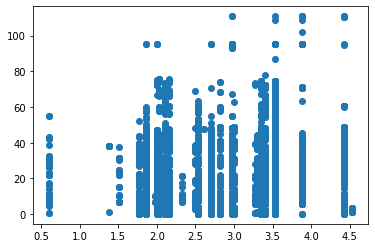

In [186]:
plt.scatter(appwater, scores)

In [187]:
stats.linregress(appwater, scores)

LinregressResult(slope=-0.07024235813358777, intercept=20.592118894123843, rvalue=-0.003561793512388927, pvalue=0.5707265307338243, stderr=0.12388658580639264)

In [188]:
statistic, edges, no = stats.binned_statistic(appwater, scores, 'mean', bins = 8)

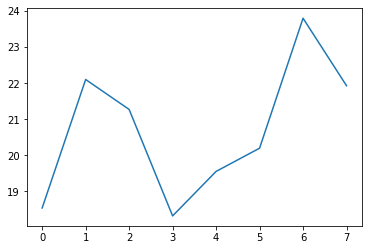

In [189]:
plt.plot(statistic)

In [179]:
statistic, edges, no = stats.binned_statistic(appwater, dists, 'mean', bins = 8)

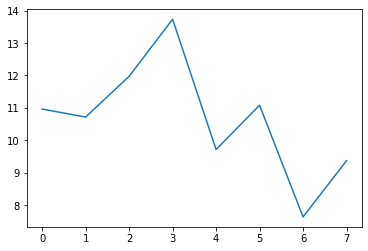

In [180]:
plt.plot(statistic)

In [107]:
pd.DataFrame(appwater, dists).to_csv("app_dist.csv")

In [84]:
scores

array([5097.33825599, 5326.88171322, 3736.59960667, ..., 4589.41833934,
       5229.10461092, 4067.30395809])

In [85]:
scores2

array([59.57773407, 65.7014693 , 51.5893303 , ..., 50.63785034,
       60.57039473, 45.92007329])

In [192]:
water_df.to_csv("../joined_combined_filtered_mined_soil_water_df_td_13_4.csv")